<h1> Solution of test task for INT20H Hackaton by team Data Insights </h1>
<br></br>
<h3>Designations</h3>
<p><span style="color:green">Green color</span> - data insights or conclusions</p> 
<p><span style="color:blue">Blue color</span> - section headings</p> 
<br></br>
<h2>Table of Contents</h2>

* [Loading and preparing data](#1)
* [Finding users properties with high and low correlation with the subscription cancellation](#2)
* [Finding correlation between events and subscription cancellation](#3)
* [Finding correlation between parameters of events with moderate or high correlation for subscription cancellation](#4)
    * [Correlation between parametrs of "Add Payment Method Success" event and subscription cancellation](#4.1)
    * [Correlation between parametrs of "Chat Conversation Opened" event and subscription cancellation](#4.2)
    * [Correlation between parametrs of "Subscription Premium" event and subscription cancellation ](#4.3)
    * [Correlation between parametrs of "Add Vehicle Success" event and subscription cancellation](#4.4)
    * [Correlation between parametrs of "Account History Transaction Details" event and subscription cancellation](#4.5)
* [Conclusions](#5)

<a id = "1"></a>
<h1 style="color:blue">1. Loading and preparing data</h1>
<br></br>
Firstly let's import all nessecsry libraries and functions that we will use for tasks's solution

In [1]:
import pandas as pd
import ast
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from dython.nominal import associations
from sklearn.metrics import matthews_corrcoef
from scipy import stats
from imblearn.over_sampling import SMOTEN,SMOTENC
import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter(action='ignore', category=FutureWarning)

In [2]:
#load dataset from csv file

df = pd.read_csv("int20h-ds-test-dataset.csv")
df.head()

,userid,user_state,event_name,event_attributes,event_created_date,event_platform,device_manufacture,device_model
0,c95c777785faec8dd910d019d7278ebe,CA,Add Vehicle Success,"{""Make"":""Dodge"",""Model"":""Caravan"",""Color"":""Whi...",2022-01-16 17:03:04,android,samsung,SM-N975U
1,c95c777785faec8dd910d019d7278ebe,CA,Add Vehicle Break,{},2022-01-16 17:07:47,android,samsung,SM-N975U
2,f344be2d9a042b7444f3cc5279e38ef1,FL,Calculator View,{},2022-01-16 17:16:25,android,samsung,SM-G973U1
3,c95c777785faec8dd910d019d7278ebe,CA,Add Payment Method Success,"{""Payment Method"":""Credit"",""Tokenized Pay"":""""}",2022-01-16 17:24:22,android,samsung,SM-N975U
4,e331ed81422d8fba55520a43a872e701,IL,Sign Up Success,"{""Method"":""Apple""}",2022-01-16 17:34:51,ios,Apple,"iPhone12,1"


<br>Next we will make labels of cancellation status for all user's transaction</br>

In [3]:
# all ids of users that cancel subscription
userid_cancel_sub = df[df["event_name"] == "Subscription Premium Cancel"]["userid"].unique()

In [4]:
# adding column which showing 1 if subscription were cancelled and 0 if no
def subscription_cancel_result(df):
    df["cancelled subscription"] = np.where(df["userid"].isin(userid_cancel_sub),1,0)
subscription_cancel_result(df)
df.head()

,userid,user_state,event_name,event_attributes,event_created_date,event_platform,device_manufacture,device_model,cancelled subscription
0,c95c777785faec8dd910d019d7278ebe,CA,Add Vehicle Success,"{""Make"":""Dodge"",""Model"":""Caravan"",""Color"":""Whi...",2022-01-16 17:03:04,android,samsung,SM-N975U,0
1,c95c777785faec8dd910d019d7278ebe,CA,Add Vehicle Break,{},2022-01-16 17:07:47,android,samsung,SM-N975U,0
2,f344be2d9a042b7444f3cc5279e38ef1,FL,Calculator View,{},2022-01-16 17:16:25,android,samsung,SM-G973U1,0
3,c95c777785faec8dd910d019d7278ebe,CA,Add Payment Method Success,"{""Payment Method"":""Credit"",""Tokenized Pay"":""""}",2022-01-16 17:24:22,android,samsung,SM-N975U,0
4,e331ed81422d8fba55520a43a872e701,IL,Sign Up Success,"{""Method"":""Apple""}",2022-01-16 17:34:51,ios,Apple,"iPhone12,1",0


In [5]:
cancel_count = len(df[df["event_name"] == "Subscription Premium Cancel"]["userid"])
print("Amount of cancellation of subscription is " + str(cancel_count))

Amount of cancellation of subscription is 271


<a id = "2"></a>
<br></br>
<h1 style="color:blue" id="2">2. Finding users properties with high and low correlation with the subscription cancellation</h1>

In [6]:
users_props_coefs = {}

<br>Now let's build bar charts to show the ratio of the amount of users and the unique values of their properties.</br>

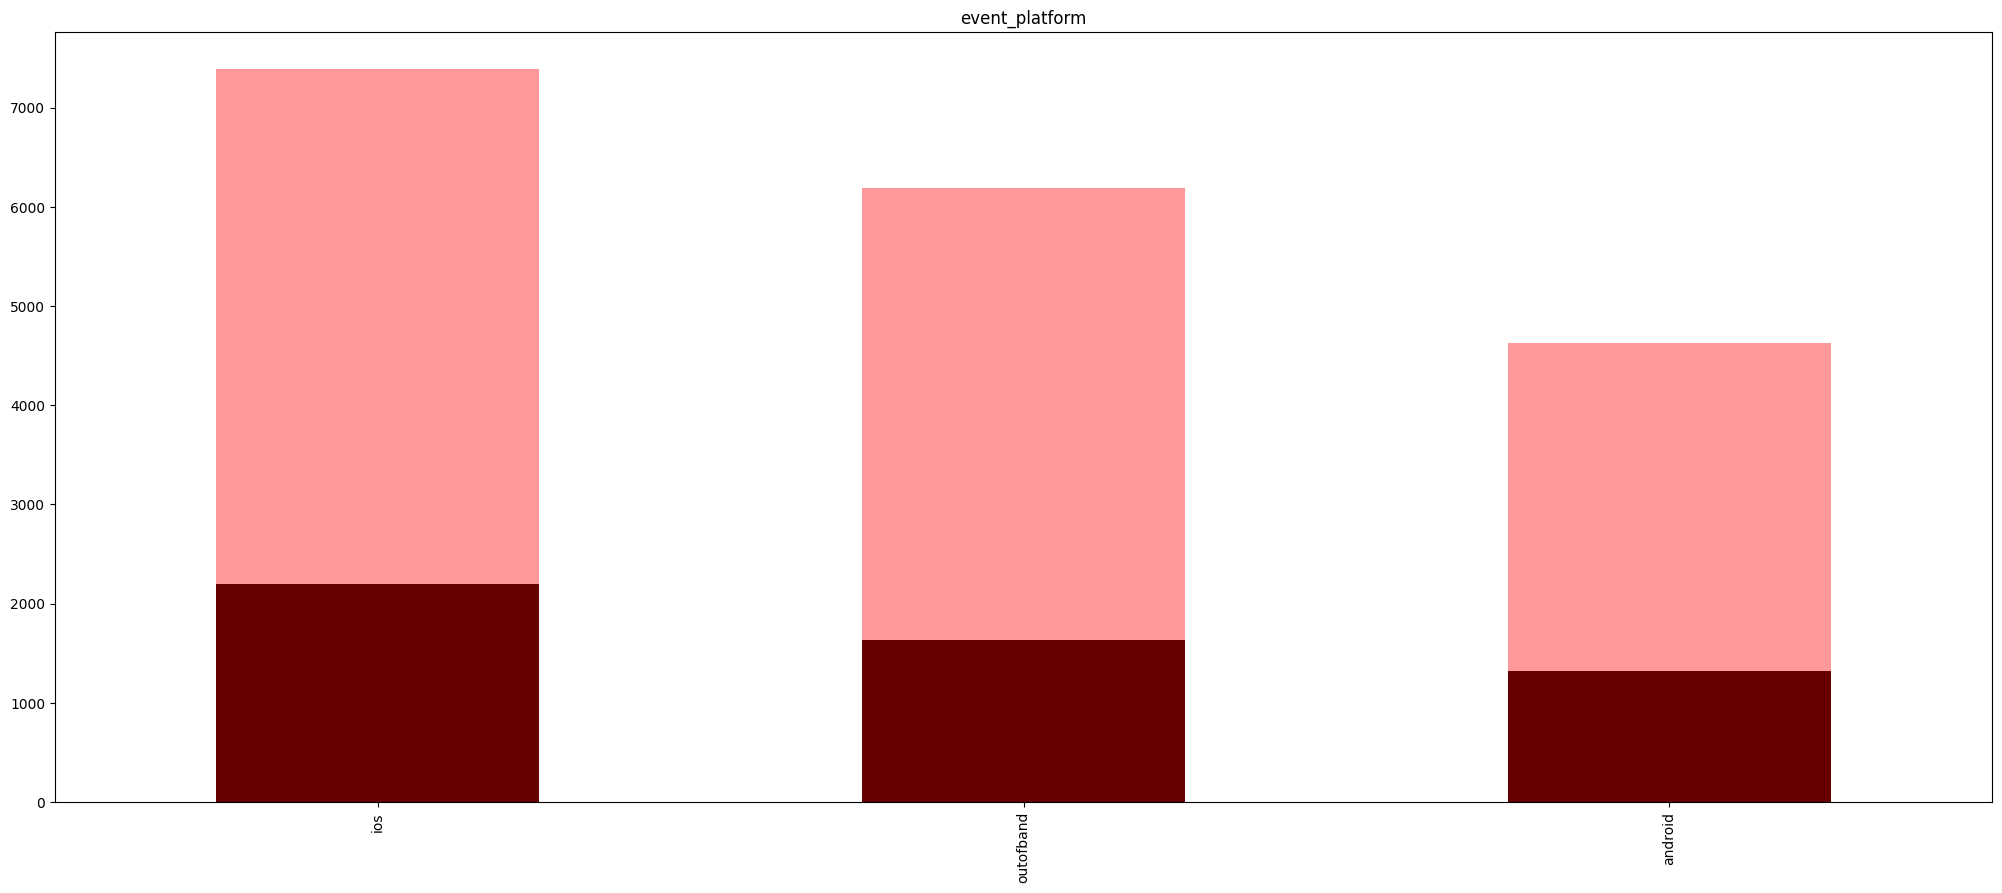

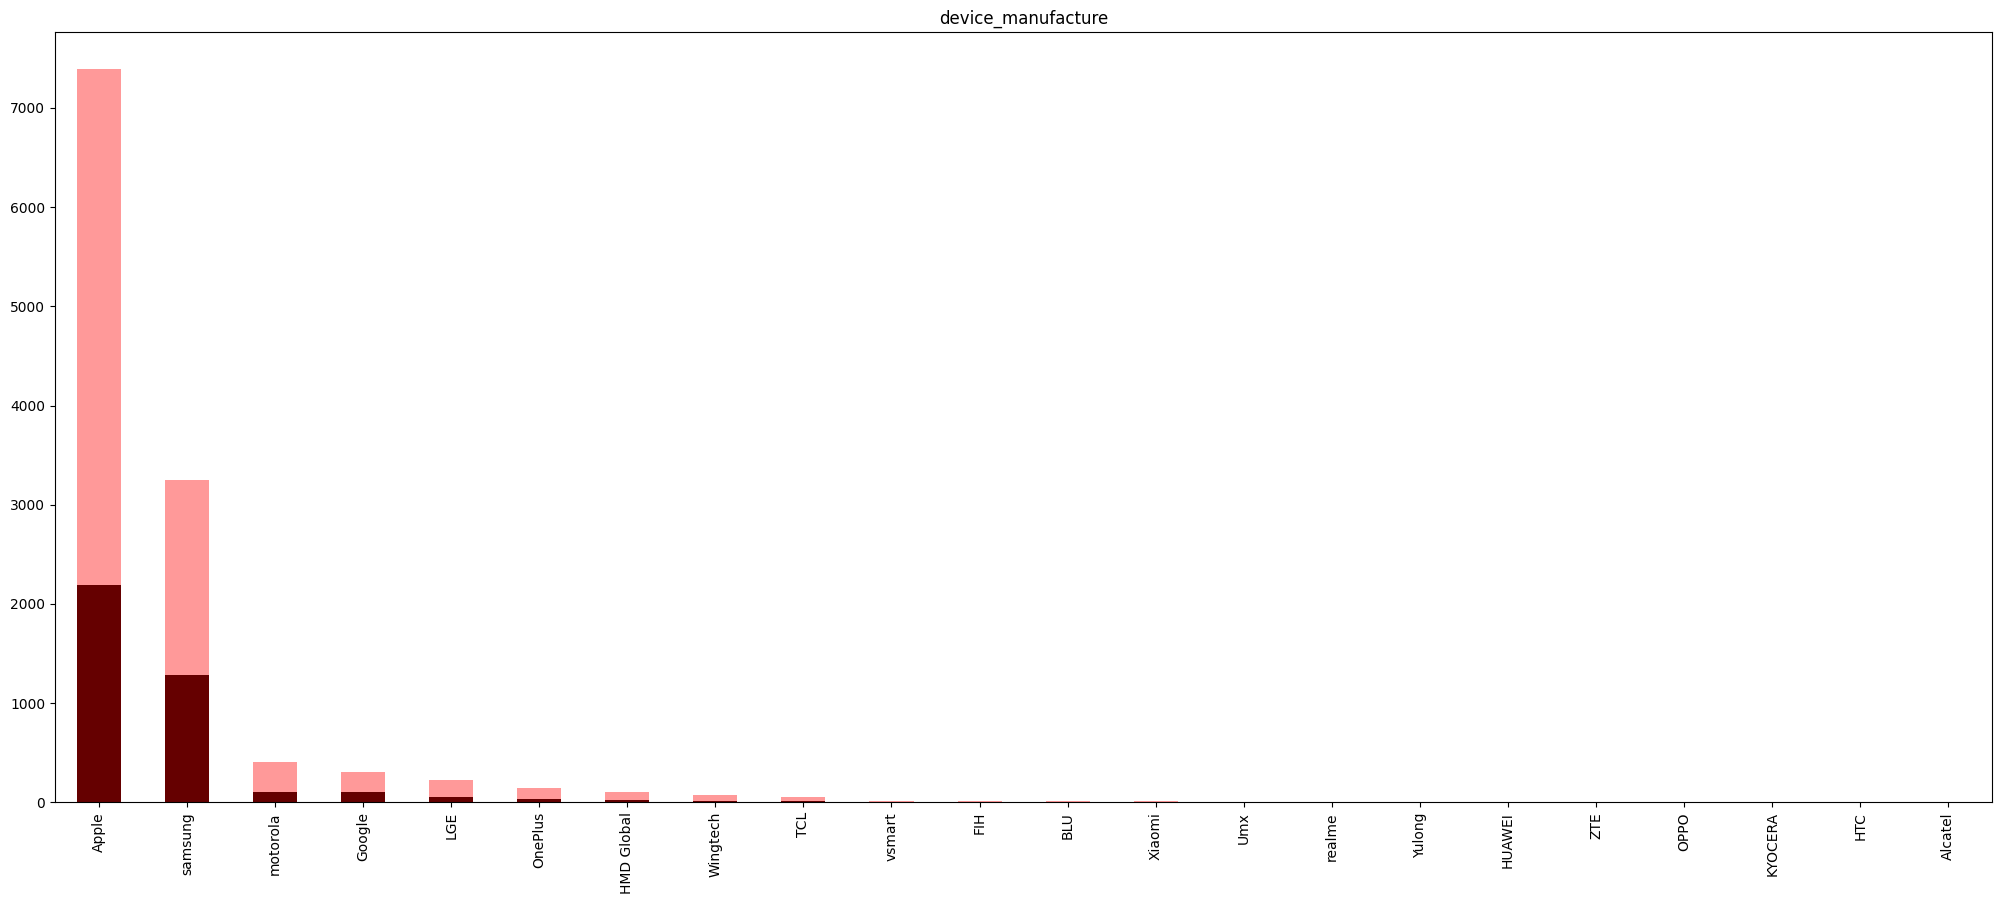

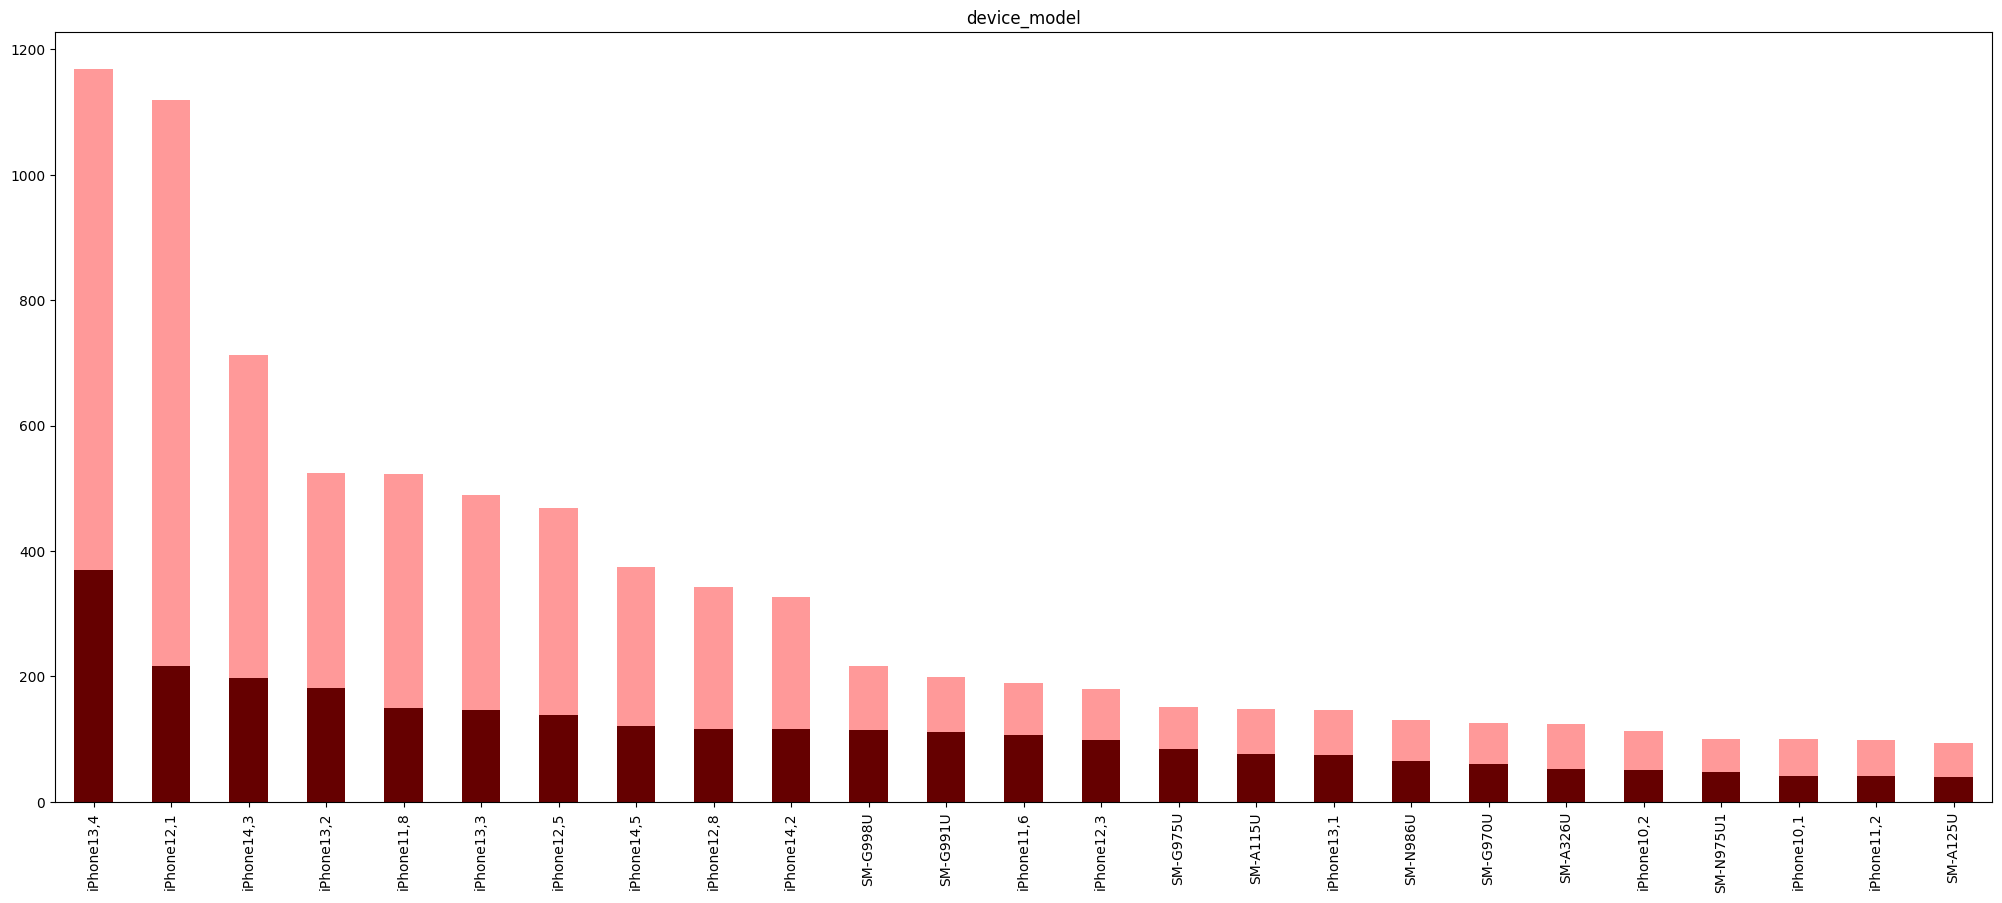

In [7]:
# histograms for days of using the app and user state
for i in df.columns[5:8]:
    fig, ax = plt.subplots(figsize=(25,10))
    df[df["cancelled subscription"] == 1][i].value_counts().head(25).plot.bar(ax=ax, title=i, color = "black")
    df[df["cancelled subscription"] == 0][i].value_counts().head(25).plot.bar(ax=ax, title=i, color = "red", alpha=0.4)
plt.show()

<br>Next, we want to create a dataframe, each row of which will show information about the number of days the application was used and from which platforms the user launched the program. The number of rows in this dataframe will be equal to the number of unique users.</br>

In [8]:
# grouping dataset by userid and analyzing parametrs event_created_date,event_platform,device_manufacture,user_state
d = df.groupby("userid")[["event_created_date","event_platform","device_manufacture","user_state"]]

user_info = pd.DataFrame()
ids, count_days, states, platforms, manufactures, result = [], [], [], [], [], []
for i,j in d:
    j["event_created_date"] = pd.to_datetime(j["event_created_date"])
    
    #count days of using app
    count_days.append((j["event_created_date"].max() - j["event_created_date"].min()).days)
    
    ids.append(i)
    states.append(j["user_state"].unique()[0])
    platforms.append(j["event_platform"].dropna().unique())
    dev_manuf = j["device_manufacture"].dropna().unique()
    if len(dev_manuf) == 0:
        manufactures.append("Unknown") #filling missing values of device_manufacture feature
    else:
        manufactures.append(j["device_manufacture"].dropna().unique()[0])
    if i in userid_cancel_sub:
        result.append(1)
    else:
        result.append(0)
        
user_info["user_id"] = ids
# adding new column that depends on days that user using the app (difference between last and first event)
user_info["days_using"] = count_days
user_info["user_state"] = states
user_info['event_platform'] = platforms
user_info['device_manufacture'] = manufactures
user_info["canceled subscription"] = result

In [9]:
user_info

,user_id,days_using,user_state,event_platform,device_manufacture,canceled subscription
0,0006869712ec9841dc36234bce245203,30,MD,"[android, outofband]",samsung,0
1,000a59897372c5e3c147b15685fefc65,0,CA,[ios],Apple,0
2,001244c572f1a681553bc045a378cacf,0,FL,[android],samsung,0
3,0032cb66b99f6baef57ec2aa04a9277f,0,CA,[ios],Apple,0
4,003f57fe2631ade57a86f6a2b96bb20c,0,CA,[ios],Apple,0
...,...,...,...,...,...,...
3535,ff9fd3437958123842f3ab75d22fc13f,0,CA,[android],samsung,0
3536,ffa1aa12dd53aee84976cb6c525bb17b,0,TX,[ios],Apple,0
3537,ffbbc97af52745060a9dff4eb9917f75,0,PA,[ios],Apple,0
3538,ffc566d97935423b6d7a3f9ba211a2b4,0,TX,[android],samsung,0


In [10]:
users_cancel_count = len(user_info[user_info["canceled subscription"]==1]["user_id"])
print("How many users canceled premium subscription = " + str(users_cancel_count))
multiple_cancel_users_count = (cancel_count - users_cancel_count)
print("Amount of users that canceled subscription more than once = " + str(multiple_cancel_users_count))

How many users canceled premium subscription = 251
Amount of users that canceled subscription more than once = 20


In [11]:
# one hot encoding for unique values of event_platform
user_info = pd.concat([user_info,pd.get_dummies(user_info['event_platform'].explode()).groupby(level=0).sum()], axis=1)
user_info.drop(columns = ["event_platform","user_id"], inplace=True)
user_info.head()

,days_using,user_state,device_manufacture,canceled subscription,android,ios,outofband
0,30,MD,samsung,0,1,0,1
1,0,CA,Apple,0,0,1,0
2,0,FL,samsung,0,1,0,0
3,0,CA,Apple,0,0,1,0
4,0,CA,Apple,0,0,1,0


In [12]:
# checking for missing values
user_info.isnull().sum()

days_using                0
user_state               63
device_manufacture        0
canceled subscription     0
android                   0
ios                       0
outofband                 0
dtype: int64

In [13]:
# replacing missing values with most frequent one in a user_state column
user_info["user_state"] = user_info["user_state"].fillna(user_info["user_state"].mode().iloc[0])

<br></br>
Let's build bar charts to show the ratio of the amount of users and the days using the app, user state.

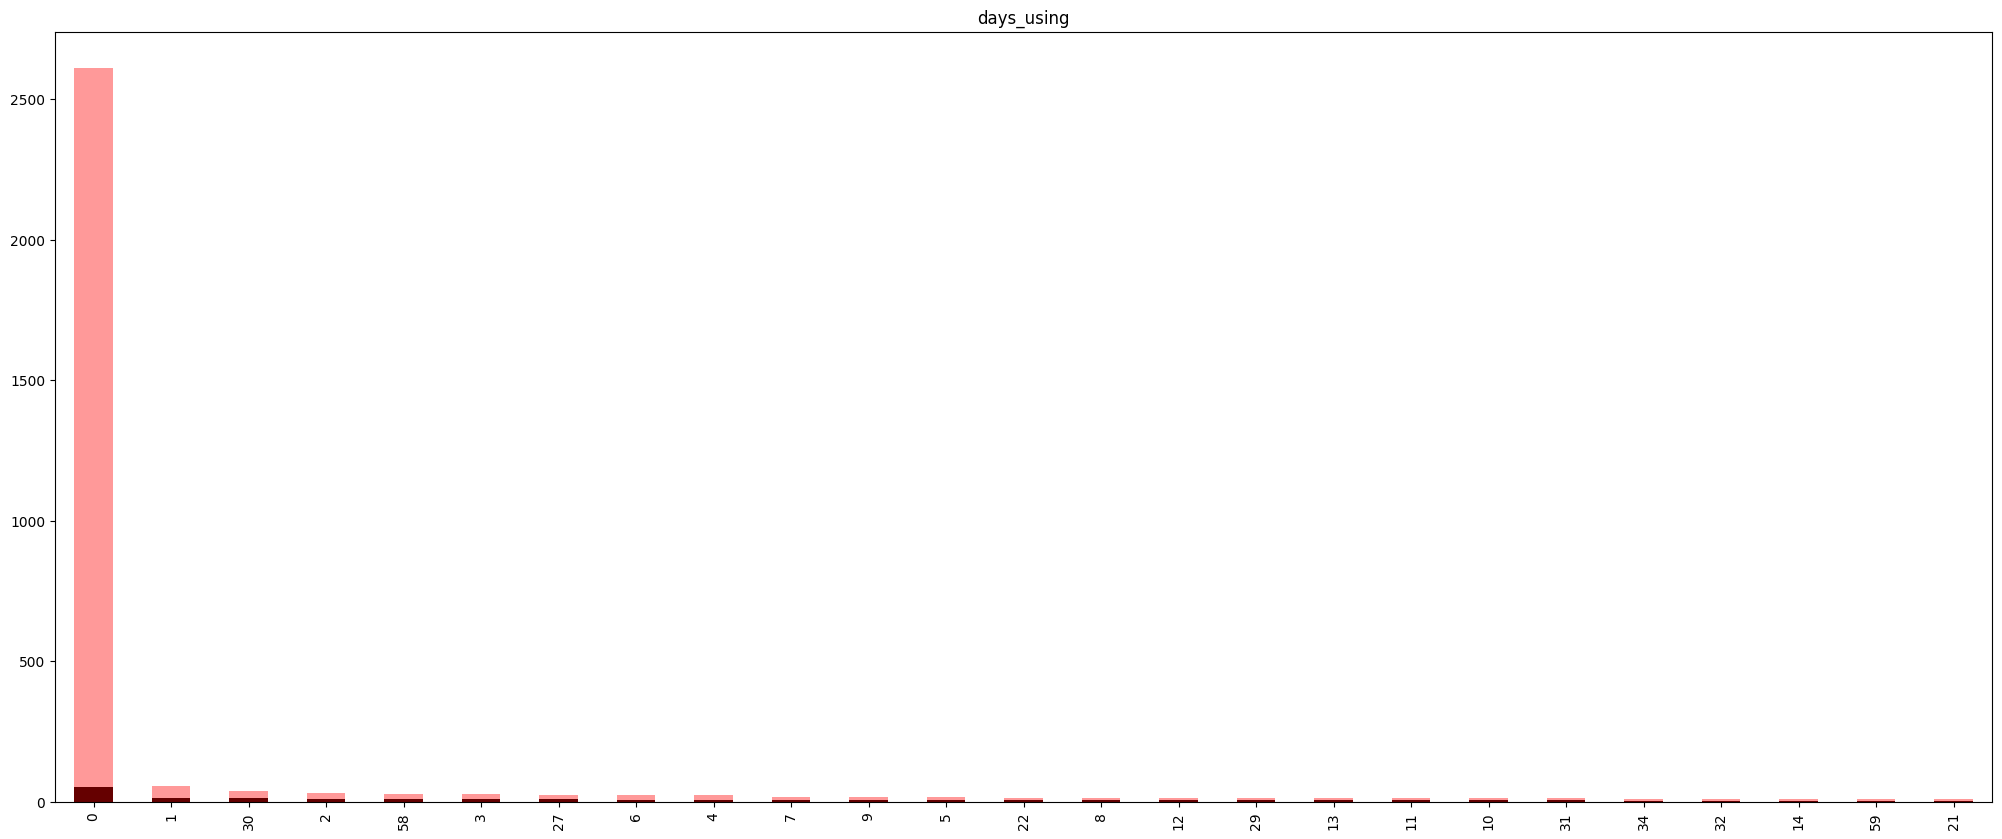

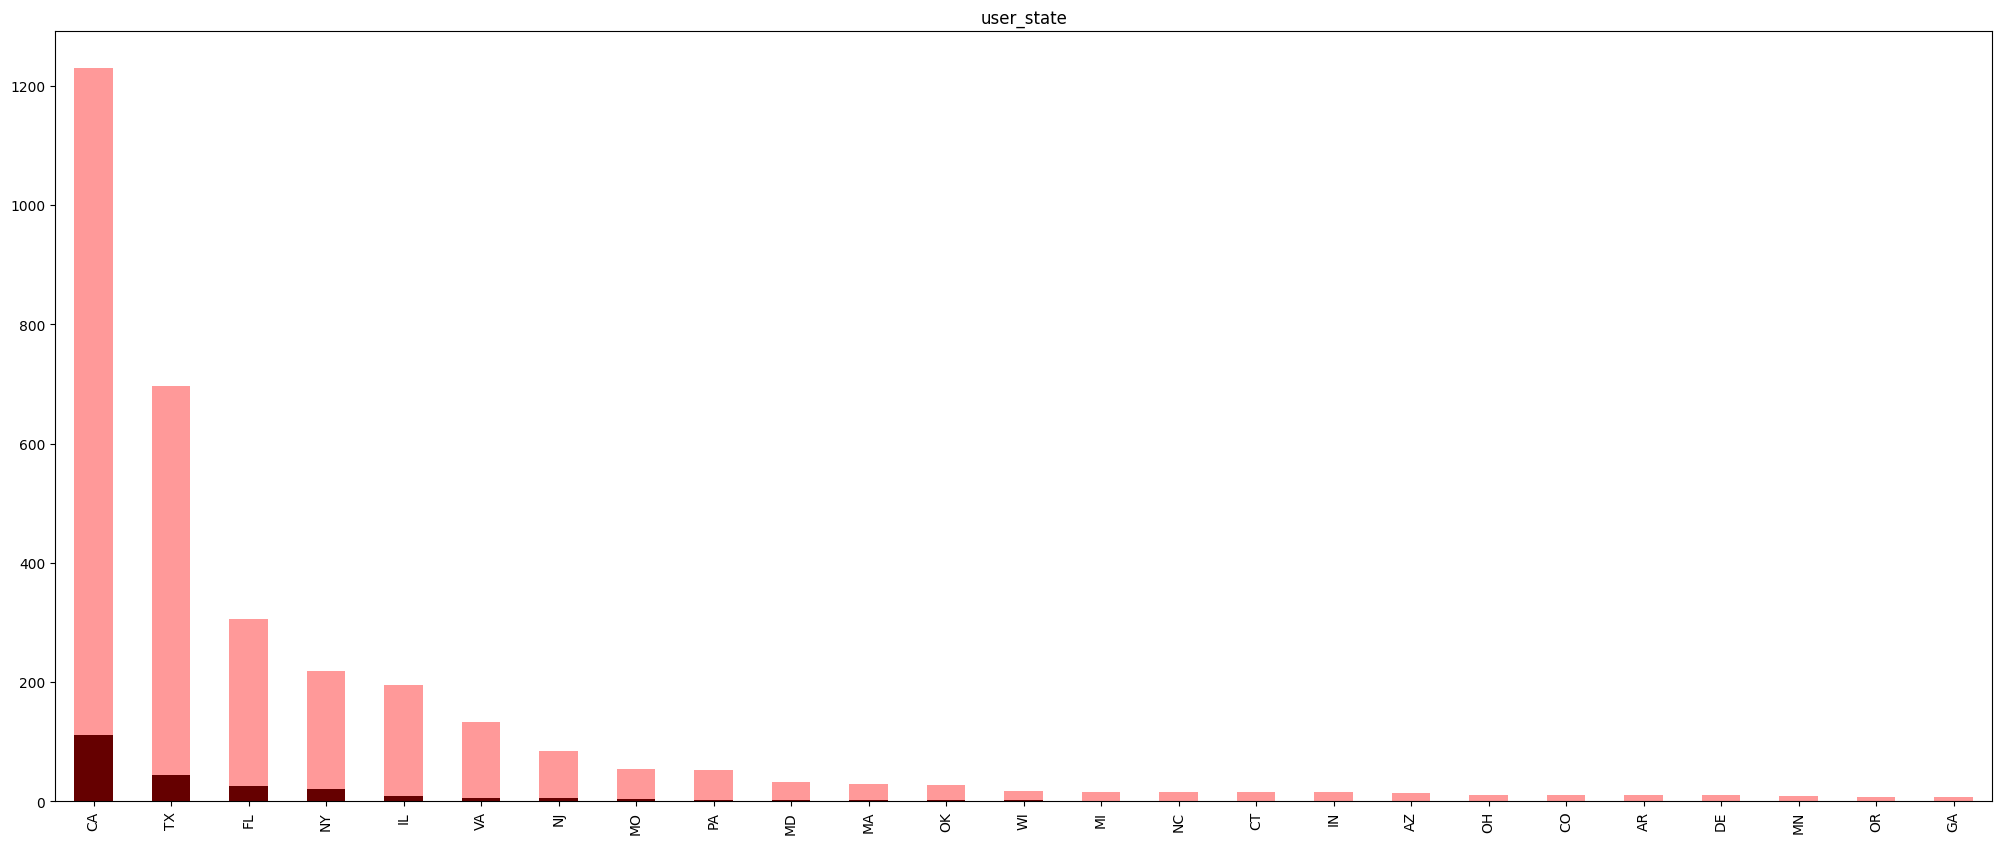

In [14]:
# histograms for days of using the app and user state
for i in ["days_using","user_state"]:
    fig, ax = plt.subplots(figsize=(25,10))
    user_info[user_info["canceled subscription"] == 1][i].value_counts().head(25).plot.bar(ax=ax, title=i, color = "black")
    user_info[user_info["canceled subscription"] == 0][i].value_counts().head(25).plot.bar(ax=ax, title=i, color = "red", alpha=0.4)
plt.show()

<br></br>
Next let's build plot to see balanced or imbalanced our dataset 

(0.0, 7000.0)

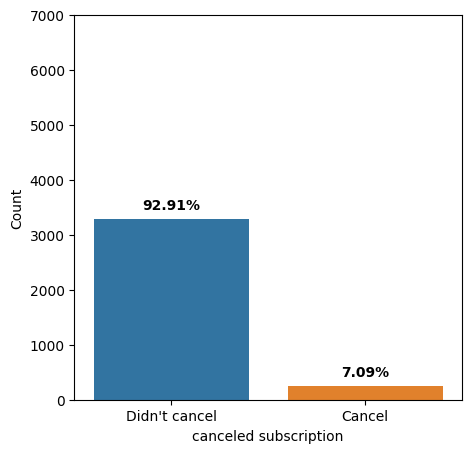

In [15]:
# how many users canceled subscription (counting cancellation per every user only one time)
fig, ax = plt.subplots(figsize = (5,5))
sns.countplot(x = "canceled subscription", data = user_info, ax = ax)

for index, value in enumerate(user_info["canceled subscription"].value_counts()):
    label = '{}%'.format(round((value / user_info["canceled subscription"].shape[0]) * 100, 2))
    ax.annotate(label,
               xy = (index, value + 250),
               ha = "center",
               va = "center",
               fontweight = "bold")
ax.set_xticklabels(["Didn't cancel","Cancel"])
ax.set_label("Subscription Premium Cancel")
ax.set_ylabel("Count")
ax.set_ylim([0,7000])

<br></br>
Our dataset is imbalanced. So to balanced it, we will use SMOTE (Synthetic Minority Oversampling Technique) approach.

In [16]:
sm = SMOTENC(categorical_features=[False, True,  True,  True,  True,  True])
new_X, new_Y = sm.fit_resample(user_info.drop("canceled subscription", axis = 1), user_info['canceled subscription'])
user_info = pd.concat([pd.DataFrame(new_Y), pd.DataFrame(new_X)], axis = 1)
user_info.head()

,canceled subscription,days_using,user_state,device_manufacture,android,ios,outofband
0,0,30,MD,samsung,1,0,1
1,0,0,CA,Apple,0,1,0
2,0,0,FL,samsung,1,0,0
3,0,0,CA,Apple,0,1,0
4,0,0,CA,Apple,0,1,0


For finding correlation between user properties and cancellation of subscription we will be using the Matthews correlation coefficient (MCC). It is used in machine learning as a measure of the quality of binary (two - class) classifications. So this coefficient we will calculate to diffrent kinds of platforms by which users entered to the app.

In [17]:
for col in user_info.columns[4:]:
    users_props_coefs[col] = matthews_corrcoef(user_info[col], user_info["canceled subscription"])
    print(col.ljust(21), matthews_corrcoef(user_info[col], user_info["canceled subscription"]))

android               0.0018737634313893581
ios                   0.007788956872126596
outofband             0.8185151169646593


<h2 style="color:green"> Event platform is highly correlated with subscription cancellation. Users that cancelled subsription were often accessing app by out of band platform. </h2>

<br></br>
For finding correlation between user state, device manufacture and subscription cancellation we will use Cramer's, which is used to examine the assocciation between two categorical variables when there is more than a 2x2 contigency.

In [18]:
# after analyzing the histograms, we will choose the most common values for the attributes, the rest of the values will be replaced by the word "Other"

user_info["user_state_2"] = np.where(user_info["user_state"].isin(user_info["user_state"].value_counts()[:4].index),user_info["user_state"],"Other")
user_info["device_manufactured_2"] = np.where(user_info["device_manufacture"].isin(user_info["device_manufacture"].value_counts()[:4].index),user_info["device_manufacture"],"Other")

In [19]:
user_info

,canceled subscription,days_using,user_state,device_manufacture,android,ios,outofband,user_state_2,device_manufactured_2
0,0,30,MD,samsung,1,0,1,Other,samsung
1,0,0,CA,Apple,0,1,0,CA,Apple
2,0,0,FL,samsung,1,0,0,FL,samsung
3,0,0,CA,Apple,0,1,0,CA,Apple
4,0,0,CA,Apple,0,1,0,CA,Apple
...,...,...,...,...,...,...,...,...,...
6573,1,41,CA,Apple,0,1,1,CA,Apple
6574,1,0,CA,Apple,0,1,1,CA,Apple
6575,1,0,CA,Apple,0,1,1,CA,Apple
6576,1,13,CA,samsung,1,0,1,CA,samsung


In [20]:
def cramers_v(x,y):
    confusion_matrix = pd.crosstab(x,y)
    chi2 = stats.chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum().sum()
    phi2 = chi2 / n
    r, k = confusion_matrix.shape
    phi2corr = max(0, phi2 - ((k - 1) * (r - 1)) / (n - 1))
    rcorr = r - ((r - 1) ** 2) / (n - 1)
    kcorr = k - ((k - 1) ** 2) / (n - 1)
    return np.sqrt(phi2corr/min((kcorr - 1), (rcorr - 1)))


cramer_v_val_dict = {}
for col in user_info.columns[7:]:
    cramer_v_val_dict[col] = cramers_v(user_info[col],user_info["canceled subscription"])
cramer_v_val_dict    
cramer_v_val_dict_sorted = sorted(cramer_v_val_dict.items(), key = lambda x:x[1], reverse = True)
for k,v in cramer_v_val_dict_sorted:
    users_props_coefs[k[:-2]] = v
    print(k.ljust(21), v)

user_state_2          0.32705959291506376
device_manufactured_2 0.22074032630342363


<h2 style="color:green">User state has moderate corellation with subscription cancellation.</h2>
<h2 style="color:green">Device manufactured has weak corellation with subscription cancellation.</h2>

For a days of using app we will calculate a Pearson correlation coefficient.

In [21]:
users_props_coefs["days_using"] = stats.pearsonr(user_info["days_using"], 
                                                 user_info["canceled subscription"]).statistic
stats.pearsonr(user_info["days_using"], user_info["canceled subscription"])

PearsonRResult(statistic=0.398306102231521, pvalue=5.242998221590412e-249)

<h2 style="color:green">Days of using app has moderate corellation with subscription cancellation.</h2>

To find corellation between specific user states and cancellation of premium subscription we will again use Cramer's V

In [22]:
states = user_info
states = states.drop(["days_using", "user_state","device_manufacture", "android", "ios", "outofband", "device_manufactured_2"], axis=1)
states = pd.concat([states["canceled subscription"], pd.get_dummies(states["user_state_2"])], axis=1)


cramer_v_val_dict = {}
for col in states.columns.values[1:]:
    cramer_v_val_dict[col] = cramers_v(states[col],states["canceled subscription"])

cramer_v_val_dict_sorted = sorted(cramer_v_val_dict.items(), key = lambda x:x[1], reverse = True)
for k,v in cramer_v_val_dict_sorted:
    print(k.ljust(21), v)    

Other                 0.30475394529836614
CA                    0.22747783012760067
TX                    0.03329644847292582
IL                    0.023205606803913727
FL                    0.0


<h2 style="color:green"> CA state weakly corellated with subscription cancellation. </h2>

<br></br>
<a id = "users_params_list"></a>
<h2 style="color:green">An ordered list of user properites from highest to lowest correlation with subscription cancellation.</h2>

In [23]:
users_props_coefs = sorted(users_props_coefs.items(), key = lambda x:x[1], reverse = True)
for k, v in users_props_coefs:
    print('\033[92m' + str(k) + " ~ " + str(round(v,2)) )

outofband ~ 0.82
days_using ~ 0.4
user_state ~ 0.33
device_manufactured ~ 0.22
ios ~ 0.01
android ~ 0.0


<a id = "3"></a>
<br></br>
<h1 style="color:blue" id="3">3. Finding correlation between events and subscription cancellation</h1>

In [24]:
events_coefs = {}

<br><br>
We want to create new dataframe each row of which will show what user did before cancelling subscription. However, if user cancelled premium subscription multiple times, we will consider all events. The number of rows in this dataframe will be equal to the number of unique users.

In [25]:
# unique users in dataset
len(df.userid.unique())

3540

In [26]:
# all different possible events in dataset
all_events = df.event_name.unique()
all_events

array(['Add Vehicle Success', 'Add Vehicle Break', 'Calculator View',
       'Add Payment Method Success', 'Sign Up Success',
       'Add Payment Method Failed', 'Wallet Opened', 'Transaction Refund',
       'Email Confirmation Success', 'Account Setup Skip',
       'Subscription Premium', 'Chat Conversation Opened',
       'Account Setup Profile Skip',
       'Account History Transaction Details', 'Sign Out',
       'Chat Conversation Started', 'Order', 'Sign Up Error',
       'Subscription Premium Cancel', 'Calculator Used',
       'Subscription Premium Renew', 'Add Vehicle Failed',
       'Reset Password Set'], dtype=object)

In [27]:
# from dataset for every user leaving only events that user did before cancelling subscription
# it is possible that user canceling subscription two or more times, then leaving all events before
# last cancellation of subscription

d = df.groupby("userid")[["event_created_date","event_name"]]
double_cancelation = 0
all_rows = []
for i,j in d:
    if i in userid_cancel_sub:
        numb = j["event_name"].value_counts()["Subscription Premium Cancel"]
        indx = list(j[j["event_name"] == "Subscription Premium Cancel"].index)
        if numb == 1:
            j = j.loc[:indx[0]]
        if numb >= 2:
            if np.diff(indx) > 1:
                double_cancelation +=1
                j = j.loc[:indx[-1]]
            else:
                j = j.loc[:indx[0]]
    all_rows.append(dict(j["event_name"].value_counts()))

In [28]:
events_df = pd.DataFrame(all_rows).fillna(0)
for col in events_df.columns:
    events_df[col] = events_df[col].astype(np.int32)
events_df.insert(loc = 0, column = "userid", value = ids)
events_df["Subscription Premium Cancel"] = np.where(events_df["Subscription Premium Cancel"] == 2,1,events_df["Subscription Premium Cancel"])

In [29]:
events_df.head()

,userid,Account History Transaction Details,Add Payment Method Success,Subscription Premium,Add Vehicle Success,Subscription Premium Renew,Sign Up Success,Account Setup Profile Skip,Calculator View,Order,...,Wallet Opened,Email Confirmation Success,Add Payment Method Failed,Account Setup Skip,Calculator Used,Subscription Premium Cancel,Sign Up Error,Add Vehicle Failed,Reset Password Set,Transaction Refund
0,0006869712ec9841dc36234bce245203,2,1,1,1,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,000a59897372c5e3c147b15685fefc65,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,001244c572f1a681553bc045a378cacf,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0032cb66b99f6baef57ec2aa04a9277f,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,003f57fe2631ade57a86f6a2b96bb20c,0,0,0,1,0,1,2,1,0,...,0,0,0,0,0,0,0,0,0,0


<br></br>
Next let's find binary features

In [30]:
binary_feature_cols = []
for col in events_df.columns[1:]:
    if len(events_df[col].unique()) == 2 and col != "Subscription Premium Cancel":
        binary_feature_cols.append(col)

In [31]:
events_df.drop(columns="userid",inplace=True)

In [32]:
# the same as for user info dataset, we will use SMOTE approach
sm = SMOTEN()
new_X, new_Y = sm.fit_resample(events_df.drop("Subscription Premium Cancel", axis = 1), events_df['Subscription Premium Cancel'])
events_df = pd.concat([pd.DataFrame(new_Y), pd.DataFrame(new_X)], axis = 1)
events_df.head()

,Subscription Premium Cancel,Account History Transaction Details,Add Payment Method Success,Subscription Premium,Add Vehicle Success,Subscription Premium Renew,Sign Up Success,Account Setup Profile Skip,Calculator View,Order,...,Chat Conversation Started,Wallet Opened,Email Confirmation Success,Add Payment Method Failed,Account Setup Skip,Calculator Used,Sign Up Error,Add Vehicle Failed,Reset Password Set,Transaction Refund
0,0,2,1,1,1,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,1,0,1,2,1,0,...,0,0,0,0,0,0,0,0,0,0


Now we will create distribution plots for all events

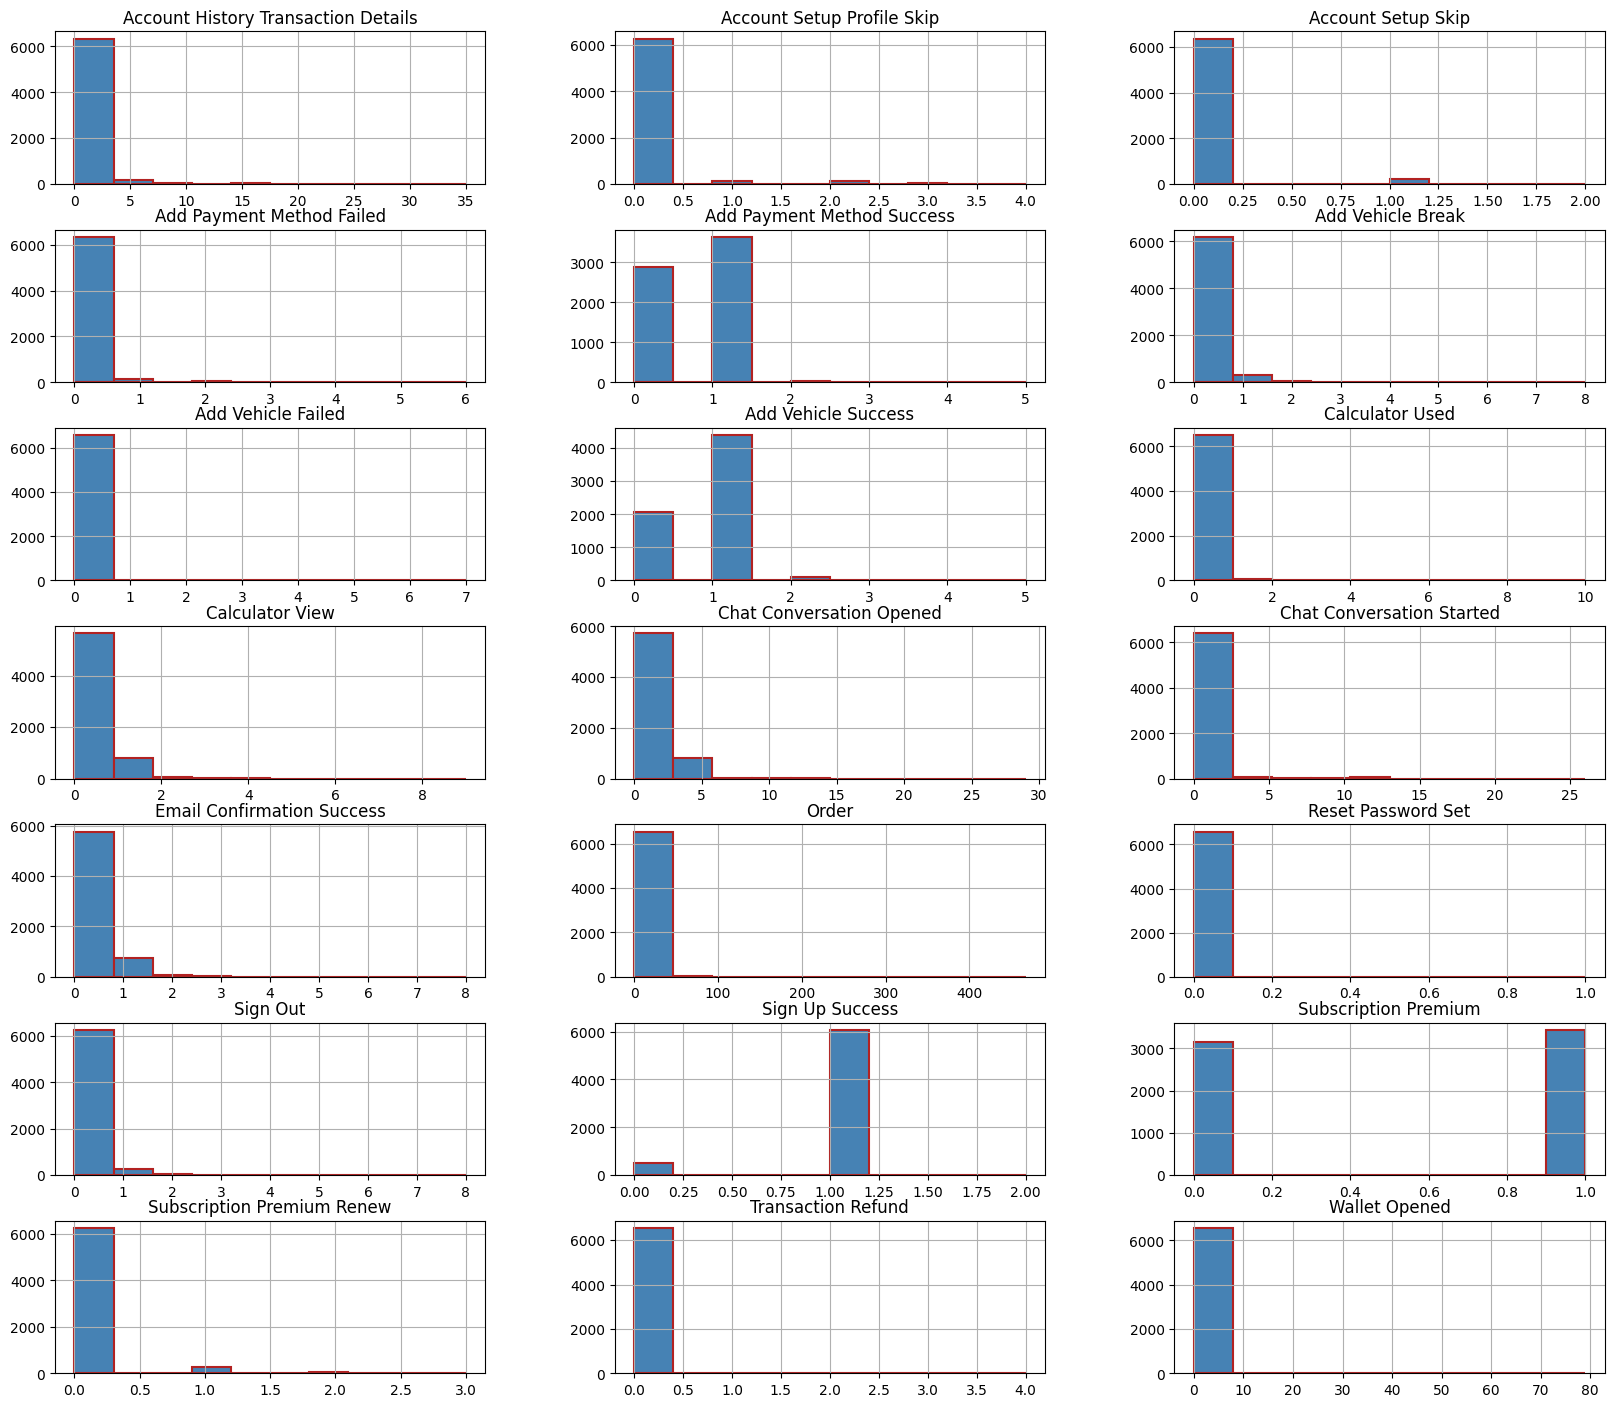

In [33]:
col_names = np.union1d(events_df.columns[1:19].values, events_df.columns[20:].values)
events_df[col_names].hist(figsize = (20,20),
                         layout = (8,3),
                         color = "steelblue",
                         edgecolor = "firebrick",
                         linewidth = 1.5)
plt.show()

In [34]:
# MCC coefficient for binary features in dataset
for col in binary_feature_cols:
    events_coefs[col] = matthews_corrcoef(events_df[col], events_df["Subscription Premium Cancel"])
    print(col.ljust(21), matthews_corrcoef(events_df[col], events_df["Subscription Premium Cancel"]))

Subscription Premium  0.7490104543615973
Reset Password Set    -0.012330653077658751


<h2 style="color:green">Buying Subscription Premium is highly correlated with premium subscription cancellation.</h2>

<br></br>
Now we will analyze polytomous features. We will separately consider features that have a large range of unique values.

In [35]:
polytomous_feature_cols = []
for col in events_df.columns[1:]:
    if 2 < len(events_df[col].unique()) <= 6:
        polytomous_feature_cols.append(col)

In [36]:
polytomous_feature_cols

['Add Payment Method Success',
 'Add Vehicle Success',
 'Subscription Premium Renew',
 'Sign Up Success',
 'Account Setup Profile Skip',
 'Add Payment Method Failed',
 'Account Setup Skip',
 'Sign Up Error',
 'Add Vehicle Failed',
 'Transaction Refund']

In [37]:
# cramer's v coefficients
cramer_v_val_dict = {}
for col in polytomous_feature_cols:
    cramer_v_val_dict[col] = cramers_v(events_df[col],events_df["Subscription Premium Cancel"])
cramer_v_val_dict_sorted = sorted(cramer_v_val_dict.items(), key = lambda x:x[1], reverse = True)
for k,v in cramer_v_val_dict_sorted:
    events_coefs[k] = v
    print(k.ljust(21), v)

Add Payment Method Success 0.6982989879381868
Add Vehicle Success   0.4506652095760317
Account Setup Skip    0.16727611898508876
Add Payment Method Failed 0.16032393772798179
Account Setup Profile Skip 0.14697181041971005
Subscription Premium Renew 0.08880650946141219
Sign Up Success       0.07976347807568904
Transaction Refund    0.05677709460284896
Sign Up Error         0.03991453943534536
Add Vehicle Failed    0.016574760668668635


<h2 style="color:green">Adding Payment Method Success and Add Vehicle Success is moderately correlated with premium subscription cancellation</h2>
<br></br>

In [38]:
polytomous_feature_cols2 = []
for col in events_df.columns[1:]:
    if len(events_df[col].unique()) > 6:
        polytomous_feature_cols2.append(col)
cramer_v_val_dict = {}
for col in polytomous_feature_cols2:
    counts = events_df[col].value_counts()
    indxs = counts[counts > 25].index
    cramer_v_val_dict[col] = cramers_v(events_df[events_df[col].isin(indxs.values)][col],events_df[events_df[col].isin(indxs.values)]["Subscription Premium Cancel"])
cramer_v_val_dict_sorted = sorted(cramer_v_val_dict.items(), key = lambda x:x[1], reverse = True)
for k,v in cramer_v_val_dict_sorted:
    events_coefs[k] = v
    print(k.ljust(21), v)

Chat Conversation Started 0.7527410835293645
Chat Conversation Opened 0.6272624954884636
Wallet Opened         0.5883482515931808
Account History Transaction Details 0.5180734901049773
Email Confirmation Success 0.2607495518065683
Add Vehicle Break     0.19988595942780343
Sign Out              0.1657115382259459
Calculator View       0.1534852455871983
Order                 0.1484995715899025
Calculator Used       0.014461067040748319


<h2 style="color:green"> High degree of correlation for Chat Conversation Started </h2>
<h2 style="color:green"> And moderate degree for Chat Conversation Opened, Wallet Opened and Account History Transaction Details</h2>

<a id = "events_list"></a>
<br></br>
<h2 style="color:green">An ordered list of events from highest to lowest correlation with subscription cancellation.</h2>

In [39]:
events_coefs = sorted(events_coefs.items(), key = lambda x:x[1], reverse = True)
for k, v in events_coefs:
    print('\033[92m' + str(k) + " ~ " + str(round(v,2)) )

Chat Conversation Started ~ 0.75
Subscription Premium ~ 0.75
Add Payment Method Success ~ 0.7
Chat Conversation Opened ~ 0.63
Wallet Opened ~ 0.59
Account History Transaction Details ~ 0.52
Add Vehicle Success ~ 0.45
Email Confirmation Success ~ 0.26
Add Vehicle Break ~ 0.2
Account Setup Skip ~ 0.17
Sign Out ~ 0.17
Add Payment Method Failed ~ 0.16
Calculator View ~ 0.15
Order ~ 0.15
Account Setup Profile Skip ~ 0.15
Subscription Premium Renew ~ 0.09
Sign Up Success ~ 0.08
Transaction Refund ~ 0.06
Sign Up Error ~ 0.04
Add Vehicle Failed ~ 0.02
Calculator Used ~ 0.01
Reset Password Set ~ -0.01


<a id = "4"></a>
<br></br>
<h1 style="color:blue" id="4">4. Finding correlation between parameters of events with moderate or high correlation for subscription cancellation</h1>

In [40]:
events_attrs_coefs = {}

<a id = "4.1"></a>
<h2>4.1 Correlation between parametrs of "Add Payment Method Success" event and subscription cancellation </h2> 

We want to create dataframe that consits of all transactions with event "Add Payment Method Success". This dataframe will have new columns - parameters of event

In [41]:
add_payment_method_success = df[df["event_name"] == "Add Payment Method Success"]

#parse dictionary (event_attributes) to separate values
converted_dict_by_event_attrs = add_payment_method_success.event_attributes.apply(lambda x : pd.Series(ast.literal_eval(x))).fillna(0) 

# concatinate vertically dataframes
add_payment_method_success = add_payment_method_success.join(converted_dict_by_event_attrs)
add_payment_method_success = add_payment_method_success.drop(add_payment_method_success.columns[1:8], axis=1)

add_payment_method_success['Tokenized Pay'] = add_payment_method_success['Tokenized Pay'].replace(["",0], "Missing")
add_payment_method_success['Promo code'] = add_payment_method_success['Promo code'].replace(["",0], "Missing")
add_payment_method_success.head()

,userid,cancelled subscription,Payment Method,Tokenized Pay,Promo code
3,c95c777785faec8dd910d019d7278ebe,0,Credit,Missing,Missing
15,5b5ee48d9887d347ce297bc14c395f7a,0,Credit,Missing,Missing
32,017f4557810b3ba165d2959c17b916b6,0,Debit,Apple Pay,Missing
39,da823e0efb16f00e73e2cbf1d8951649,0,Credit,Missing,Missing
80,ce5e12da979c5968f141f3aa9df94575,0,Credit,Missing,Missing


Next let's create histograms for distributions of event's parameters

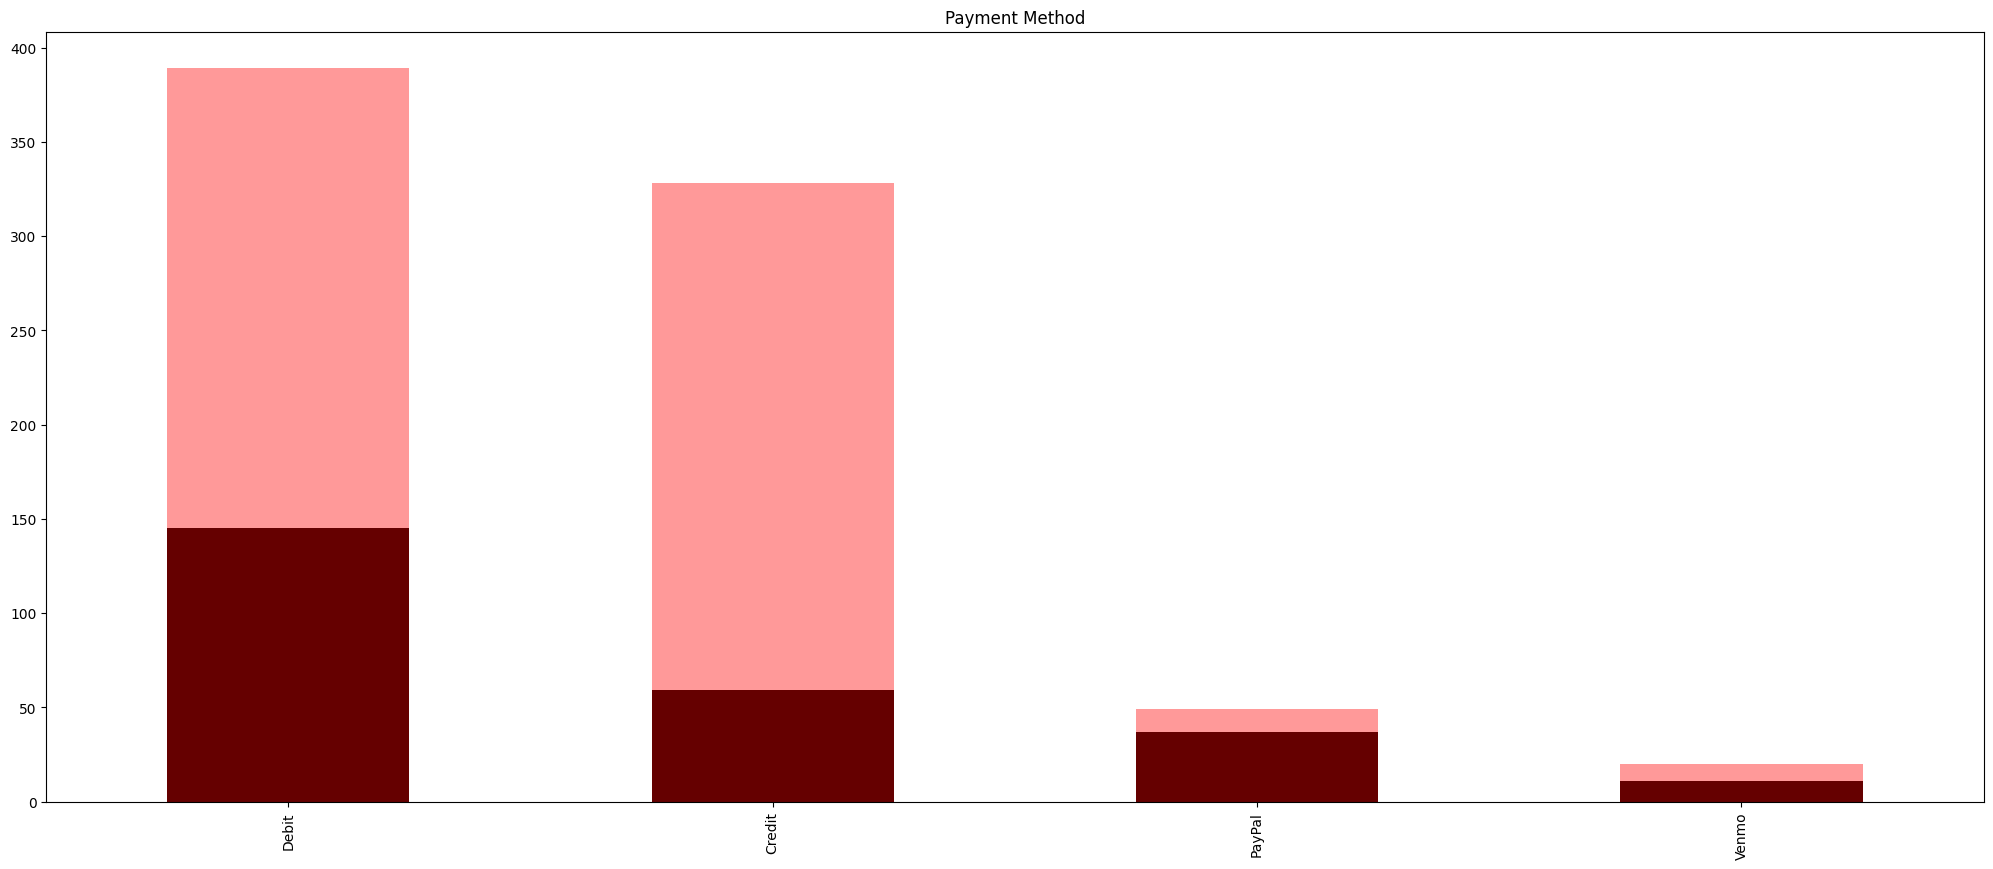

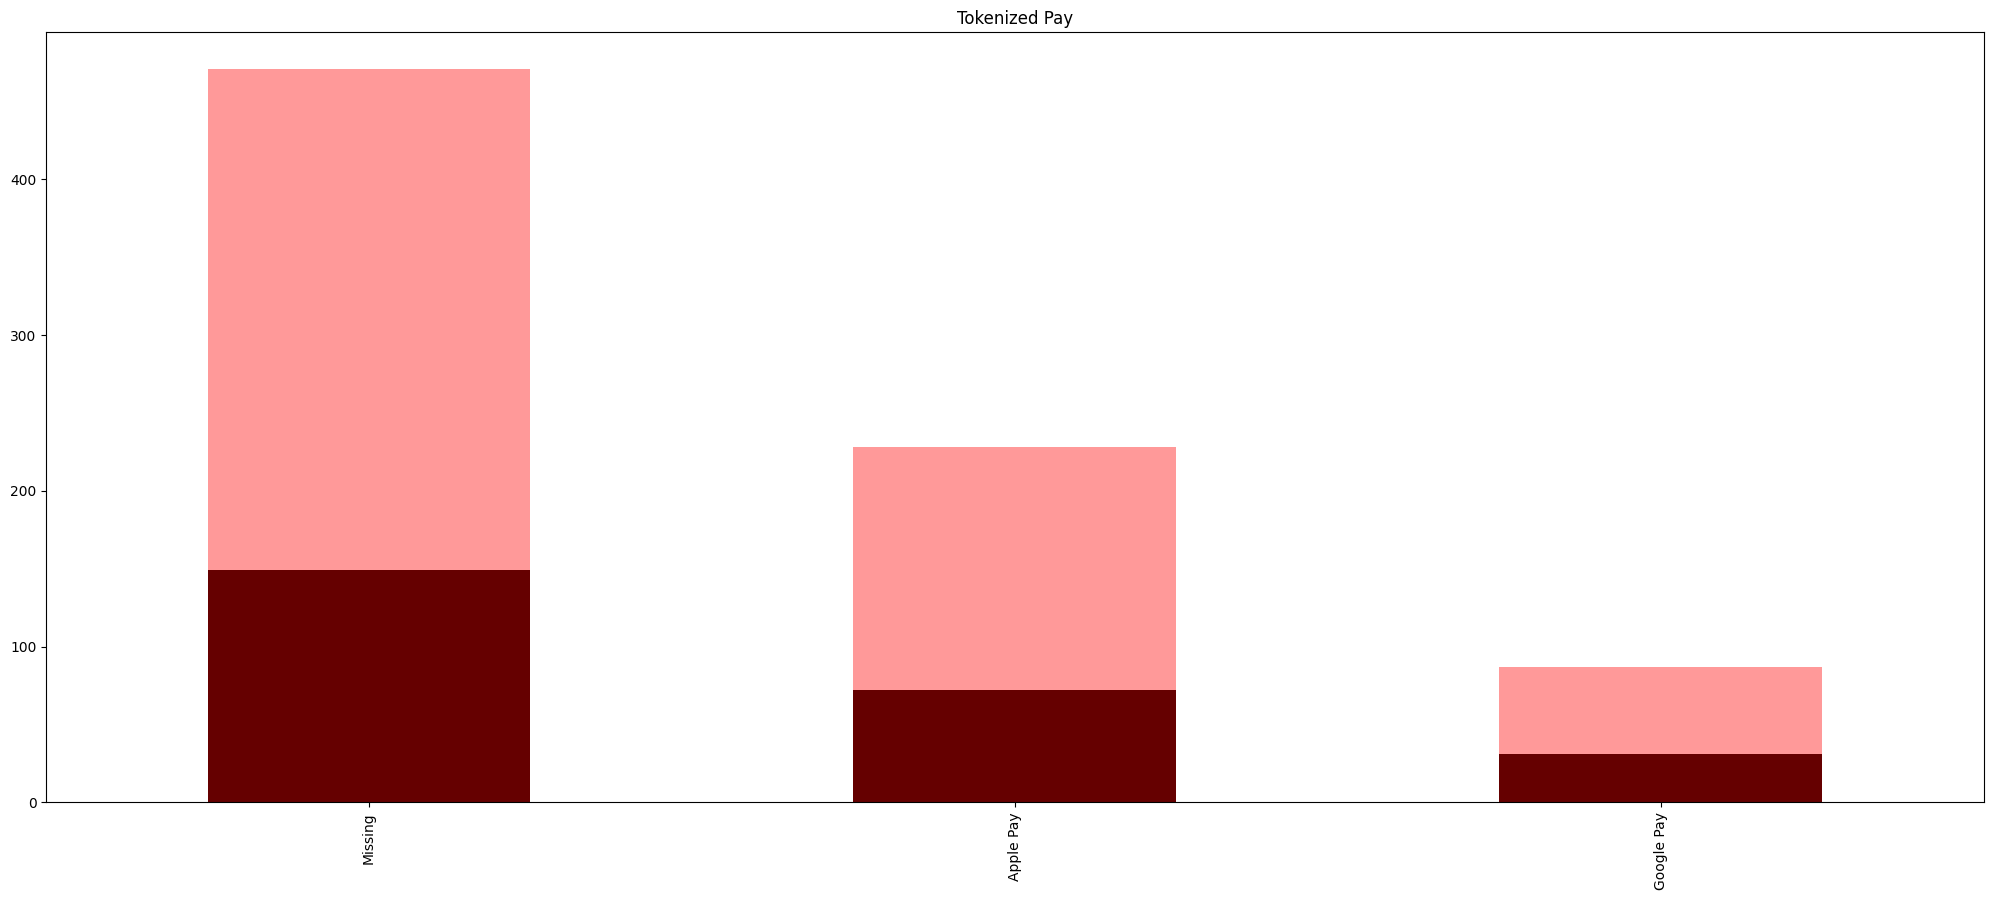

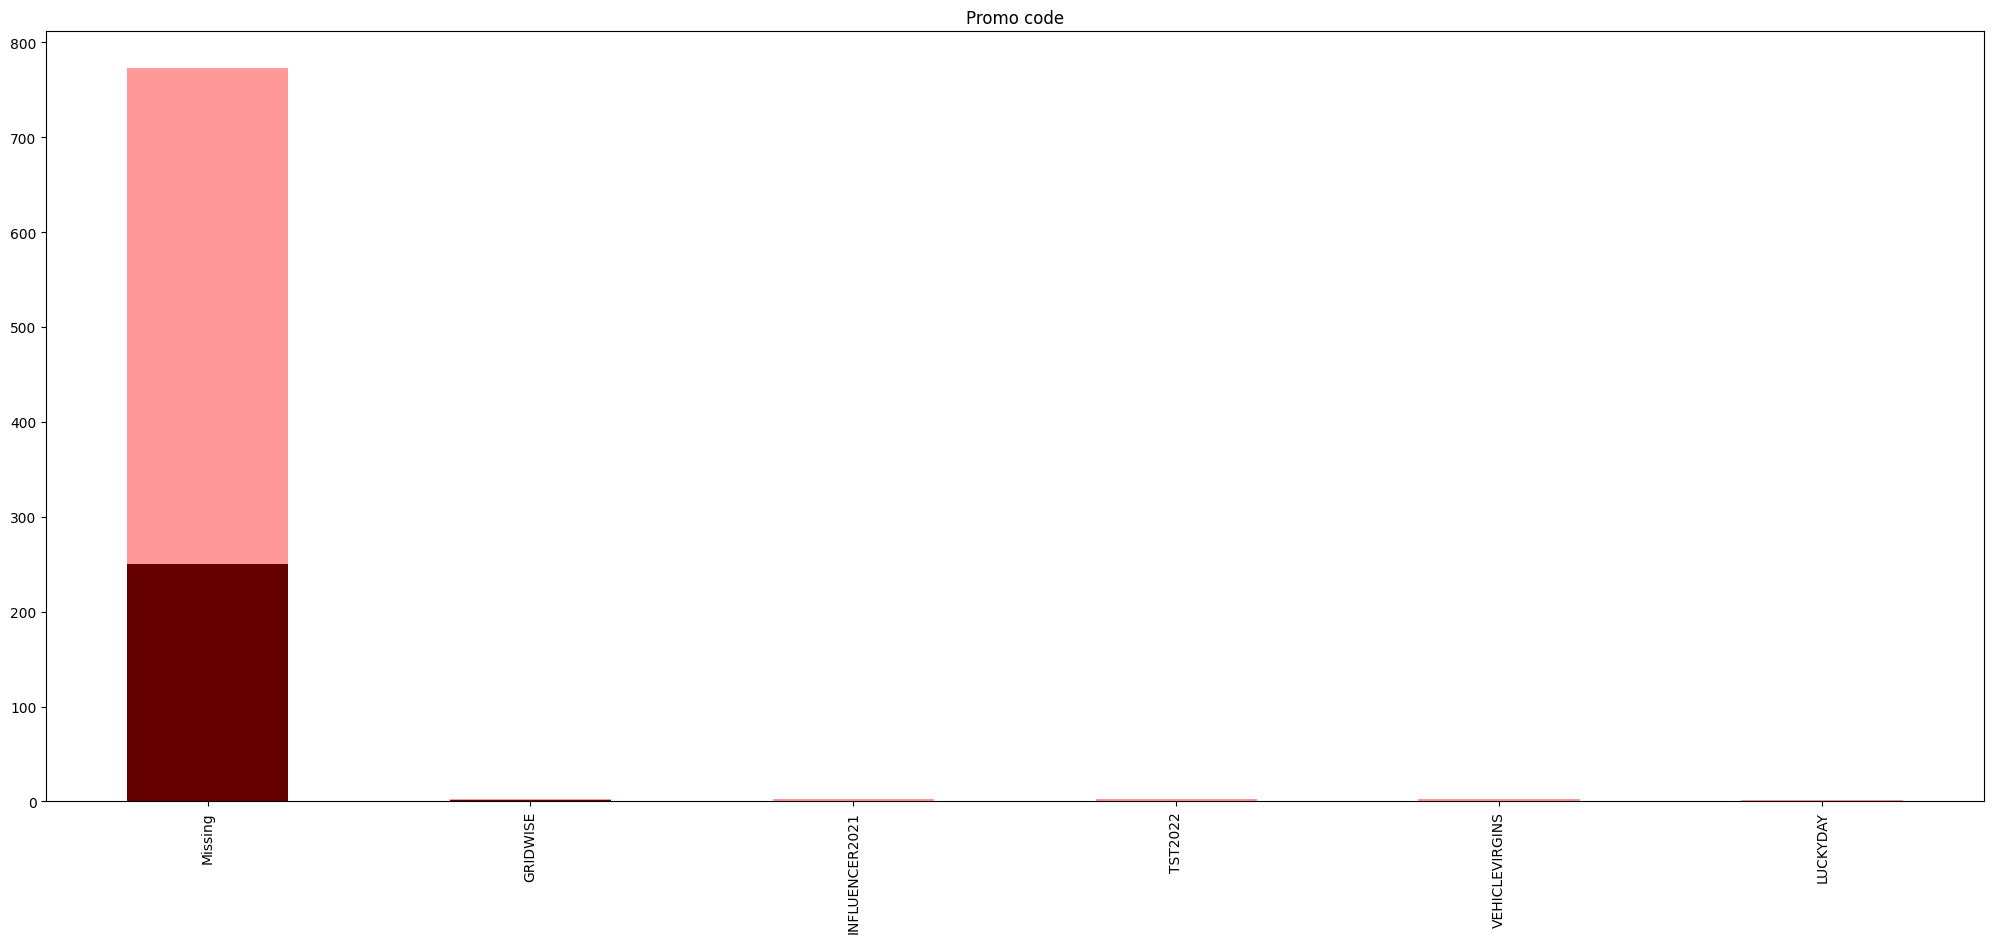

In [42]:
for i in add_payment_method_success.columns[2:]:
    fig, ax = plt.subplots(figsize=(25,10))
    add_payment_method_success[add_payment_method_success["cancelled subscription"] == 1][i].value_counts().head(25).plot.bar(ax=ax, title=i, color = "black")
    add_payment_method_success[add_payment_method_success["cancelled subscription"] == 0][i].value_counts().head(25).plot.bar(ax=ax, title=i, color = "red", alpha=0.4)
plt.show()

#### As we see, in most cases Promo code have missing values (zero). That's why we can drop this column

In [43]:
add_payment_method_success = add_payment_method_success.drop(['Promo code'], axis=1)
event_attrs = list(add_payment_method_success.columns.values[2:])

As we know, dataset is imbalanced. So we will again use SMOTE (Synthetic Minority Oversampling Technique) approach

In [44]:
sm = SMOTEN()
new_X, new_Y = sm.fit_resample(add_payment_method_success.drop("cancelled subscription", axis = 1), add_payment_method_success['cancelled subscription'])
add_payment_method_success = pd.concat([pd.DataFrame(new_Y), pd.DataFrame(new_X)], axis = 1)
add_payment_method_success.head()

,cancelled subscription,userid,Payment Method,Tokenized Pay
0,0,c95c777785faec8dd910d019d7278ebe,Credit,Missing
1,0,5b5ee48d9887d347ce297bc14c395f7a,Credit,Missing
2,0,017f4557810b3ba165d2959c17b916b6,Debit,Apple Pay
3,0,da823e0efb16f00e73e2cbf1d8951649,Credit,Missing
4,0,ce5e12da979c5968f141f3aa9df94575,Credit,Missing


In [45]:
cramer_v_val_dict = {}
for col in add_payment_method_success.columns[2:]:
    cramer_v_val_dict[col] = cramers_v(add_payment_method_success[col],add_payment_method_success["cancelled subscription"])

cramer_v_val_dict_sorted = sorted(cramer_v_val_dict.items(), key = lambda x:x[1], reverse = True)
for k,v in cramer_v_val_dict_sorted:
    print(k.ljust(21), v)  
events_attrs_coefs["Add Payment Method Success"] = cramer_v_val_dict_sorted

Payment Method        0.21000391291087614
Tokenized Pay         0.0


Correlation matrix using dython

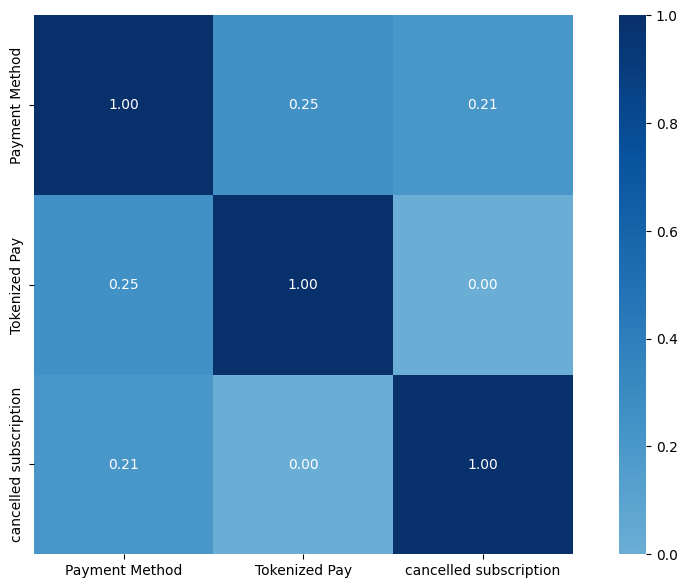

In [46]:
# Instantiate a figure and axis object
fig, ax = plt.subplots(figsize = (12, 7))
# Estimate and generate Cramer's V association plot
cramers_v_plot = associations(add_payment_method_success[event_attrs + ["cancelled subscription"]],
                 nom_nom_assoc = 'cramer', nominal_columns="all",
                 ax = ax,
                 cmap = "Blues")

<h2 style="color:green">Payment Method is weakly correlated with cancelled subscription</h2>
<br></br>


Payment Method
Credit                0.1845743779203203
PayPal                0.15573919952695825
Debit                 0.11159049905125017
Venmo                 0.052858991208717704


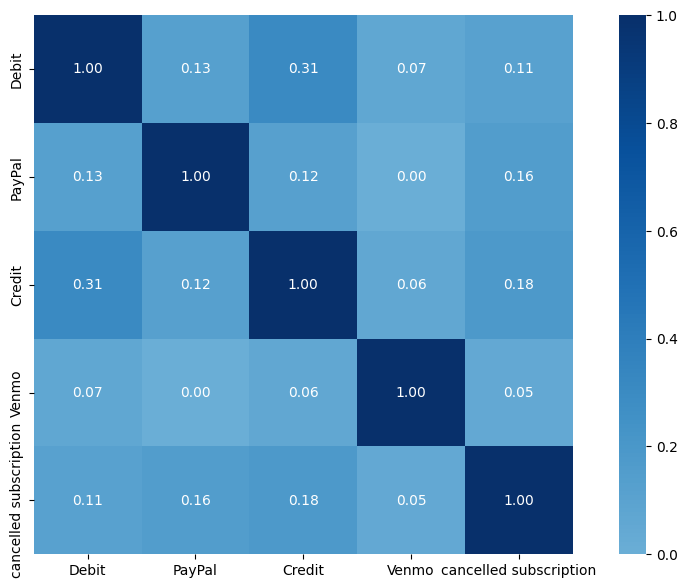


Tokenized Pay
Missing               0.07728257540972937
Google Pay            0.0484182128066382
Apple Pay             0.04447553222691828


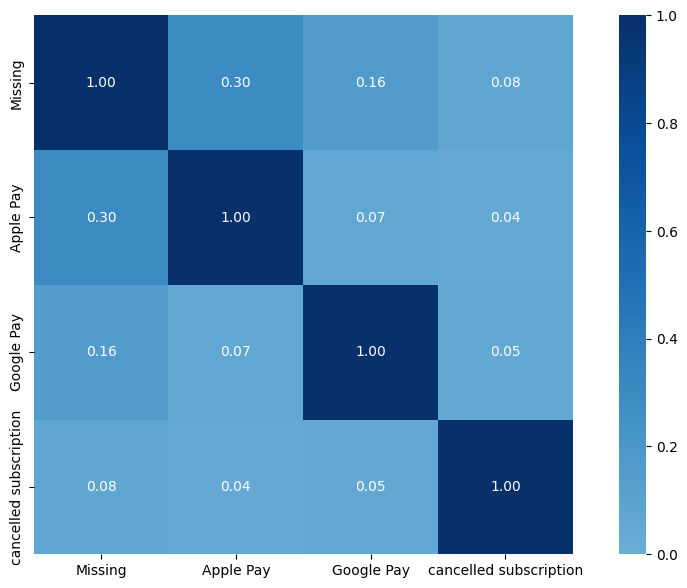

In [47]:
# iterate through unique values of all event's parameters
for col in add_payment_method_success.columns.values[2:]:
    d = add_payment_method_success.groupby("userid")[["cancelled subscription"] + [col]]
    cancel_statuses = []
    new_features = []
    count_new_features = len(add_payment_method_success[col].unique())
    for i,j in d:
        new_features.append(dict(j[col].value_counts()))
        cancel_statuses.append(j["cancelled subscription"].unique()[0])
    # create temporary dataframe each column of which represent how many times user used certain value of event parameter     
    temp = pd.DataFrame(new_features).fillna(0)
    temp["cancelled subscription"] = cancel_statuses
    attr_values = temp.columns.values[:(count_new_features+1)]
    
    cramer_v_val_dict = {}
    for index in temp.columns.values[:count_new_features]:
        cramer_v_val_dict[index] = cramers_v(temp[index], temp["cancelled subscription"])
    cramer_v_val_dict_sorted = sorted(cramer_v_val_dict.items(), key = lambda x:x[1], reverse = True)
    print()
    print(col)
    for k,v in cramer_v_val_dict_sorted:
        print(k.ljust(21), v) 
        
    # Instantiate a figure and axis object
    fig, ax = plt.subplots(figsize = (12, 7))
    # Estimate and generate Cramer's V association plot
    cramers_v_plot = associations(temp,
                 nom_nom_assoc = 'cramer', nominal_columns="all",
                 ax = ax,
                 cmap = "Blues")

<h2 style="color:green"> Adding successfully Credit payment method has very weak positive corellation with cancelled subscription </h2>

<br></br>
### Event "Chat Conversation Started" (high degree corellation with cancelled subscription) has no parameters

In [48]:
df[df["event_name"] == "Chat Conversation Started"].event_attributes.unique()

array(['{}'], dtype=object)

### Event "Wallet Opened" (moderate degree corellation with cancelled subscription) has no parameters

In [49]:
df[df["event_name"] == "Wallet Opened"].event_attributes.unique()

array(['{}'], dtype=object)

<br></br>
<a id = "4.2"></a>
<h2>4.2 Correlation between parametrs of "Chat Conversation Opened" event and subscription cancellation</h2>

Again we want to create dataframe that consits of all transactions with event "Chat Conversation Opened". This dataframe will have new columns - parameters of event

In [50]:
#parse dictionary (event_attributes) to separate values
chat_conversation_open = df[df["event_name"] == "Chat Conversation Opened"]
converted_dict_by_event_attrs = chat_conversation_open.event_attributes.apply(lambda x : pd.Series(ast.literal_eval(x))).fillna(0) 

#concatinate dataframes vertically
chat_conversation_open = chat_conversation_open.join(converted_dict_by_event_attrs)
chat_conversation_open = chat_conversation_open.drop(chat_conversation_open.columns[1:8], axis=1)

chat_conversation_open['Transaction type'] = chat_conversation_open['Transaction type'].replace([0], "")
chat_conversation_open['Transaction Type'] = chat_conversation_open['Transaction Type'].replace([0], "")
chat_conversation_open['Transaction_Type'] = chat_conversation_open['Transaction Type'] + chat_conversation_open['Transaction type']
chat_conversation_open['Transaction_Type'] = chat_conversation_open['Transaction_Type'].replace("", "Missing")

chat_conversation_open = chat_conversation_open.drop(['Transaction type', 'Transaction Type'], axis=1)

event_attrs = list(chat_conversation_open.columns.values[2:])

chat_conversation_open.head()

,userid,cancelled subscription,From,Transaction_Type
37,017f4557810b3ba165d2959c17b916b6,0,Menu,Missing
40,017f4557810b3ba165d2959c17b916b6,0,Menu,Missing
41,017f4557810b3ba165d2959c17b916b6,0,Menu,Missing
42,017f4557810b3ba165d2959c17b916b6,0,Menu,Missing
43,017f4557810b3ba165d2959c17b916b6,0,Menu,Missing


Create histograms for distributions of event's parameters

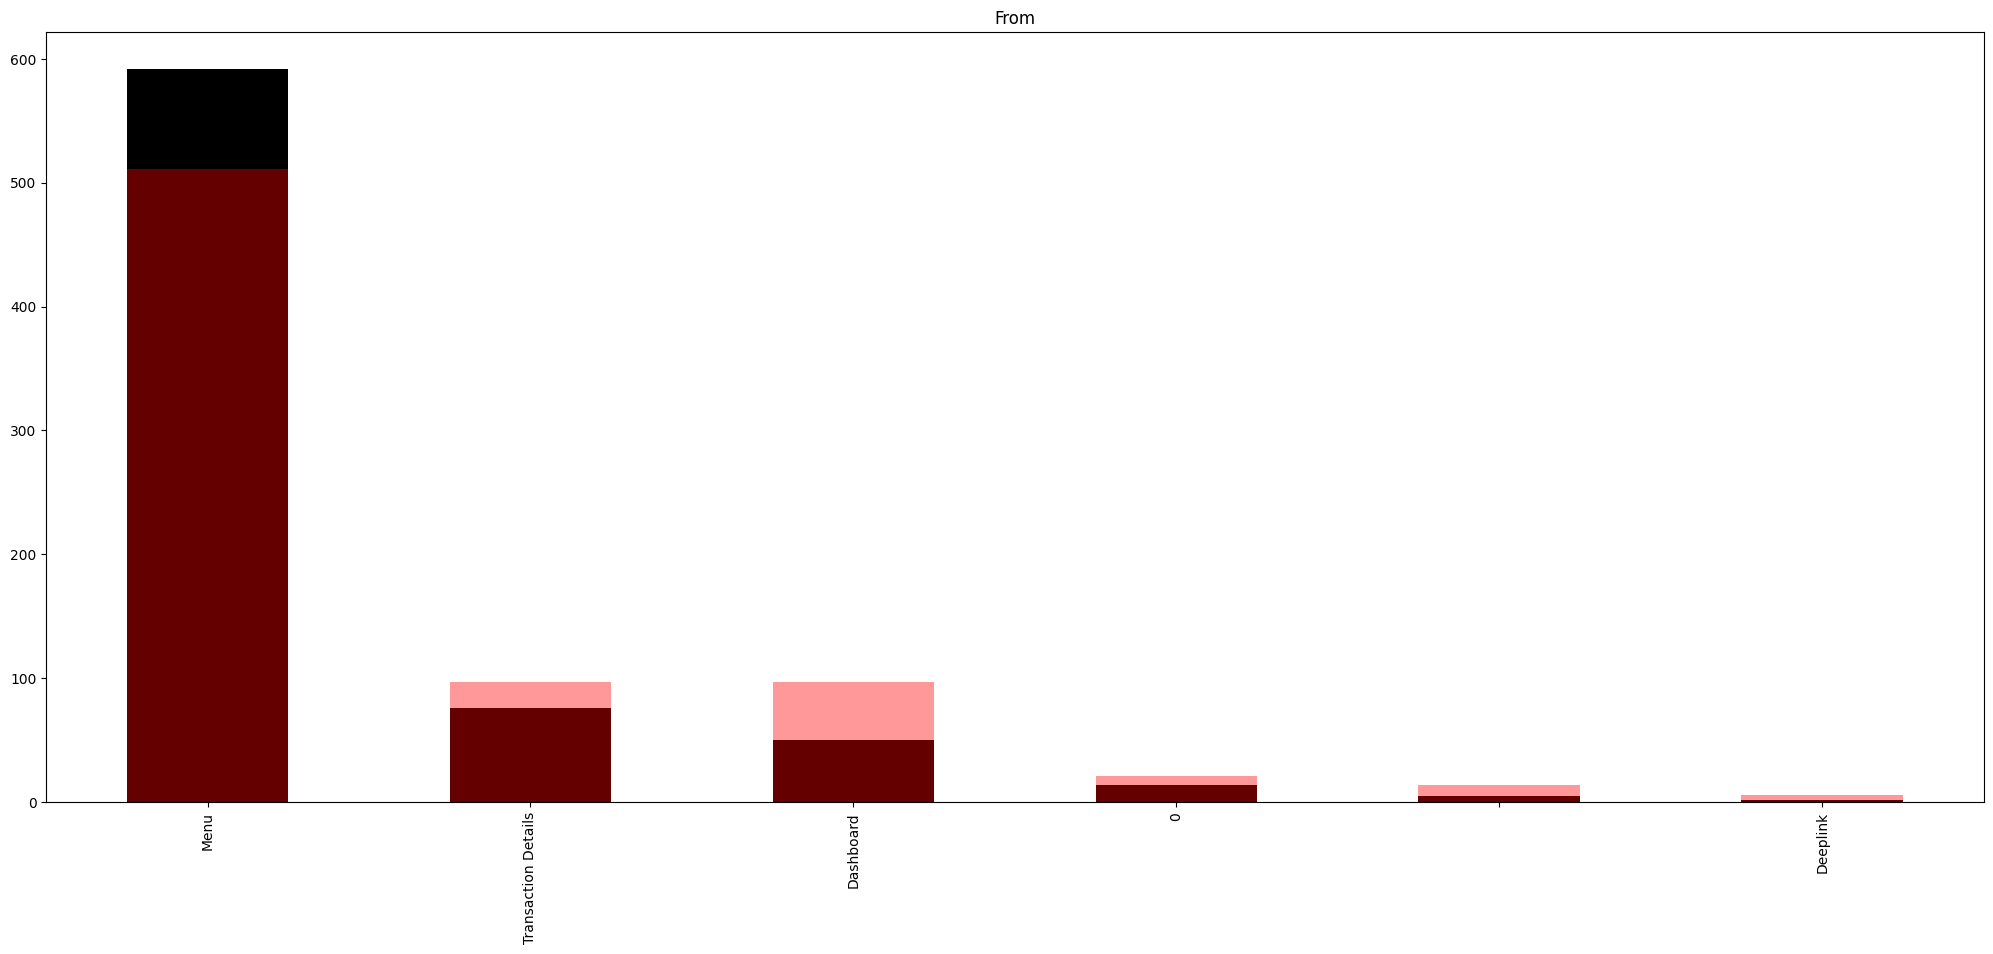

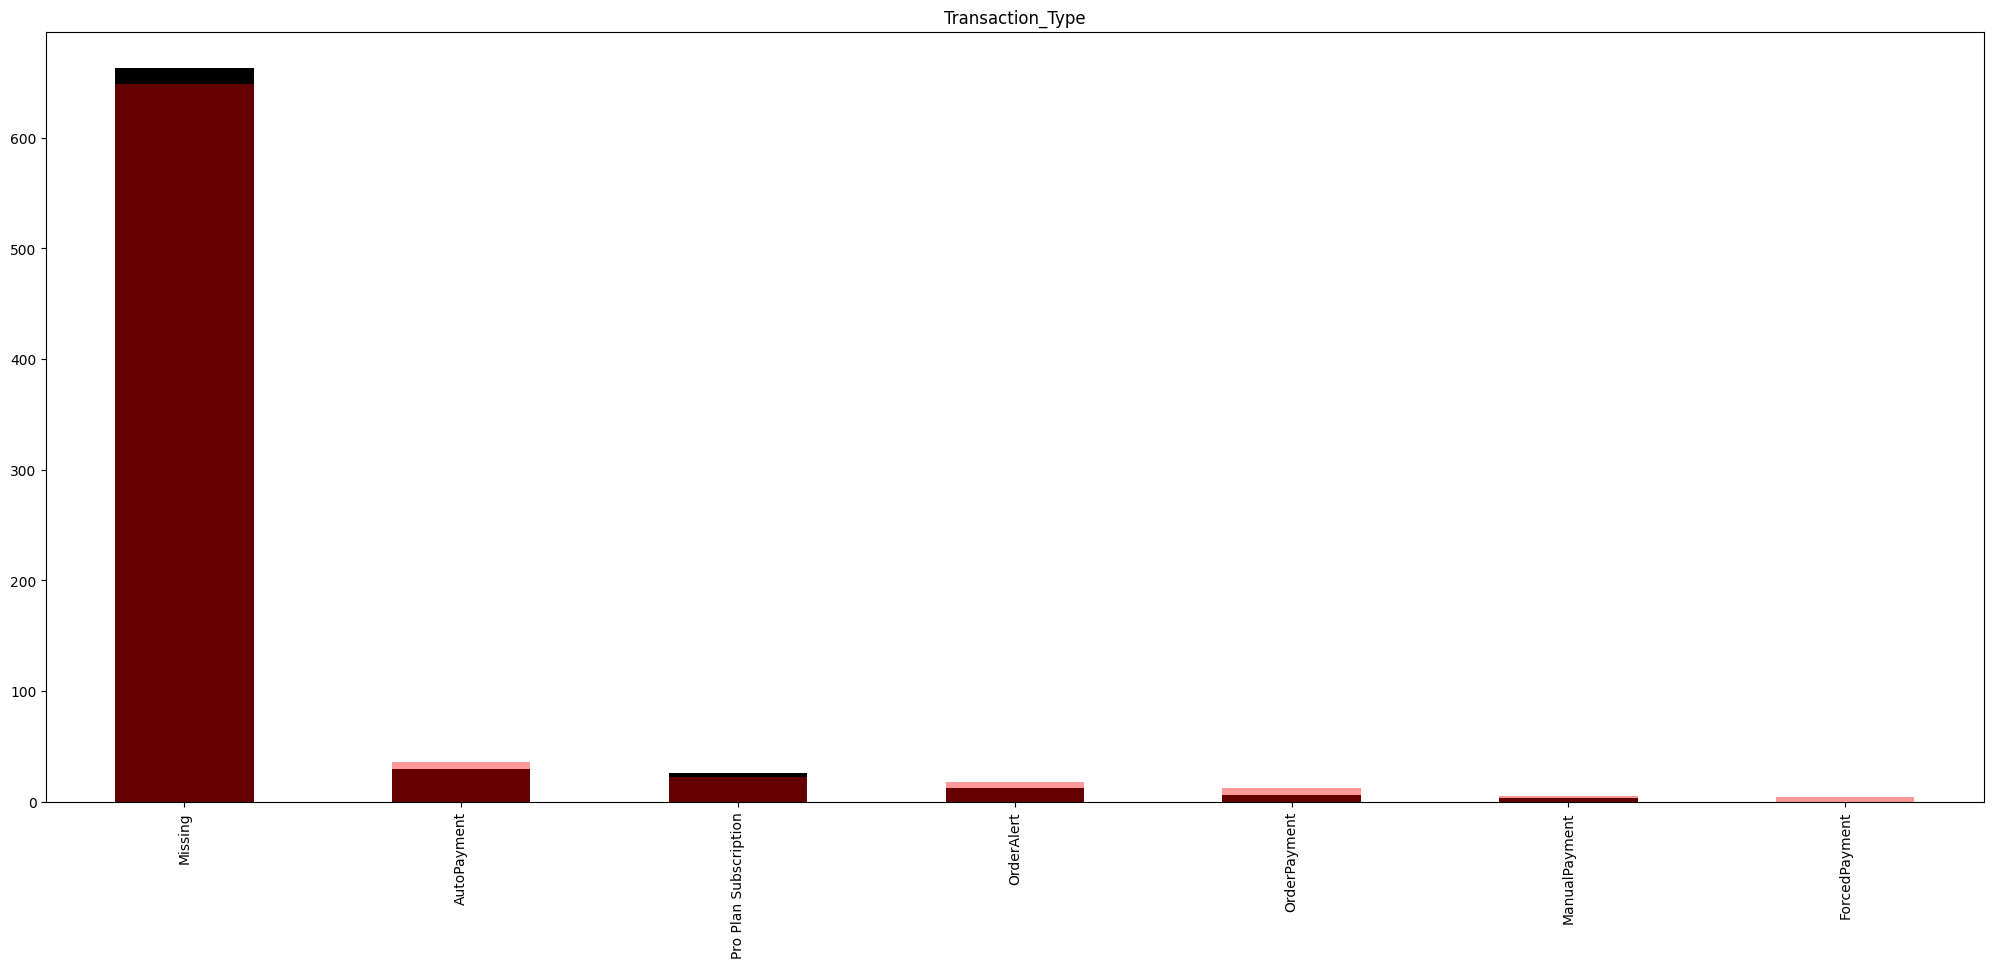

In [51]:
for i in chat_conversation_open.columns[2:]:
    fig, ax = plt.subplots(figsize=(25,10))
    chat_conversation_open[chat_conversation_open["cancelled subscription"] == 1][i].value_counts().head(25).plot.bar(ax=ax, title=i, color = "black")
    chat_conversation_open[chat_conversation_open["cancelled subscription"] == 0][i].value_counts().head(25).plot.bar(ax=ax, title=i, color = "red", alpha=0.4)
plt.show()

#### Next we will remain in each feature most common values according to histograms

In [52]:
chat_conversation_open["From"] = np.where(chat_conversation_open["From"].isin(chat_conversation_open["From"].value_counts()[:3].index),chat_conversation_open["From"],"Other")
chat_conversation_open["Transaction_Type"] = np.where(chat_conversation_open["Transaction_Type"].isin(chat_conversation_open["Transaction_Type"].value_counts()[:3].index),chat_conversation_open["Transaction_Type"],"Other")

Use SMOTE method to handle imbalanced data

In [53]:
sm = SMOTEN()
new_X, new_Y = sm.fit_resample(chat_conversation_open.drop("cancelled subscription", axis = 1), chat_conversation_open['cancelled subscription'])
chat_conversation_open = pd.concat([pd.DataFrame(new_Y), pd.DataFrame(new_X)], axis = 1)
chat_conversation_open.head()

,cancelled subscription,userid,From,Transaction_Type
0,0,017f4557810b3ba165d2959c17b916b6,Menu,Missing
1,0,017f4557810b3ba165d2959c17b916b6,Menu,Missing
2,0,017f4557810b3ba165d2959c17b916b6,Menu,Missing
3,0,017f4557810b3ba165d2959c17b916b6,Menu,Missing
4,0,017f4557810b3ba165d2959c17b916b6,Menu,Missing


In [54]:
cramer_v_val_dict = {}
for col in chat_conversation_open.columns[2:]:
    cramer_v_val_dict[col] = cramers_v(chat_conversation_open[col],chat_conversation_open["cancelled subscription"])

cramer_v_val_dict_sorted = sorted(cramer_v_val_dict.items(), key = lambda x:x[1], reverse = True)
for k,v in cramer_v_val_dict_sorted:
    print(k.ljust(21), v) 
events_attrs_coefs["Chat Conversation Opened"] = cramer_v_val_dict_sorted

From                  0.13486986276477664
Transaction_Type      0.05965484253142437


Correlation matrix using dython

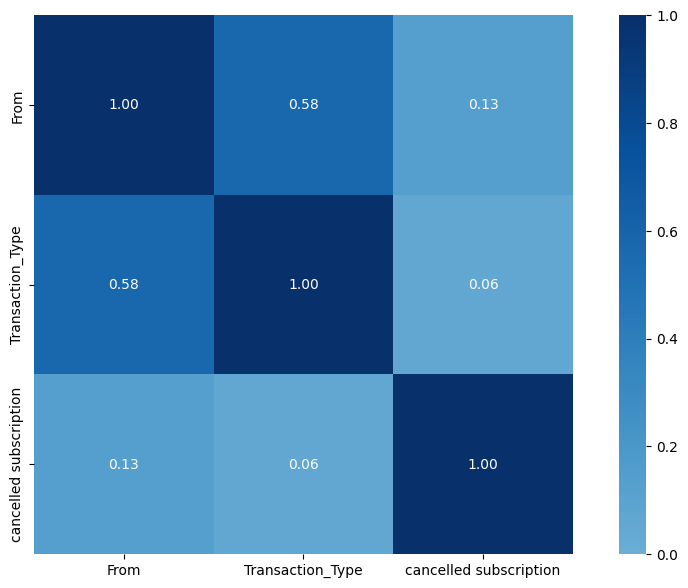

In [55]:
# Instantiate a figure and axis object
fig, ax = plt.subplots(figsize = (12, 7))
# Estimate and generate Cramer's V association plot
cramers_v_plot = associations(chat_conversation_open[event_attrs + ["cancelled subscription"]],
                 nom_nom_assoc = 'cramer', nominal_columns="all",
                 ax = ax,
                 cmap = "Blues")

<h2 style="color:green">Attribute "From" is very weakly correlated with cancelled subscription</h2>
<br></br>


From
Menu                  0.32280823697603944
Other                 0.09820611272479376
Dashboard             0.08586881673182503
Transaction Details   0.0


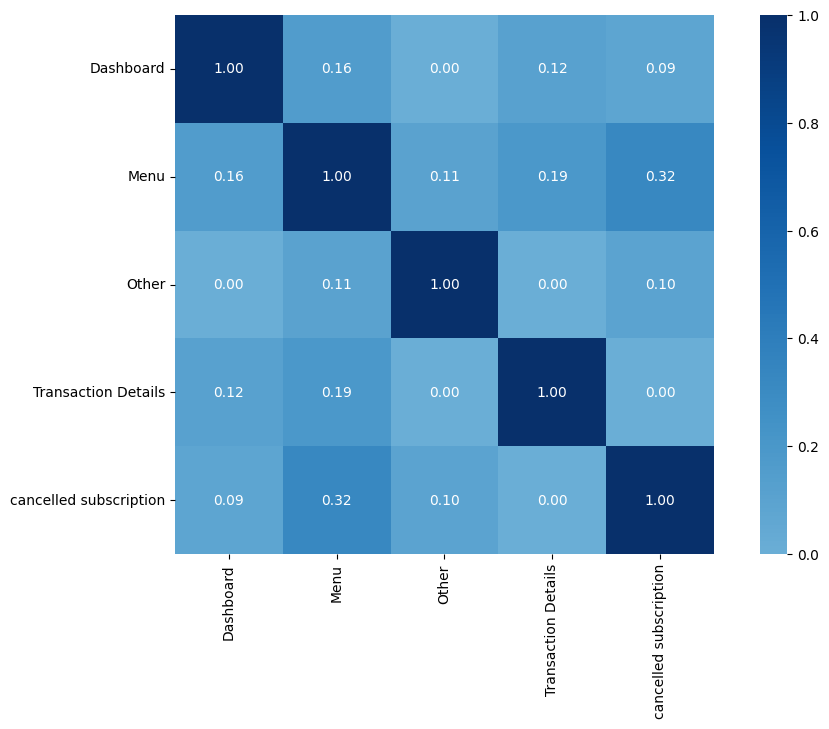


Transaction_Type
Missing               0.27503518134248056
Pro Plan Subscription 0.08822981174814619
Other                 0.0
AutoPayment           0.0


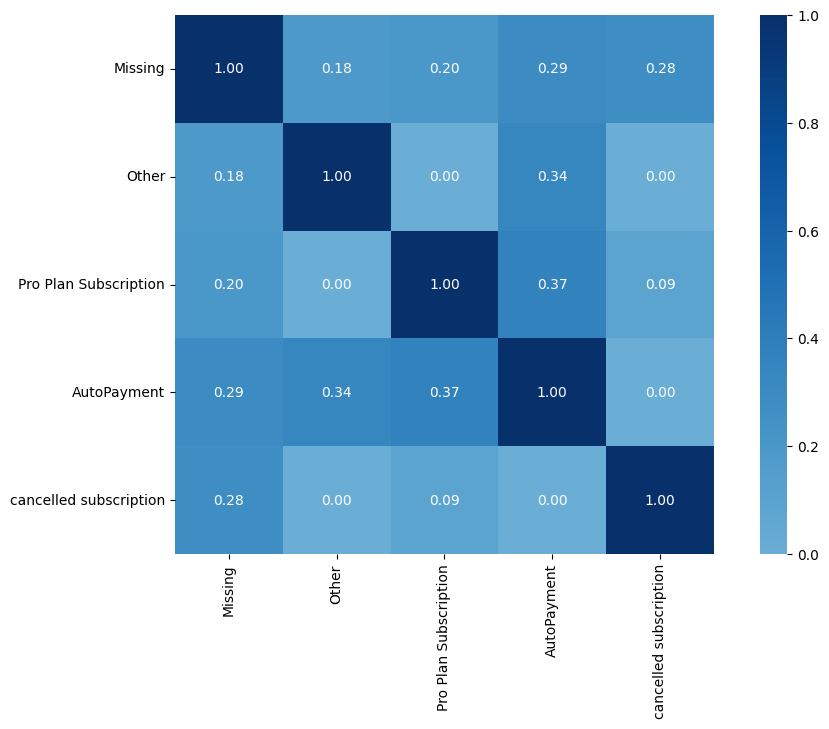

In [56]:
# iterate through unique values of all event's parameters
for col in chat_conversation_open.columns.values[2:]:
    d = chat_conversation_open.groupby("userid")[["cancelled subscription"] + [col]]
    cancel_statuses = []
    new_features = []
    count_new_features = len(chat_conversation_open[col].unique())
    for i,j in d:
        new_features.append(dict(j[col].value_counts()))
        cancel_statuses.append(j["cancelled subscription"].unique()[0])
        ids.append(i)
        
    # create temporary dataframe each column of which represent how many times
    # user used certain value of event parameter    
    
    temp = pd.DataFrame(new_features).fillna(0)
    temp["cancelled subscription"] = cancel_statuses
    attr_values = temp.columns.values[:(count_new_features+1)]
    
    cramer_v_val_dict = {}
    for index in temp.columns.values[:count_new_features]:
        cramer_v_val_dict[index] = cramers_v(temp[index], temp["cancelled subscription"])
    cramer_v_val_dict_sorted = sorted(cramer_v_val_dict.items(), key = lambda x:x[1], reverse = True)
    print()
    print(col)
    for k,v in cramer_v_val_dict_sorted:
        print(k.ljust(21), v)  
    # Instantiate a figure and axis object
    fig, ax = plt.subplots(figsize = (12, 7))
    # Estimate and generate Cramer's V association plot
    cramers_v_plot = associations(temp,
                 nom_nom_assoc = 'cramer', nominal_columns="all",
                 ax = ax,
                 cmap = "Blues")

<h2 style="color:green">Chat conversation opened from Menu has moderate corellation with cancelled subscription </h2>
<h2 style="color:green">Missing (empty) transaction type for opened chat conversation has weak corellation with cancelled subscription </h2>

<br></br>
<a id = "4.3"></a>
<h2>4.3 Correlation between parametrs of "Subscription Premium" event and subscription cancellation </h2>

Again we want to create dataframe that consits of all transactions with event "Subscription Premium". This dataframe will have new columns - parameters of event

In [57]:
subscribe_premium = df[df["event_name"] == "Subscription Premium"]
converted_dict_by_event_attrs = subscribe_premium.event_attributes.apply(lambda x : pd.Series(ast.literal_eval(x))).fillna(0) 

subscribe_premium = subscribe_premium.join(converted_dict_by_event_attrs)
subscribe_premium = subscribe_premium.drop(subscribe_premium.columns[1:8], axis=1)

subscribe_premium.head()

,userid,cancelled subscription,Start Date,Renewal Date,Membership Type
34,017f4557810b3ba165d2959c17b916b6,0,2022-01-16,2022-02-17,Monthly
85,c67290d72ec2974aba0f3975c1773405,0,2022-01-16,2022-02-17,Monthly
119,2467ce8593dd0efe1ce5d4b82263bc5c,0,2022-01-15,2022-02-16,Monthly
138,a22abda7a39d747ab674cd13224b375a,1,2022-01-15,2022-02-16,Monthly
153,67f7ee21393060f86207711face96b90,0,2022-01-17,2022-02-18,Monthly


### Also we want to add 2 new features for this event. It's month when person start premium subscription and month of renewal

In [58]:
from datetime import datetime

month_start = [datetime.strptime(i, '%Y-%m-%d').strftime("%B") for i in subscribe_premium["Start Date"]]
month_renewal = [datetime.strptime(i, '%Y-%m-%d').strftime("%B") for i in subscribe_premium["Renewal Date"]]
subscribe_premium["Start Month"] = month_start
subscribe_premium["Renewal Month"] = month_renewal

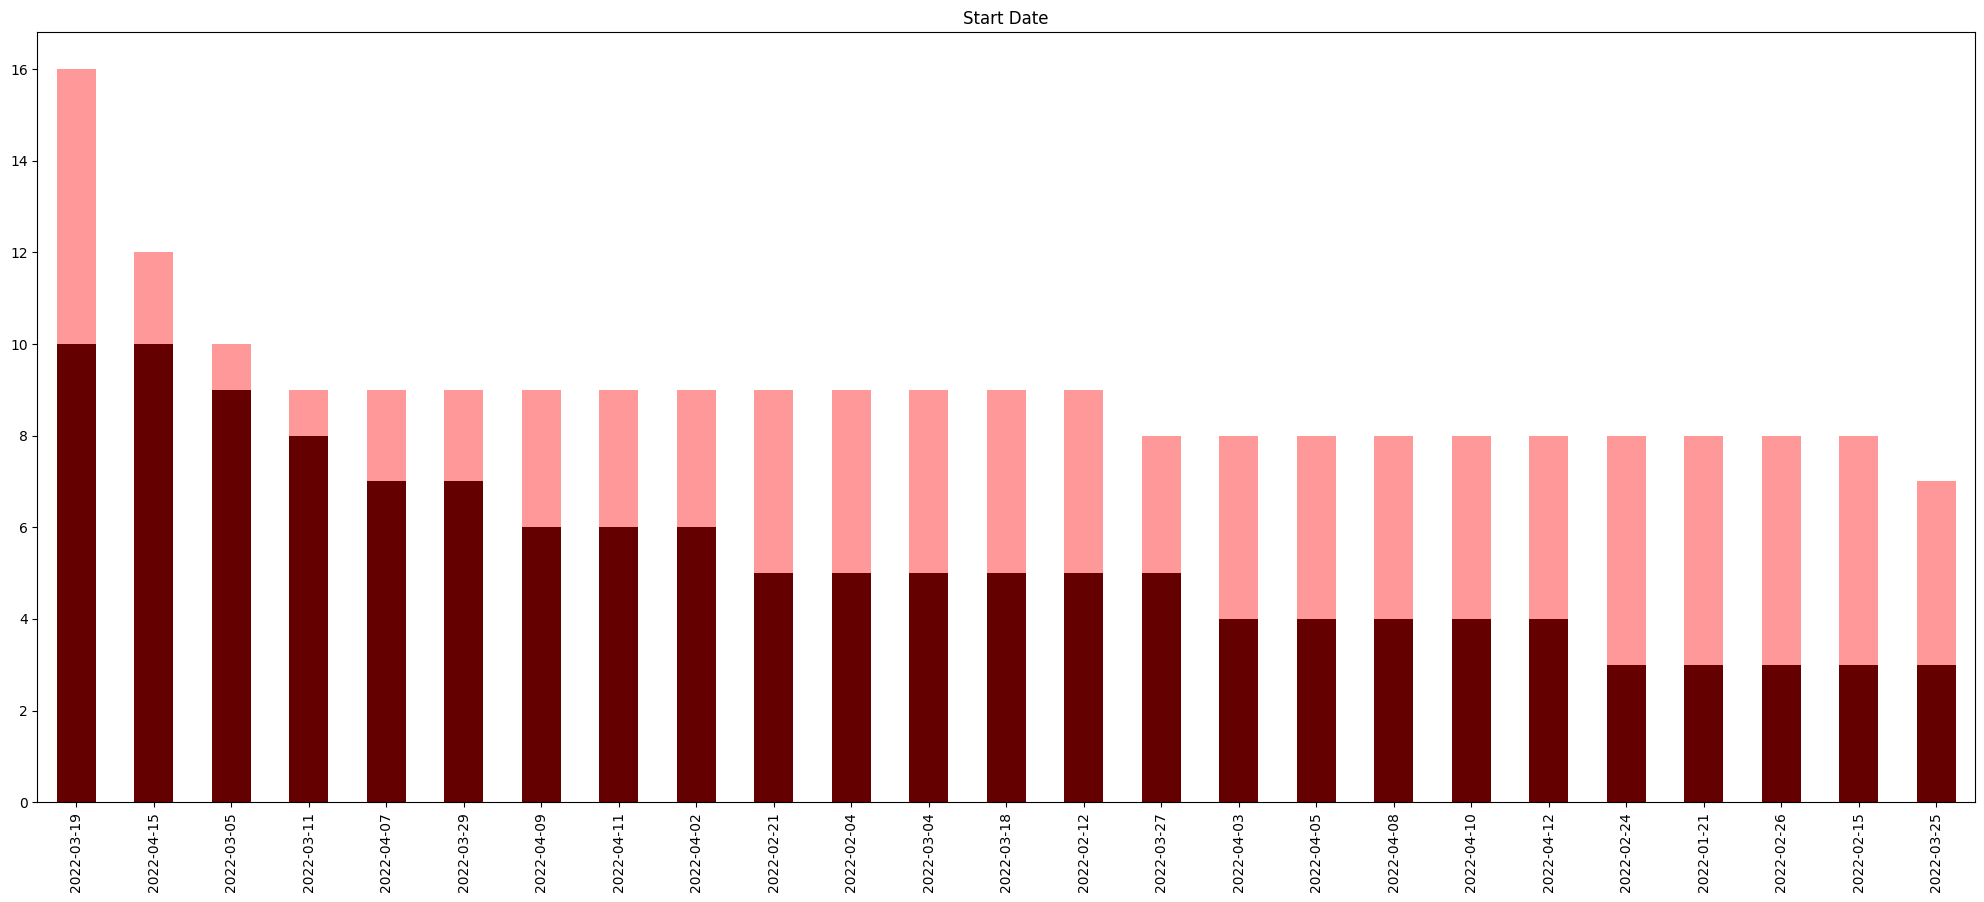

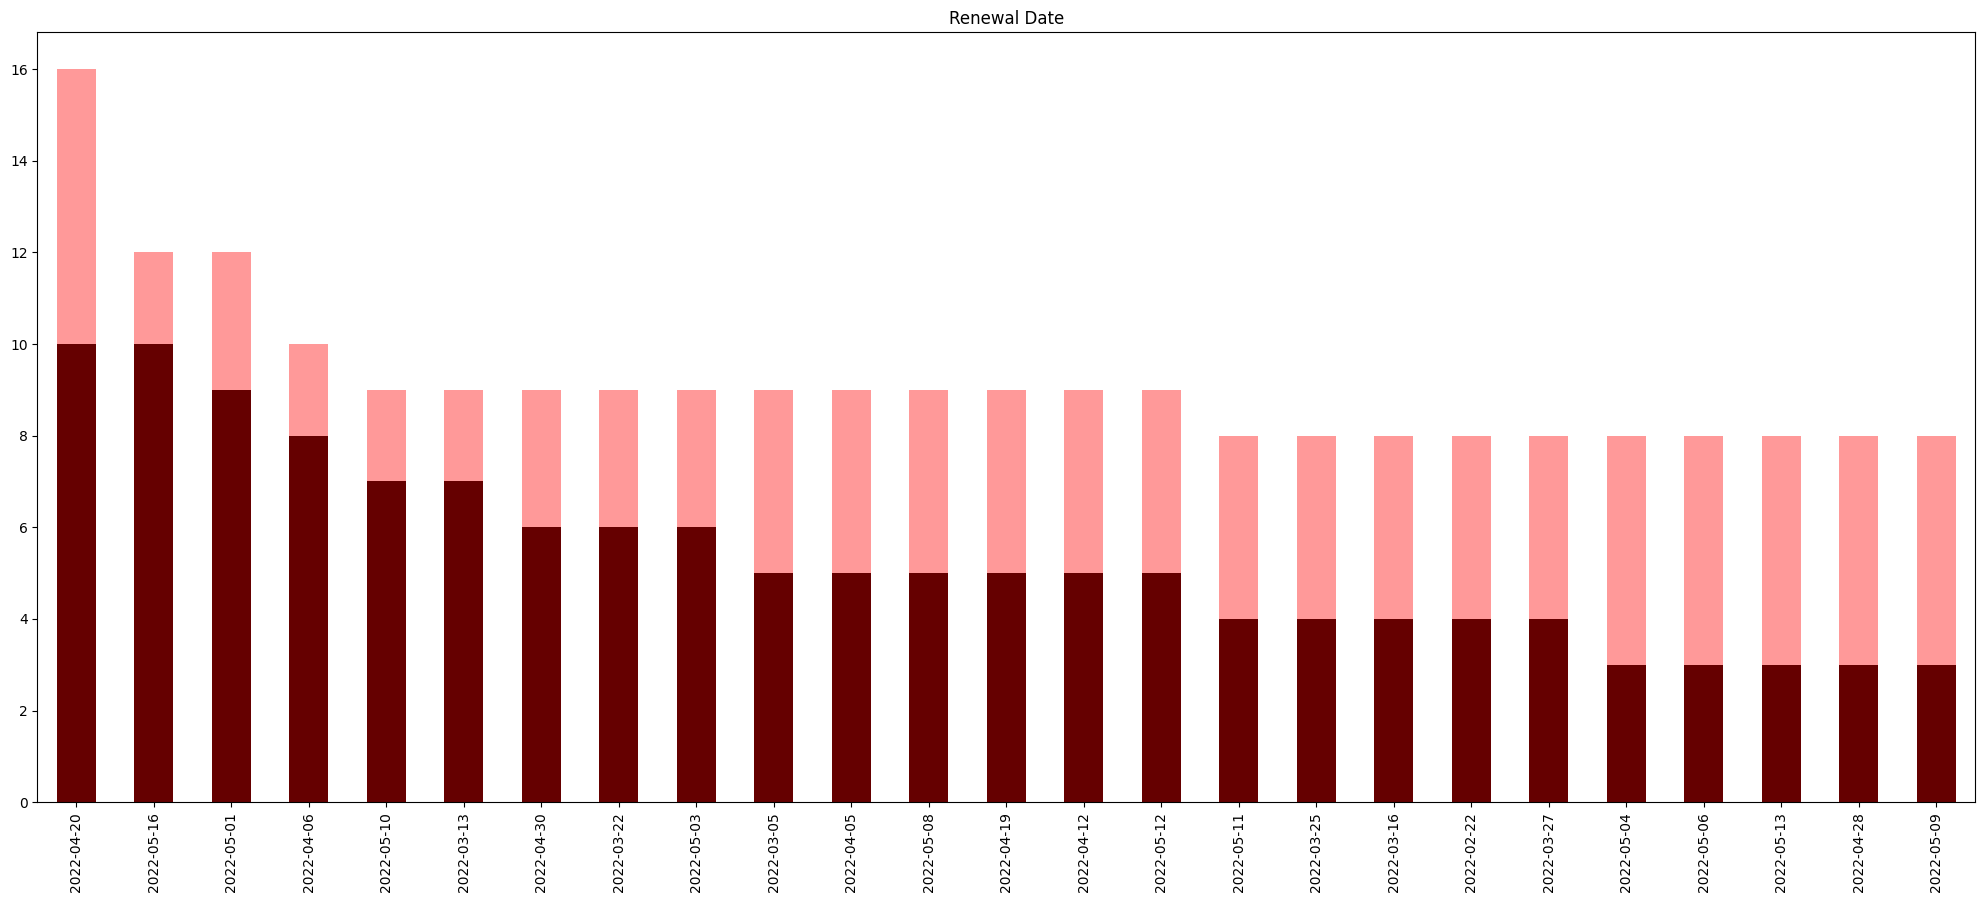

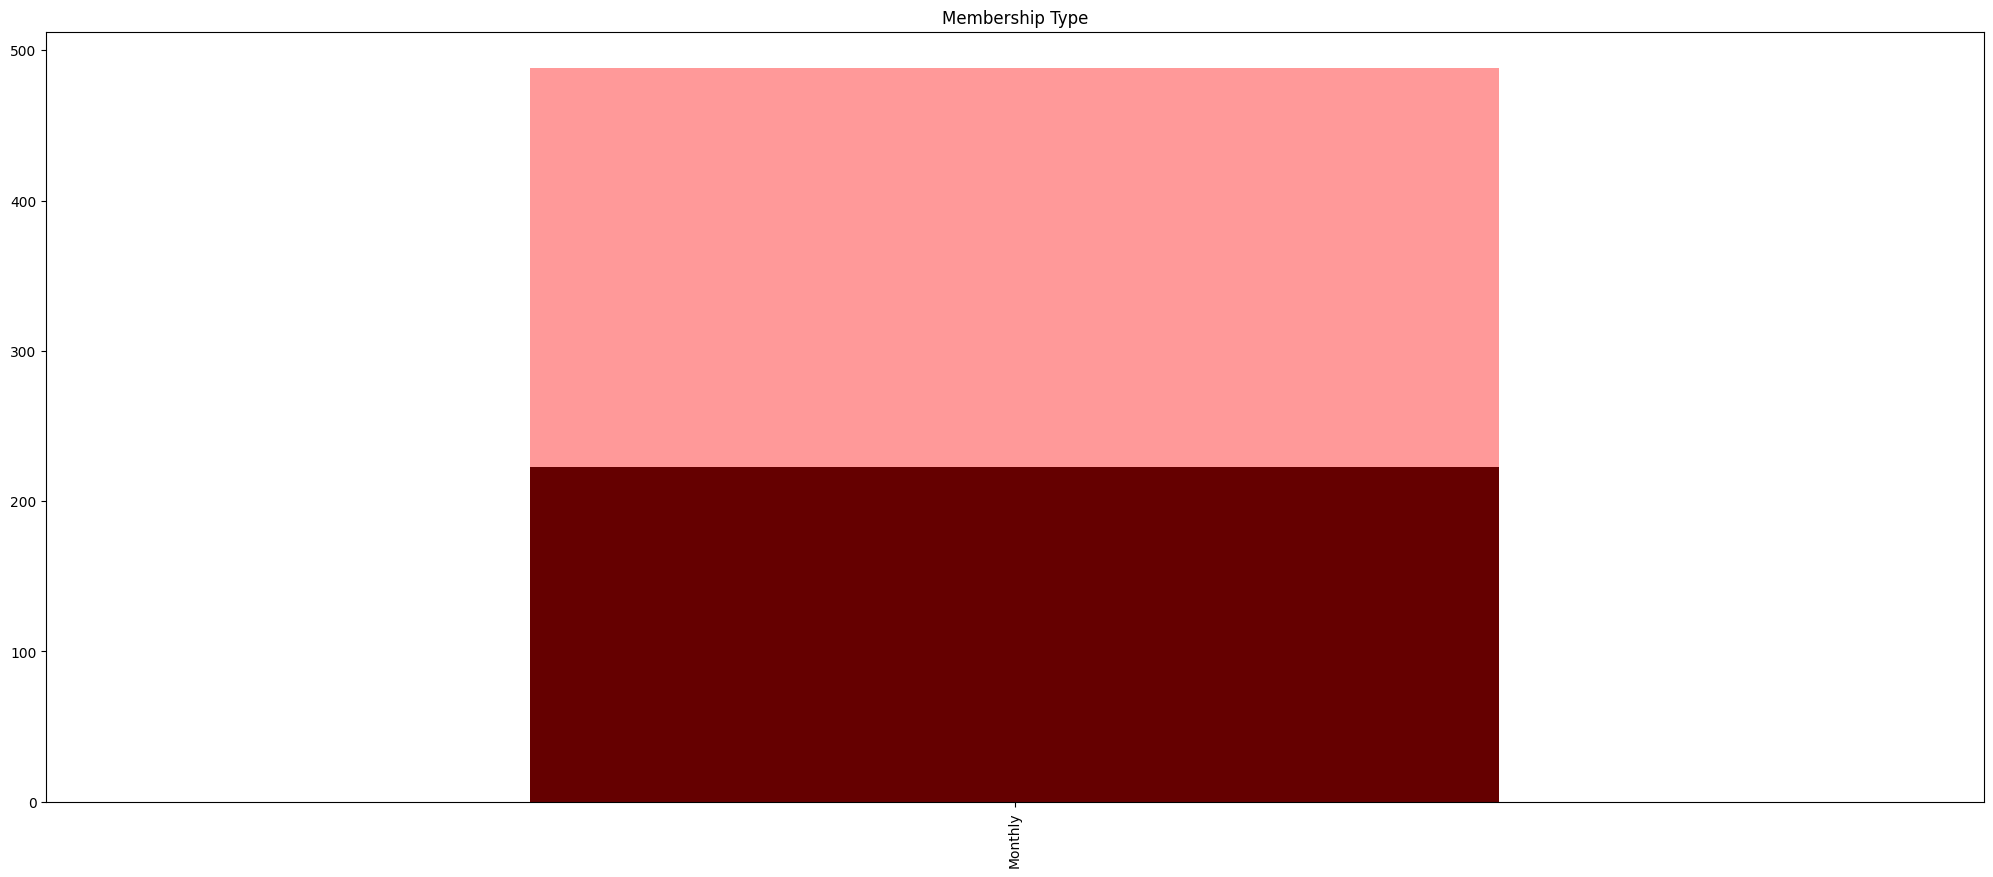

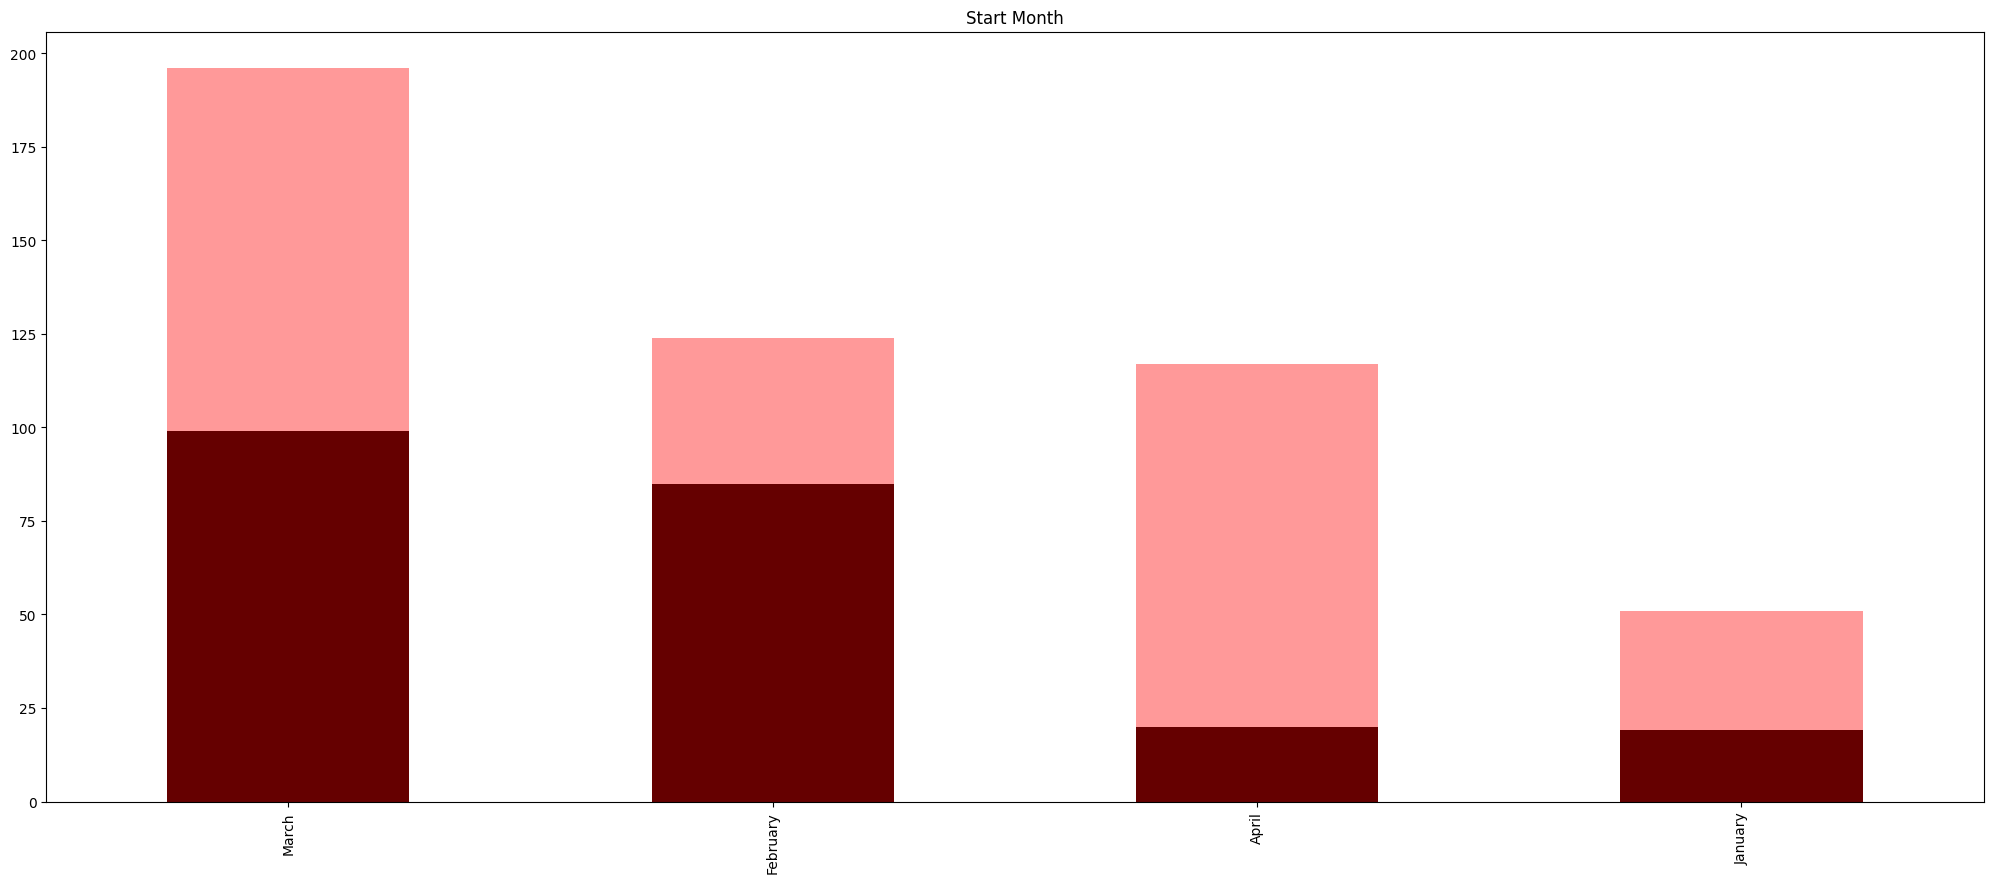

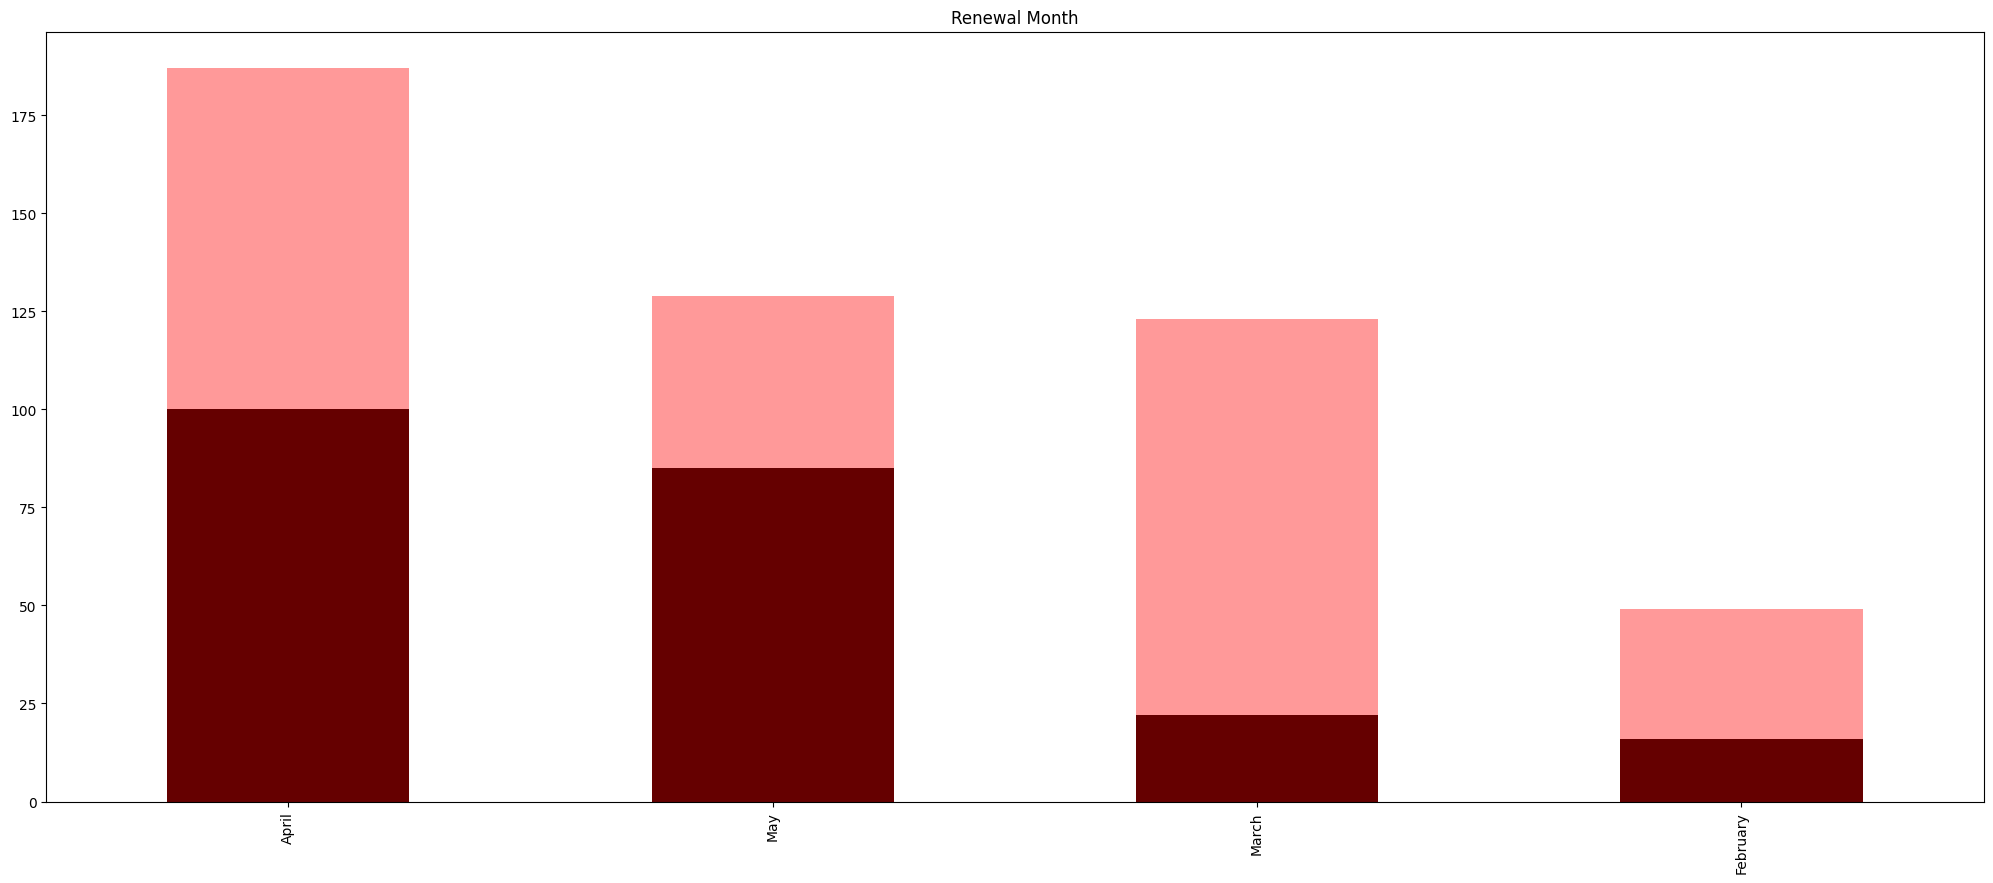

In [59]:
for i in subscribe_premium.columns[2:]:
    fig, ax = plt.subplots(figsize=(25,10))
    subscribe_premium[subscribe_premium["cancelled subscription"] == 1][i].value_counts().head(25).plot.bar(ax=ax, title=i, color = "black")
    subscribe_premium[subscribe_premium["cancelled subscription"] == 0][i].value_counts().head(25).plot.bar(ax=ax, title=i, color = "red", alpha=0.4)
plt.show()

As Membership Type has one unique value, it can be removed.

In [60]:
subscribe_premium = subscribe_premium.drop("Membership Type", axis=1)
event_attrs = list(subscribe_premium.columns.values[2:])

Use SMOTE method to handle imbalanced data

In [61]:
sm = SMOTEN()
new_X, new_Y = sm.fit_resample(subscribe_premium.drop("cancelled subscription", axis = 1), subscribe_premium['cancelled subscription'])
subscribe_premium = pd.concat([pd.DataFrame(new_Y), pd.DataFrame(new_X)], axis = 1)
subscribe_premium.head()

,cancelled subscription,userid,Start Date,Renewal Date,Start Month,Renewal Month
0,0,017f4557810b3ba165d2959c17b916b6,2022-01-16,2022-02-17,January,February
1,0,c67290d72ec2974aba0f3975c1773405,2022-01-16,2022-02-17,January,February
2,0,2467ce8593dd0efe1ce5d4b82263bc5c,2022-01-15,2022-02-16,January,February
3,1,a22abda7a39d747ab674cd13224b375a,2022-01-15,2022-02-16,January,February
4,0,67f7ee21393060f86207711face96b90,2022-01-17,2022-02-18,January,February


In [62]:
cramer_v_val_dict = {}
for col in subscribe_premium.columns[2:]:
    cramer_v_val_dict[col] = cramers_v(subscribe_premium[col],subscribe_premium["cancelled subscription"])

cramer_v_val_dict_sorted = sorted(cramer_v_val_dict.items(), key = lambda x:x[1], reverse = True)
for k,v in cramer_v_val_dict_sorted:
    print(k.ljust(21), v) 
    
events_attrs_coefs["Subscription Premium"] = cramer_v_val_dict_sorted       

Start Date            0.4440823140372708
Renewal Date          0.4364389804386105
Renewal Month         0.23587098682301985
Start Month           0.21784999034449384


Correlation matrix using dython

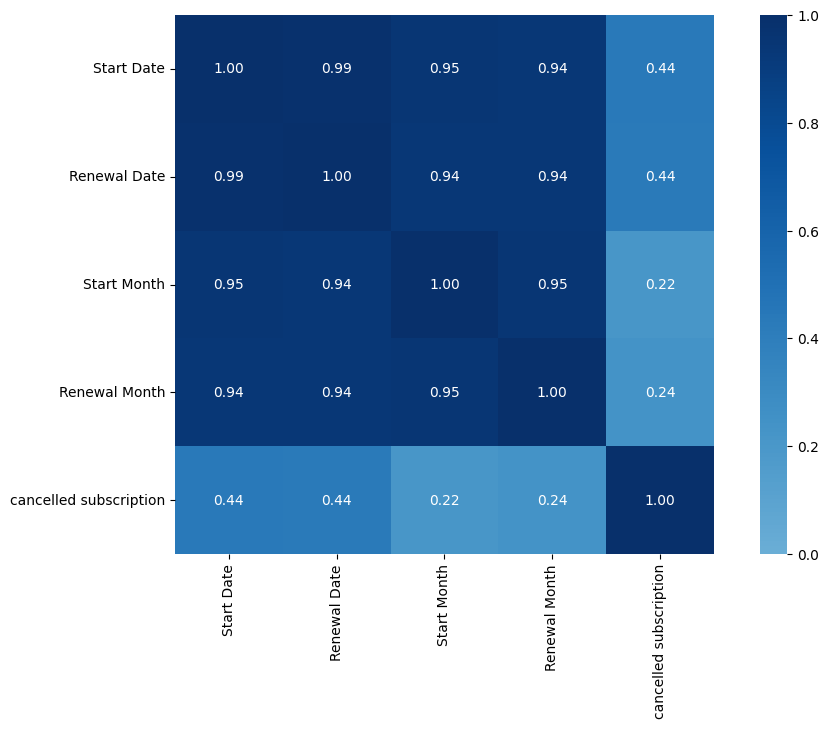

In [63]:
# Instantiate a figure and axis object
fig, ax = plt.subplots(figsize = (12, 7))
# Estimate and generate Cramer's V association plot
cramers_v_plot = associations(subscribe_premium[event_attrs + ["cancelled subscription"]],
                 nom_nom_assoc = 'cramer', nominal_columns="all",
                 ax = ax,
                 cmap = "Blues")

<h2 style="color:green"> Attributes "Start Date" and "Renewal Date"  are moderately correlated with cancelled subscription </h2>
<h2 style="color:green"> Attribute "Start Month" and "Renewal Month" are weakly correlated with cancelled subscription </h2>
<br></br>


Start Month
April                 0.2124757650825955
February              0.19666936635920593
March                 0.16906577032676642
January               0.09588863676421427


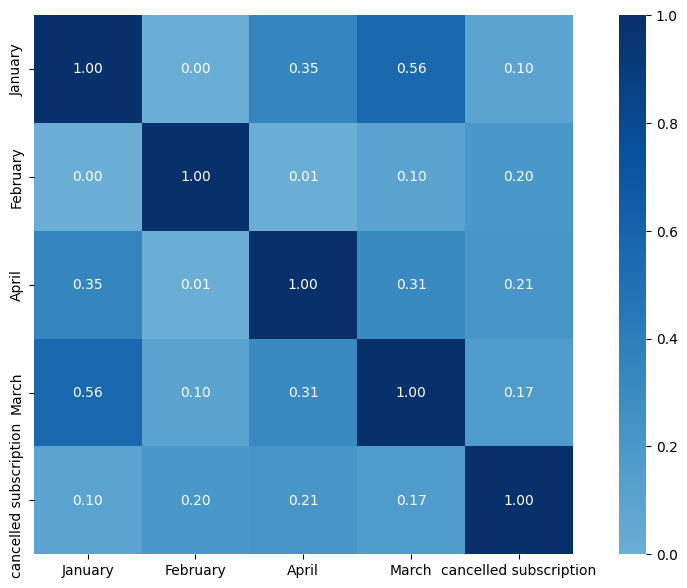


Renewal Month
May                   0.22188182924078725
March                 0.1902429731763863
April                 0.1802288833273936
February              0.0979524237545735


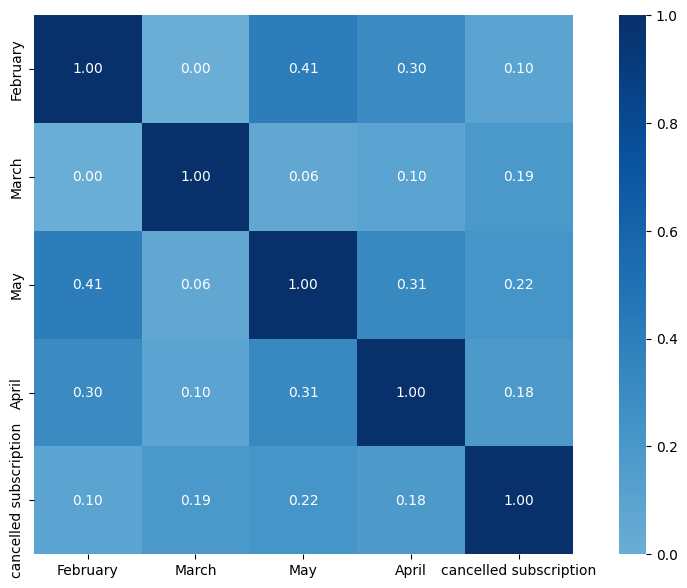

In [64]:
# iterate through unique values of all event parameters
for col in subscribe_premium.columns.values[4:]:
    d = subscribe_premium.groupby("userid")[["cancelled subscription"] + [col]]
    cancel_statuses = []
    new_features = []
    count_new_features = len(subscribe_premium[col].unique())
    for i,j in d:
        new_features.append(dict(j[col].value_counts()))
        cancel_statuses.append(j["cancelled subscription"].unique()[0])
        ids.append(i)
        
    # create temporary dataframe each column of which represent how many times
    # user used certain value of event parameter    
    
    temp = pd.DataFrame(new_features).fillna(0)
    temp["cancelled subscription"] = cancel_statuses
    attr_values = temp.columns.values[:(count_new_features+1)]
    
    cramer_v_val_dict = {}
    for index in temp.columns.values[:count_new_features]:
        cramer_v_val_dict[index] = cramers_v(temp[index], temp["cancelled subscription"])
    cramer_v_val_dict_sorted = sorted(cramer_v_val_dict.items(), key = lambda x:x[1], reverse = True)
    print()
    print(col)
    for k,v in cramer_v_val_dict_sorted:
        print(k.ljust(21), v)  
    # Instantiate a figure and axis object
    fig, ax = plt.subplots(figsize = (12, 7))
    # Estimate and generate Cramer's V association plot
    cramers_v_plot = associations(temp,
                 nom_nom_assoc = 'cramer', nominal_columns="all",
                 ax = ax,
                 cmap = "Blues")

<h2 style="color:green"> Starting premium subscription in April has weak positive corellation with cancelled subscription </h2>
<h2 style="color:green"> Respectively, renewal premium subscription in May has weak positive corellation with cancelled subscription </h2>

<br></br>
<a id = "4.4"></a>
<h2>4.4 Correlation between parametrs of "Add Vehicle Success" event and subscription cancellation</h2>

In [65]:
add_vehicle_success = df[df["event_name"] == "Add Vehicle Success"]
converted_dict_by_event_attrs = add_vehicle_success.event_attributes.apply(lambda x : pd.Series(ast.literal_eval(x))).fillna(0) 

add_vehicle_success = add_vehicle_success.join(converted_dict_by_event_attrs)
add_vehicle_success = add_vehicle_success.drop(add_vehicle_success.columns[1:8], axis=1)


add_vehicle_success['Rental state'] = add_vehicle_success['Rental state'].replace([0], "")
add_vehicle_success['Rental State'] = add_vehicle_success['Rental State'].replace([0], "")
add_vehicle_success['Rental_State'] = add_vehicle_success['Rental state'] + add_vehicle_success['Rental State']
add_vehicle_success['Rental_State'] = add_vehicle_success['Rental_State'].replace("", "Missing")
add_vehicle_success['Start Date'] = add_vehicle_success['Start Date'].replace([0, ""], "Missing")
add_vehicle_success['End Date'] = add_vehicle_success['End Date'].replace([0, ""], "Missing")

add_vehicle_success = add_vehicle_success.drop(['Rental state', 'Rental State'], axis=1)

add_vehicle_success.head()

,userid,cancelled subscription,Make,Model,Color,Year,Temporary,Start Date,End Date,Rental_State
0,c95c777785faec8dd910d019d7278ebe,0,Dodge,Caravan,White,2019,false,Missing,Missing,Missing
8,4d4f4f33c2fd7393093d9f535a92f784,0,Ford,F-150,Black,2017,false,Missing,Missing,Missing
10,d6da62f56ee3f76a9cc7f9be92de9253,0,Chevrolet,Malibu,White,2020,true,16/01/2022,18/01/2022,CA
12,86963a8dd513a1f38f9f6bd867b45033,0,Toyota,Camry,Black,2012,false,Missing,Missing,Missing
14,5b5ee48d9887d347ce297bc14c395f7a,0,Honda,HR-V,Black,2021,true,16/01/2022,17/01/2022,CA


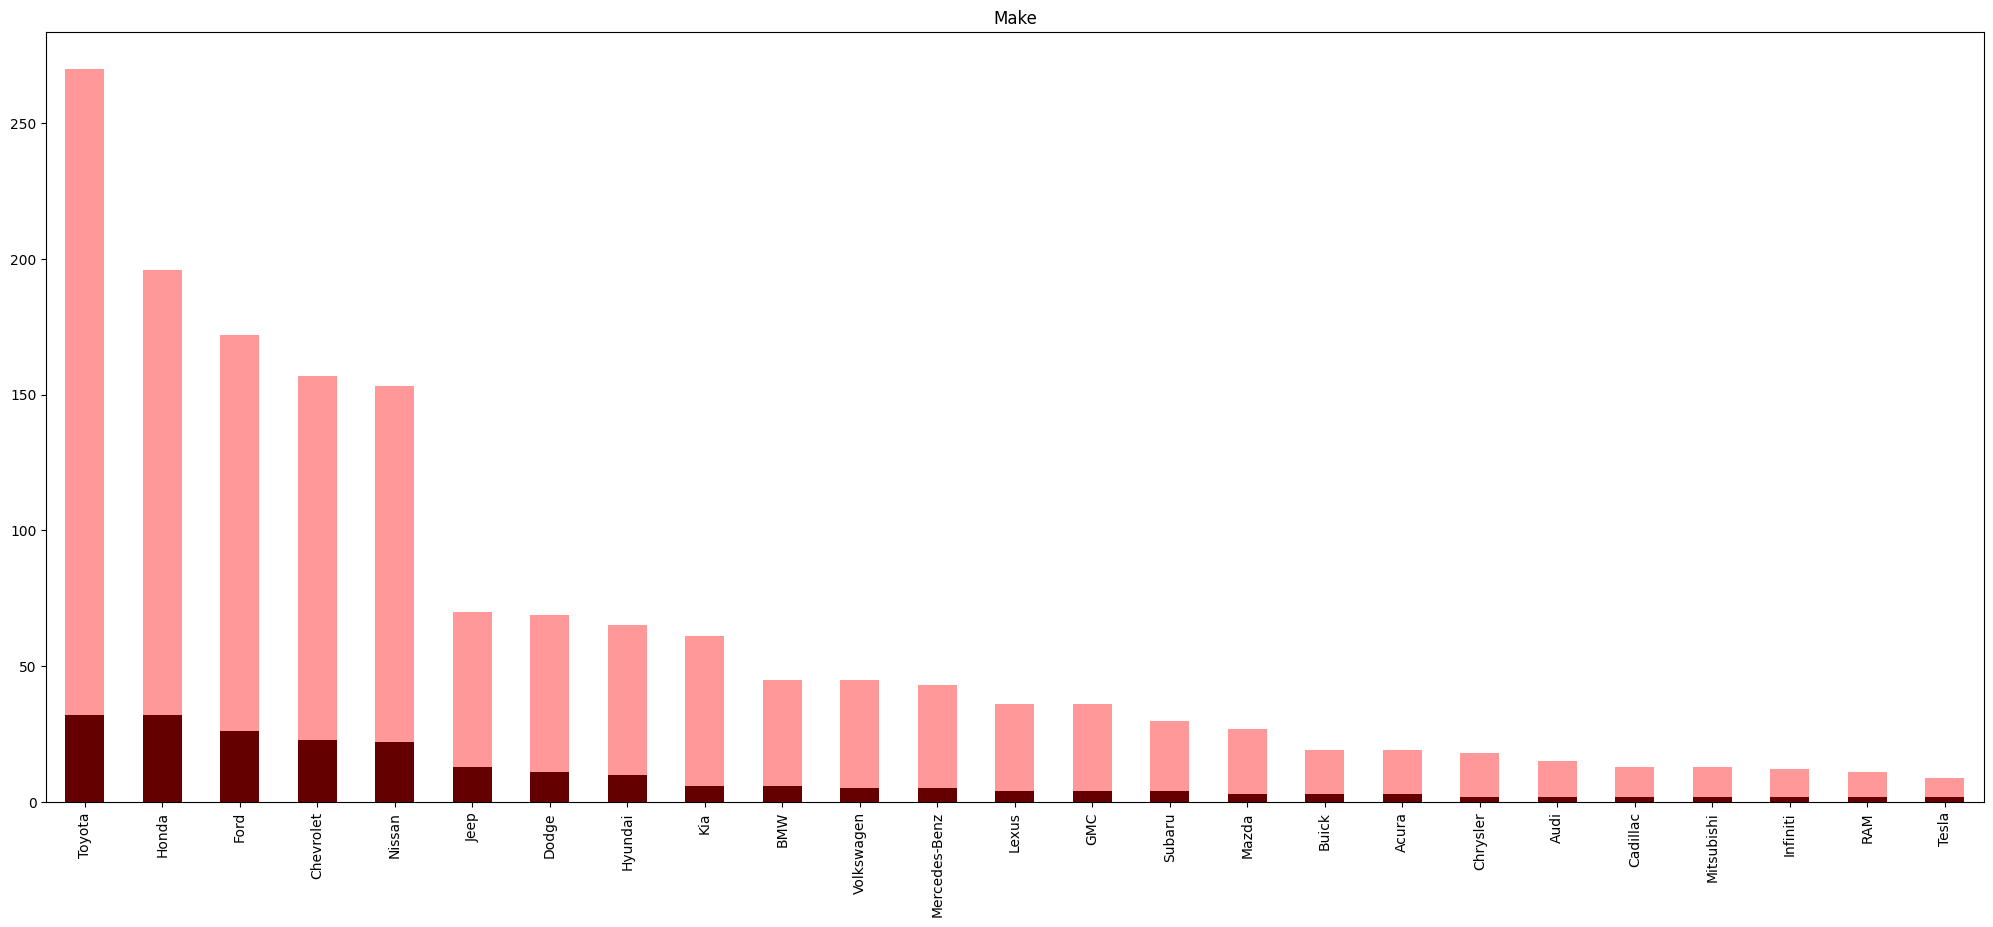

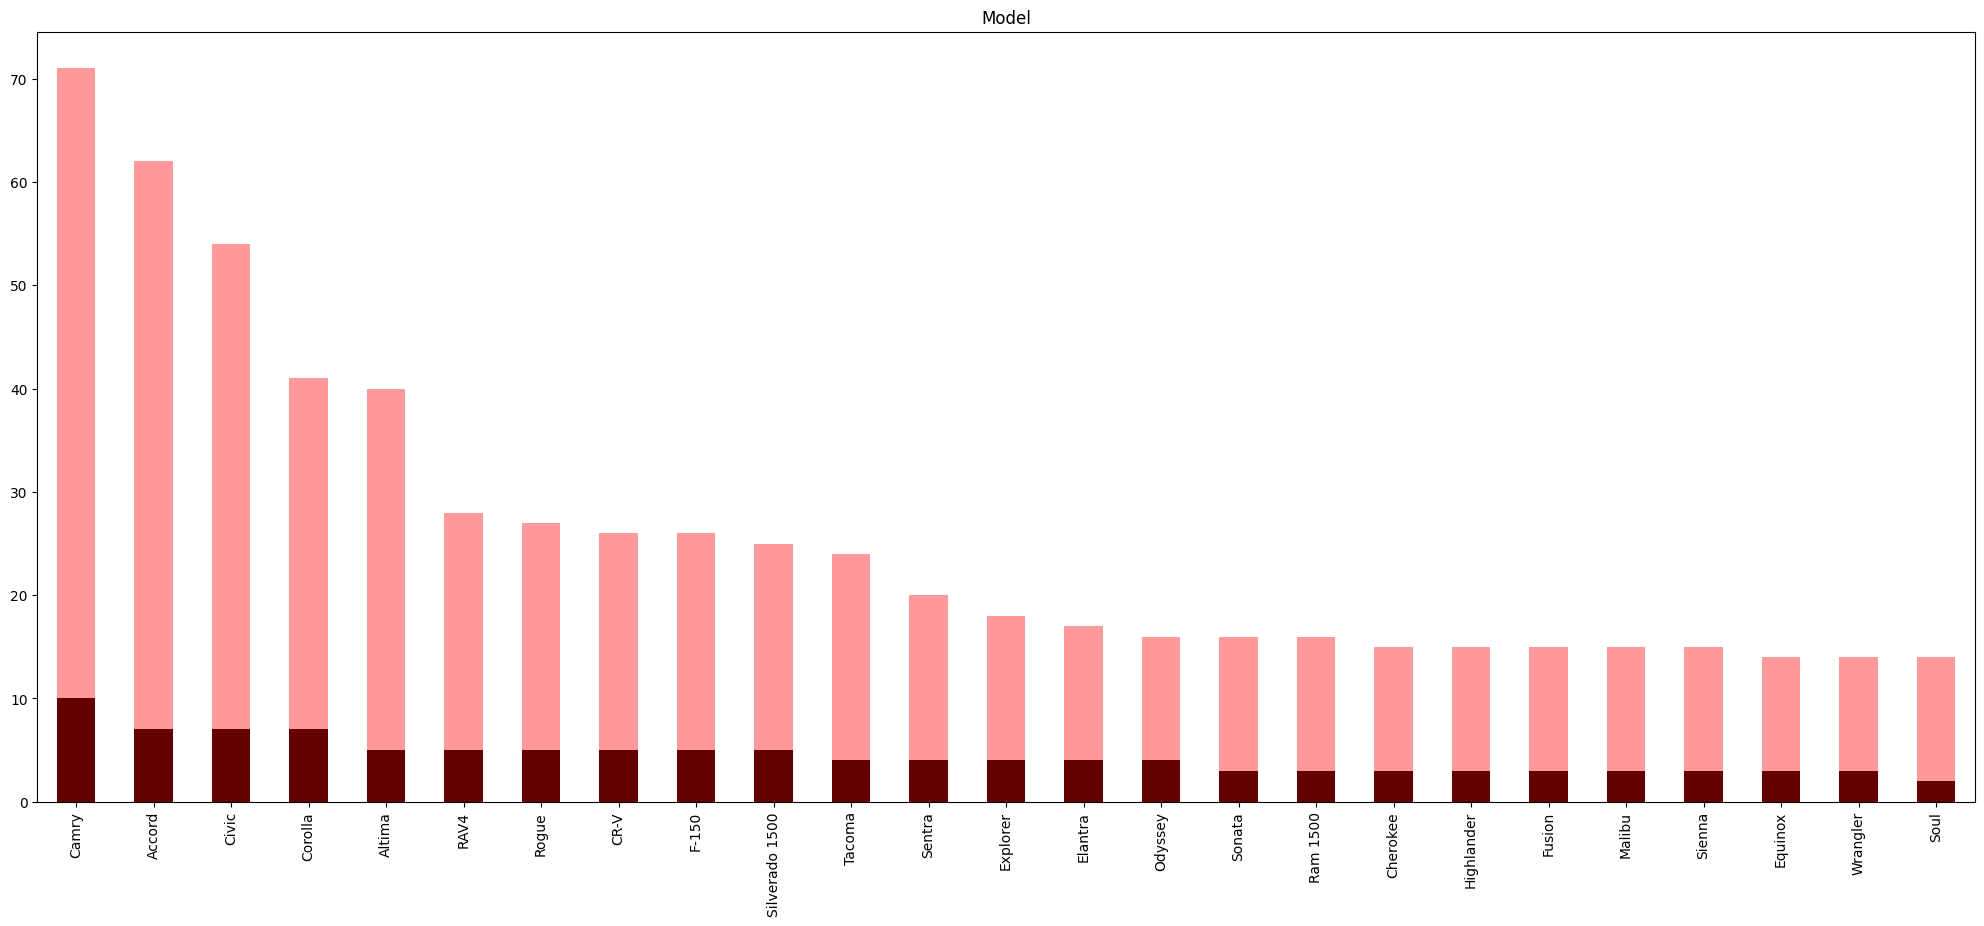

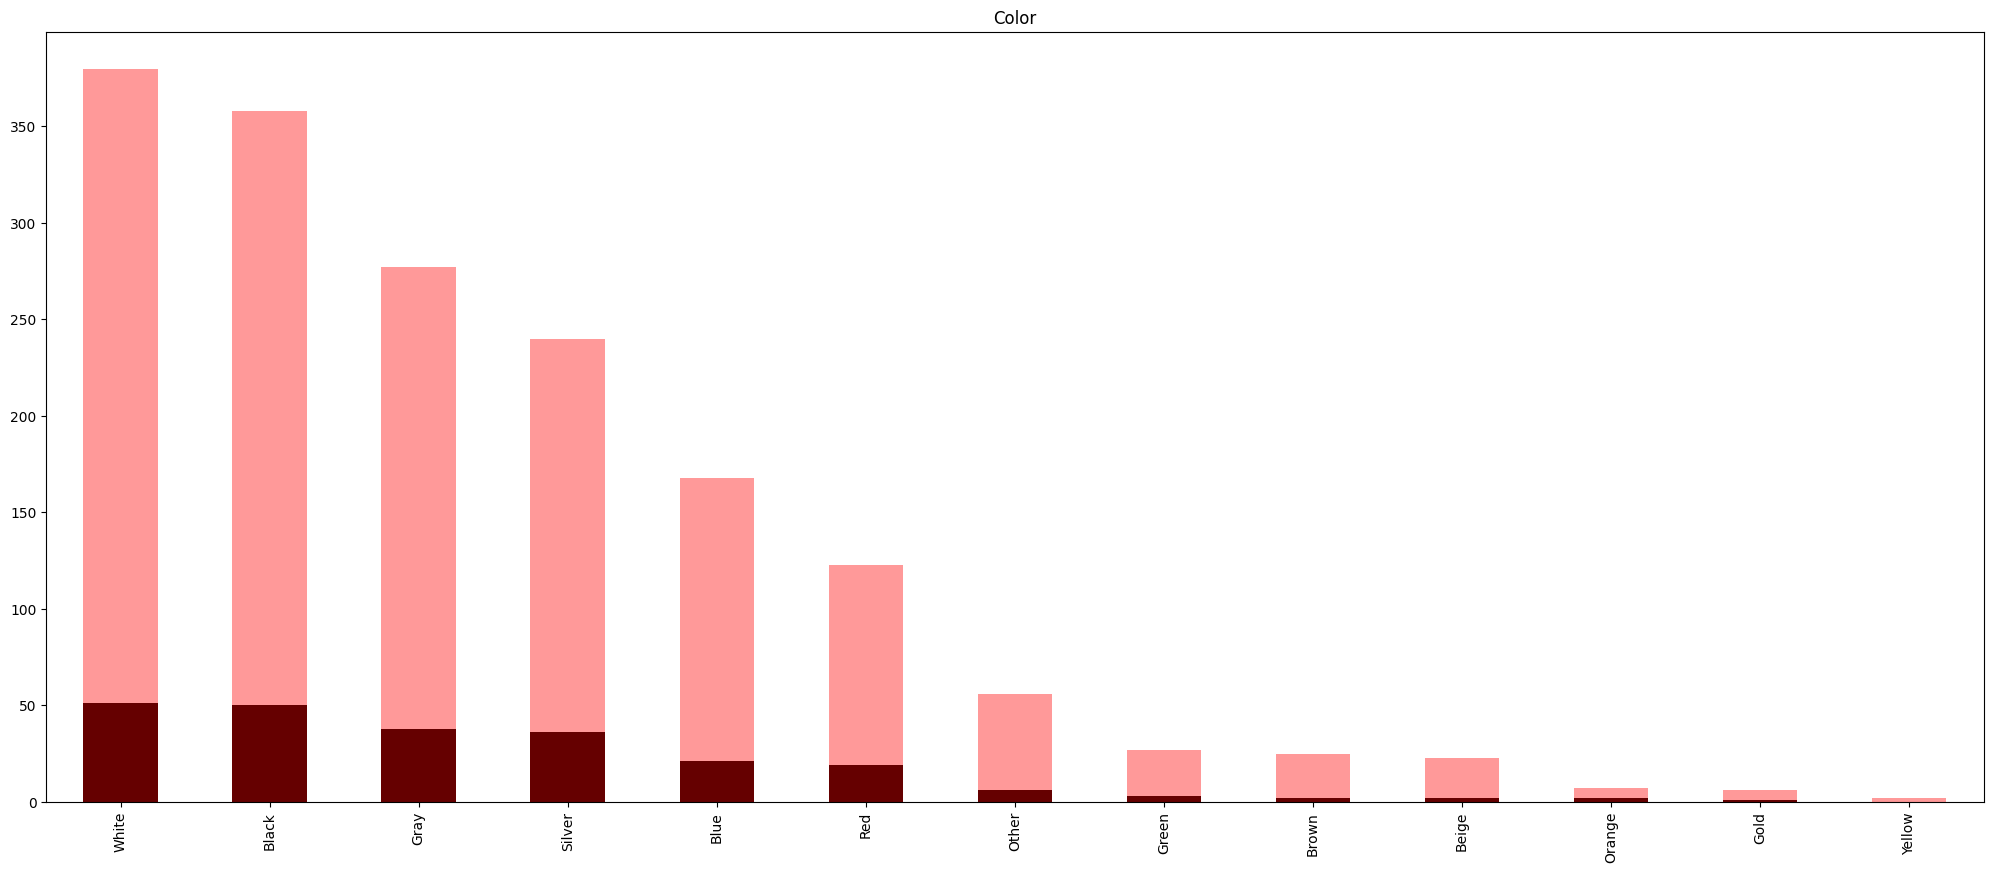

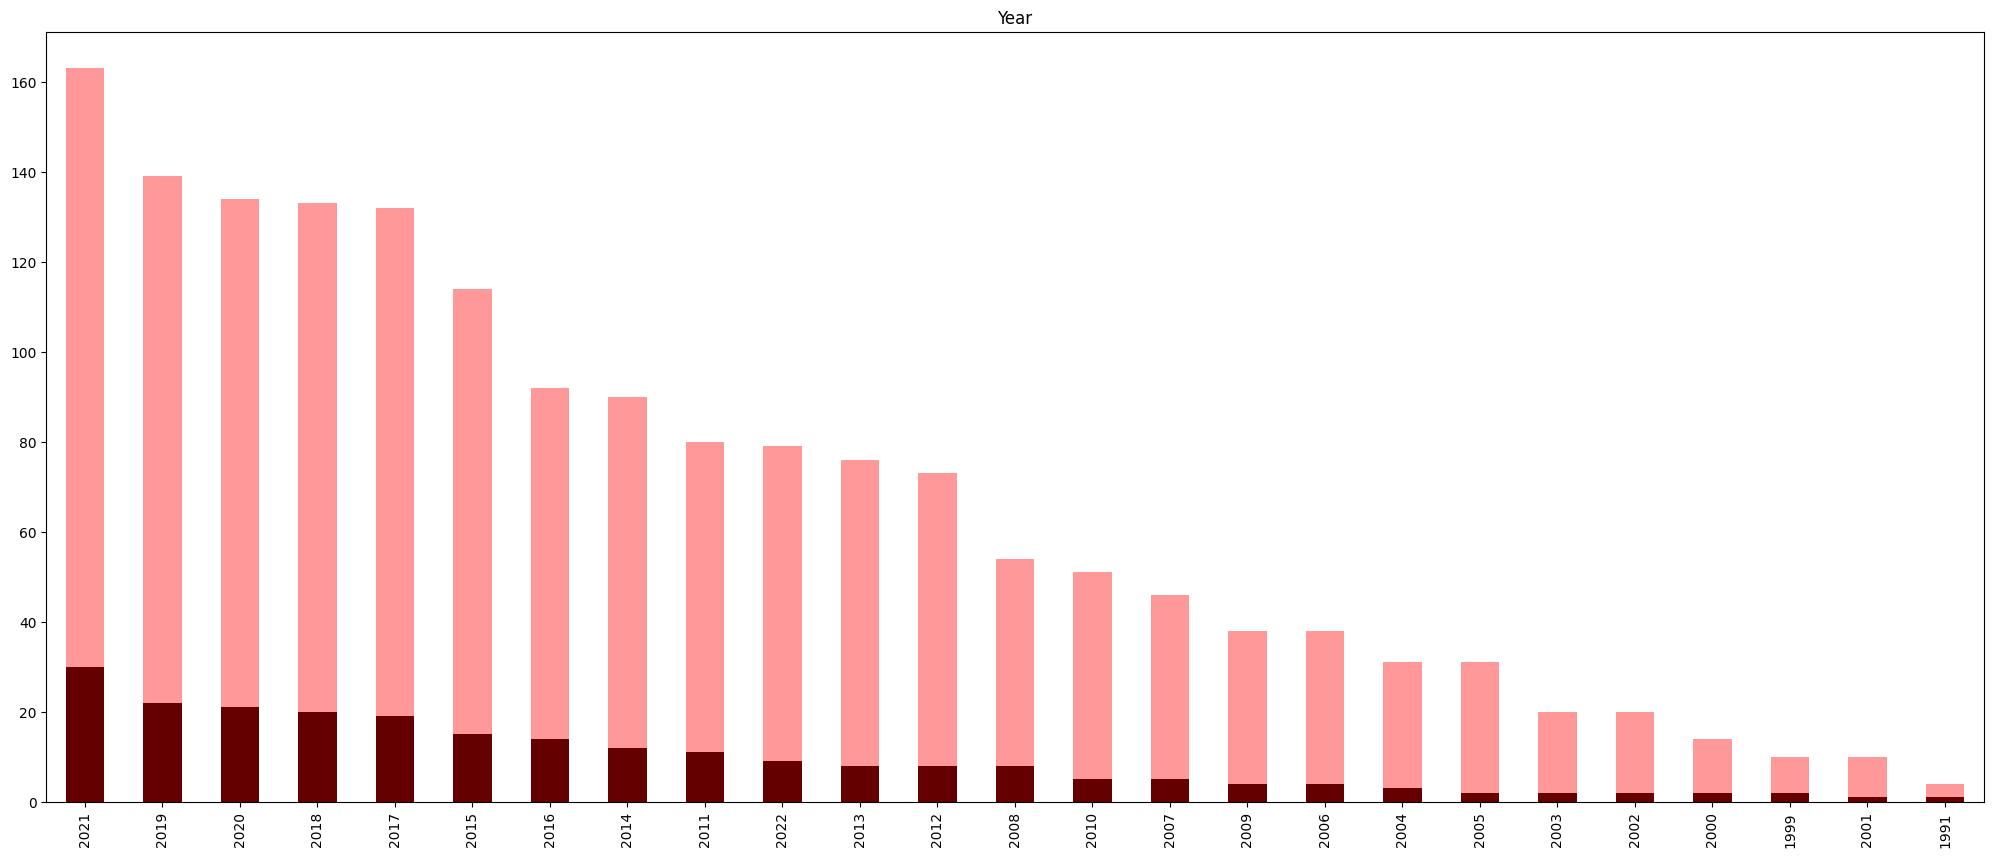

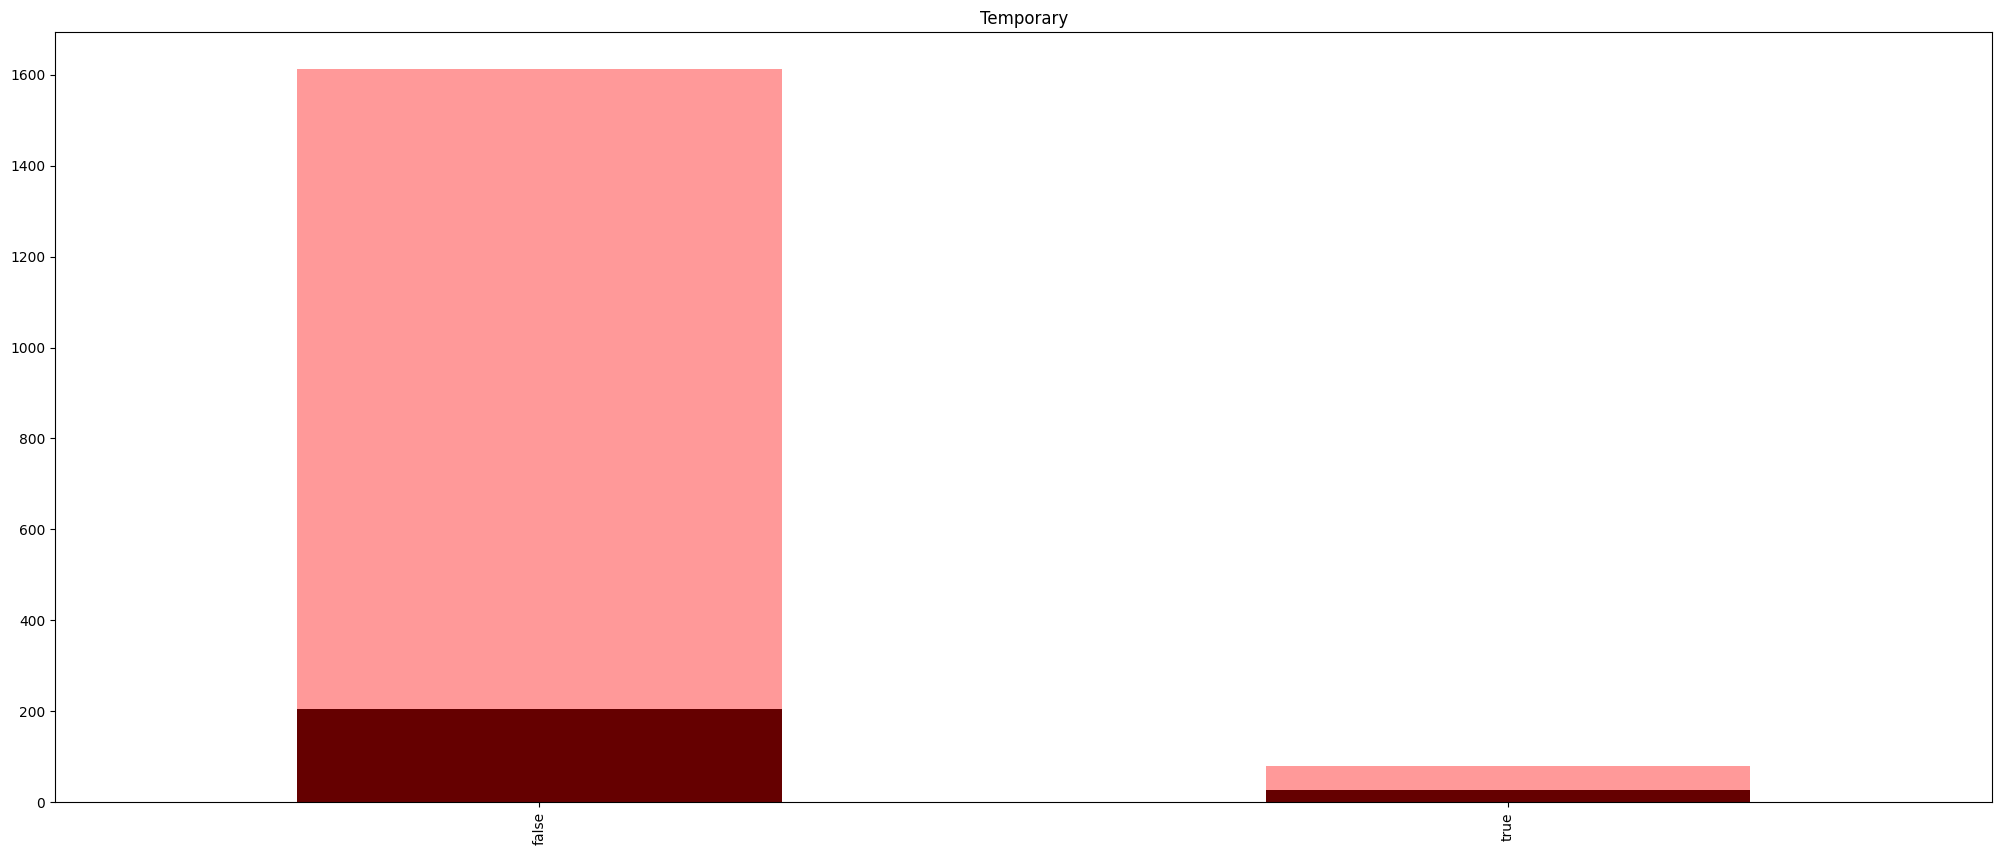

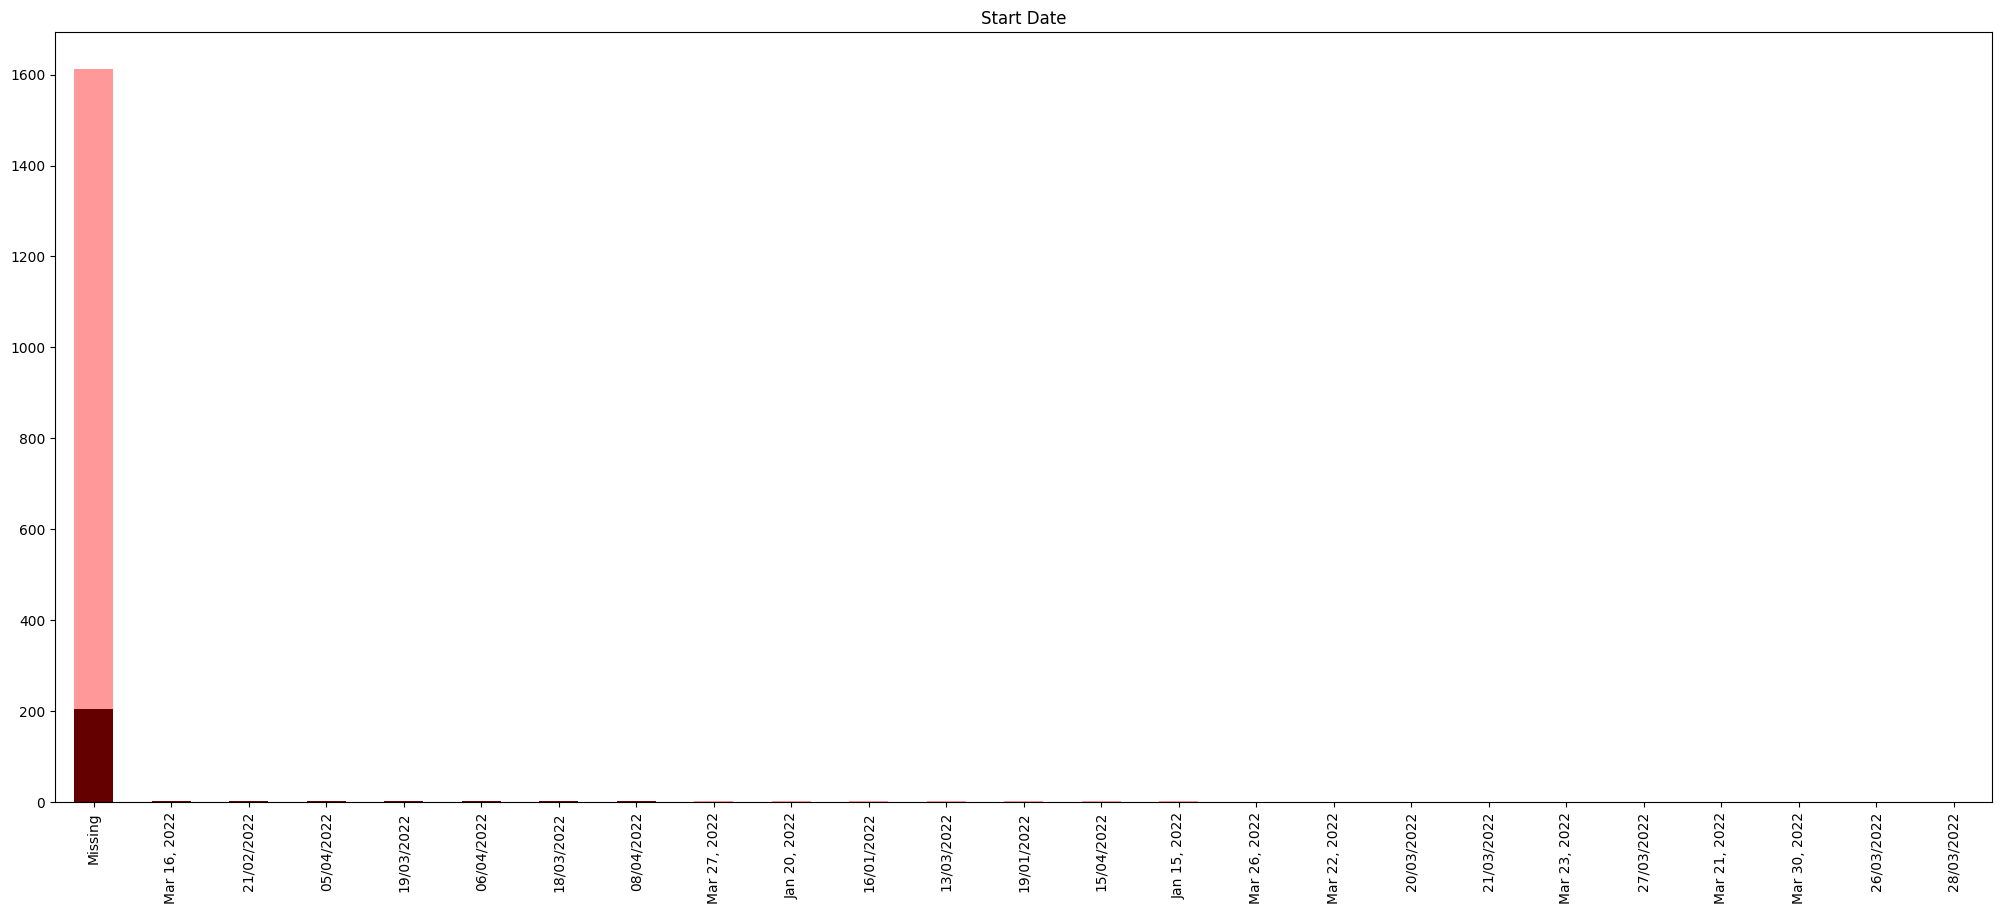

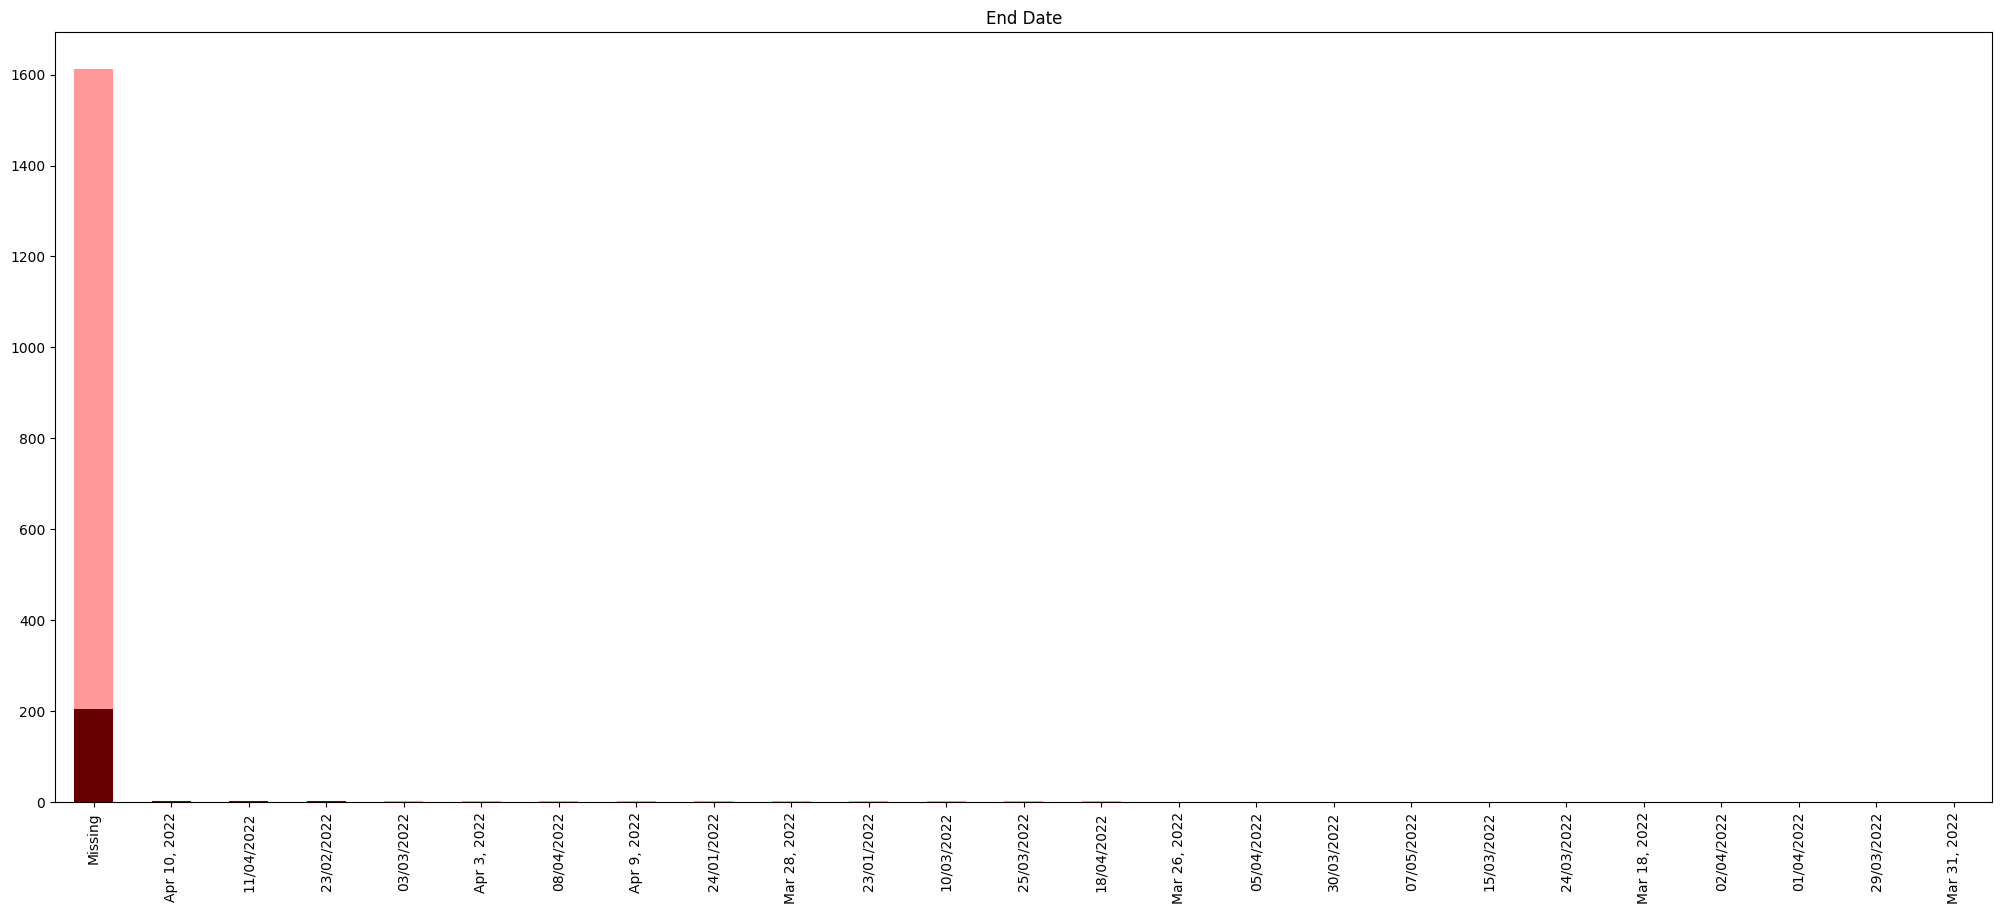

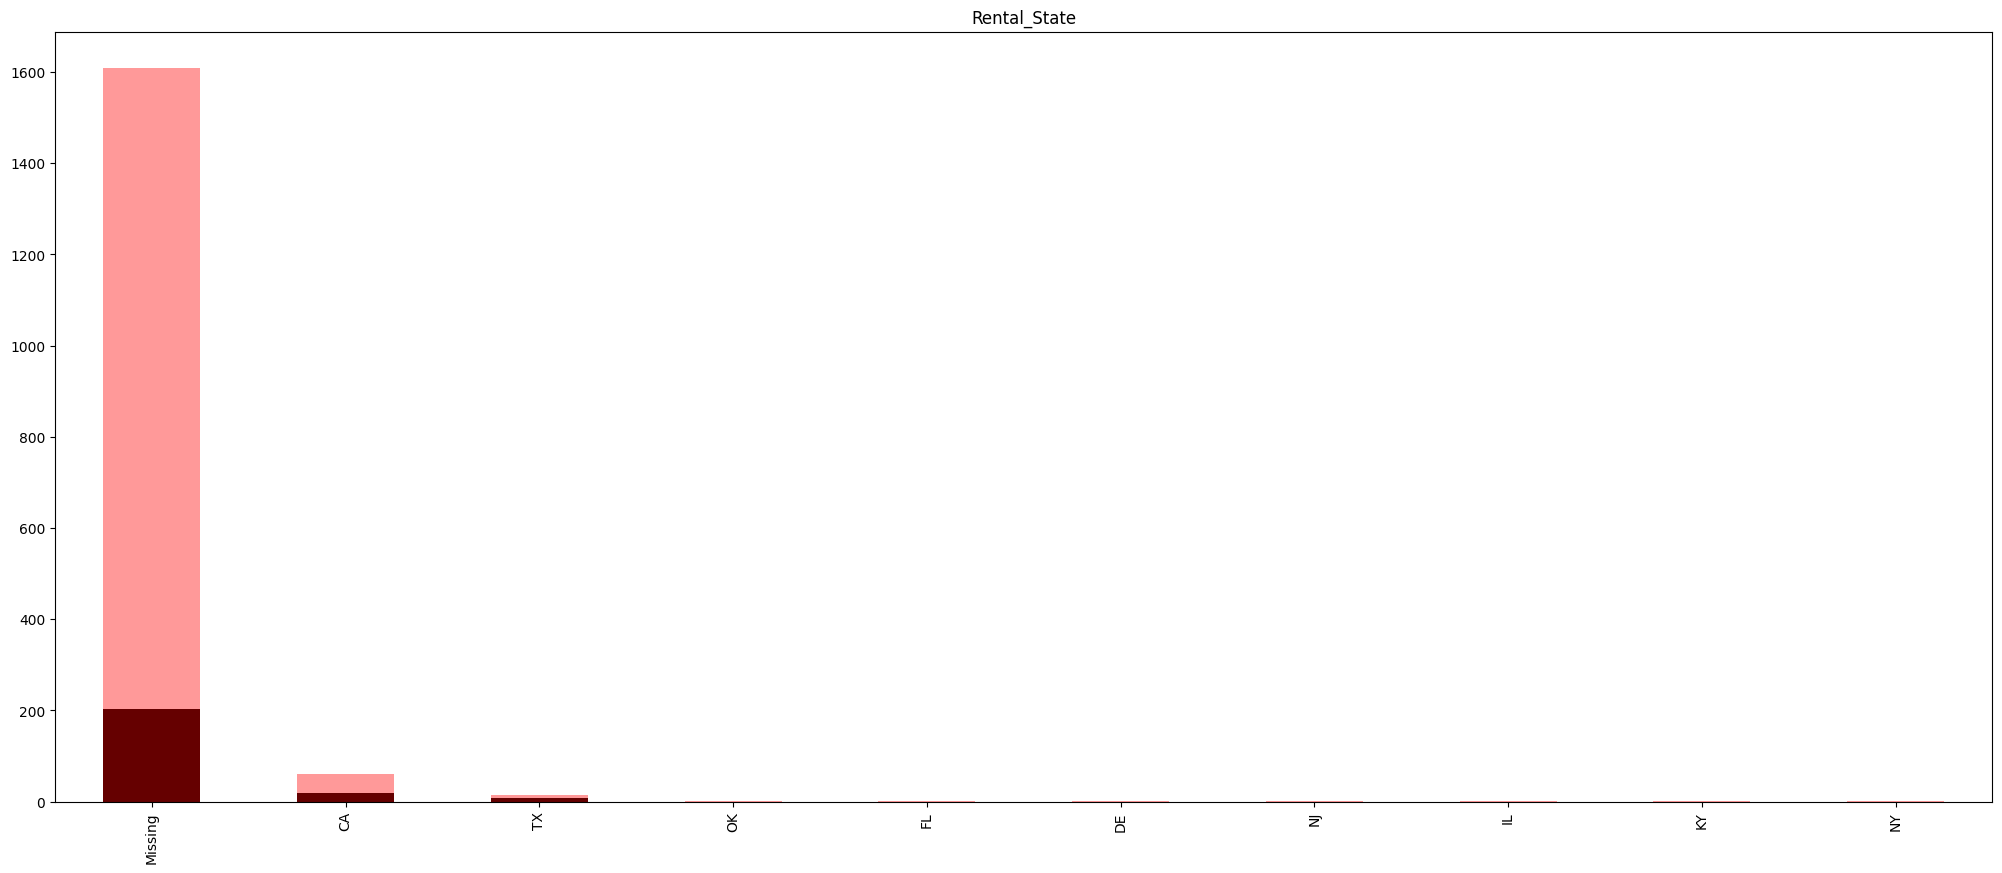

In [66]:
for i in add_vehicle_success.columns[2:]:
    fig, ax = plt.subplots(figsize=(25,10))
    add_vehicle_success[add_vehicle_success["cancelled subscription"] == 1][i].value_counts().head(25).plot.bar(ax=ax, title=i, color = "black")
    add_vehicle_success[add_vehicle_success["cancelled subscription"] == 0][i].value_counts().head(25).plot.bar(ax=ax, title=i, color = "red", alpha=0.4)
plt.show()

Rental State, Start and End date has a lot of missing values, that's why we can drop them. In each feature we will remain the most common values

In [67]:
add_vehicle_success = add_vehicle_success.drop(["Start Date", "End Date", "Rental_State"], axis=1)

add_vehicle_success["Make"] = np.where(add_vehicle_success["Make"].isin(add_vehicle_success["Make"].value_counts()[:5].index),add_vehicle_success["Make"],"Other")
add_vehicle_success["Model"] = np.where(add_vehicle_success["Model"].isin(add_vehicle_success["Model"].value_counts()[:8].index),add_vehicle_success["Model"],"Other")
add_vehicle_success["Color"] = np.where(add_vehicle_success["Color"].isin(add_vehicle_success["Color"].value_counts()[:5].index),add_vehicle_success["Color"],"Other")
add_vehicle_success["Year"] = np.where(add_vehicle_success["Year"].isin(add_vehicle_success["Year"].value_counts()[:5].index),add_vehicle_success["Year"],"Other")

event_attrs = list(add_vehicle_success.columns.values[2:])

In [68]:
sm = SMOTEN()
new_X, new_Y = sm.fit_resample(add_vehicle_success.drop("cancelled subscription", axis = 1), add_vehicle_success['cancelled subscription'])
add_vehicle_success = pd.concat([pd.DataFrame(new_Y), pd.DataFrame(new_X)], axis = 1)
add_vehicle_success.head()

,cancelled subscription,userid,Make,Model,Color,Year,Temporary
0,0,c95c777785faec8dd910d019d7278ebe,Other,Other,White,2019,false
1,0,4d4f4f33c2fd7393093d9f535a92f784,Ford,Other,Black,2017,false
2,0,d6da62f56ee3f76a9cc7f9be92de9253,Chevrolet,Other,White,2020,true
3,0,86963a8dd513a1f38f9f6bd867b45033,Toyota,Camry,Black,Other,false
4,0,5b5ee48d9887d347ce297bc14c395f7a,Honda,Other,Black,2021,true


In [69]:
cramer_v_val_dict = {}
for col in add_vehicle_success.columns[2:]:
    cramer_v_val_dict[col] = cramers_v(add_vehicle_success[col],add_vehicle_success["cancelled subscription"])

cramer_v_val_dict_sorted = sorted(cramer_v_val_dict.items(), key = lambda x:x[1], reverse = True)
for k,v in cramer_v_val_dict_sorted:
    print(k.ljust(21), v)    
    
events_attrs_coefs["Add Vehicle Sucess"] = cramer_v_val_dict_sorted       

Color                 0.17576903776126454
Model                 0.1347241183726756
Temporary             0.12340444147085722
Make                  0.09001330695593882
Year                  0.08428919481292965


Corellation matrix using dython library

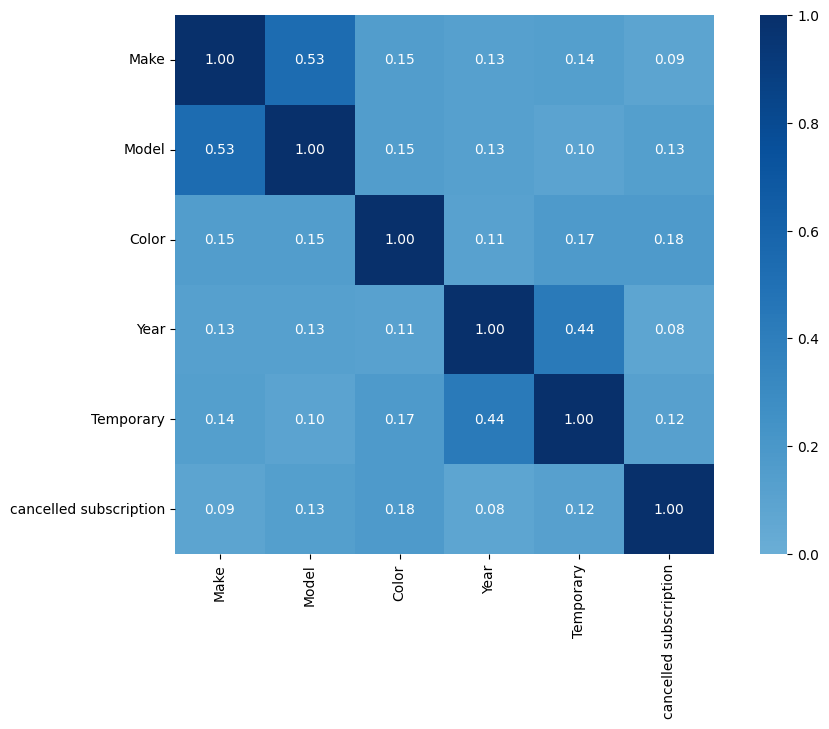

In [70]:
# Instantiate a figure and axis object
fig, ax = plt.subplots(figsize = (12, 7))
# Estimate and generate Cramer's V association plot
cramers_v_plot = associations(add_vehicle_success[event_attrs + ["cancelled subscription"]],
                 nom_nom_assoc = 'cramer', nominal_columns="all",
                 ax = ax,
                 cmap = "Blues")

<h2 style="color:green"> Very weak degree corellation of Vehicle Color with cancelled subscription </h2>
<br></br>


Make
Other                 0.27129954948508983
Chevrolet             0.18786279184282037
Ford                  0.1821730202695064
Honda                 0.1681058213662422
Nissan                0.13698815692654684
Toyota                0.11942010881868273



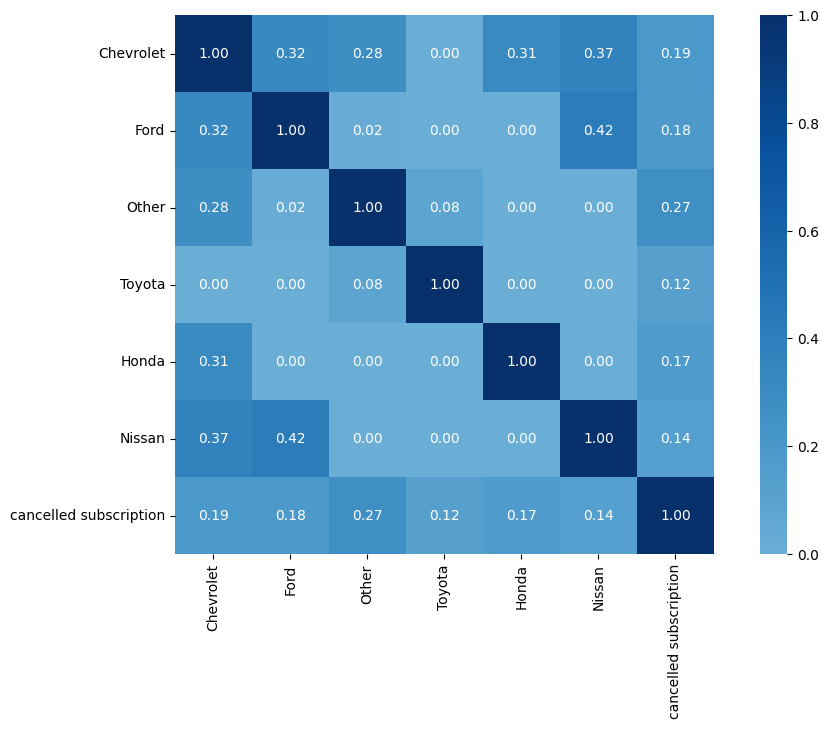


Model
Other                 0.39990647673443214
Accord                0.09939907754769856
Corolla               0.08144146267741294
CR-V                  0.06329513944557057
Camry                 0.05580680679662964
Civic                 0.05325709285287887
Silverado 1500        0.051664329849081266
RAV4                  0.0
Altima                0.0



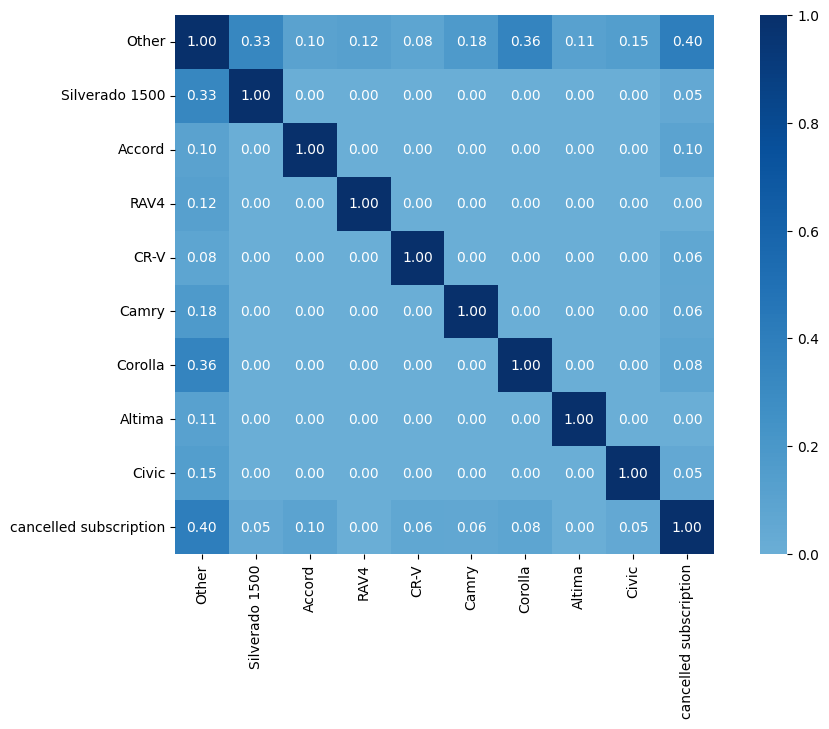


Color
Black                 0.284682170052468
Other                 0.2259042303259263
Gray                  0.19107063067595054
Silver                0.1648915546736456
White                 0.15585041605695982
Blue                  0.14651941385401474



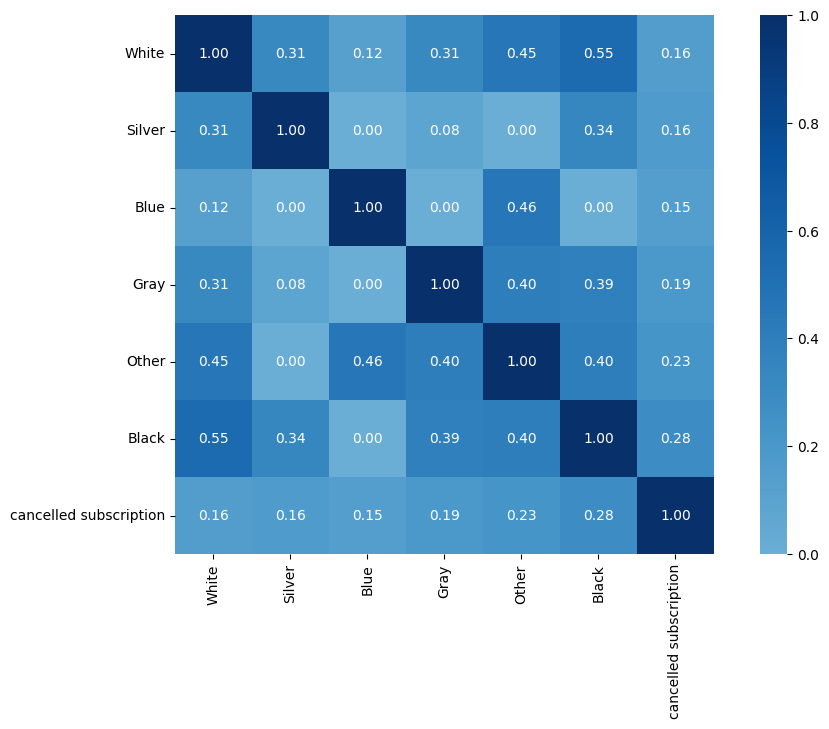


Year
Other                 0.31521284440576963
2019                  0.1685978884457628
2017                  0.1443109848107494
2021                  0.13286565512399567
2018                  0.13265075056156397
2020                  0.11824625766346096



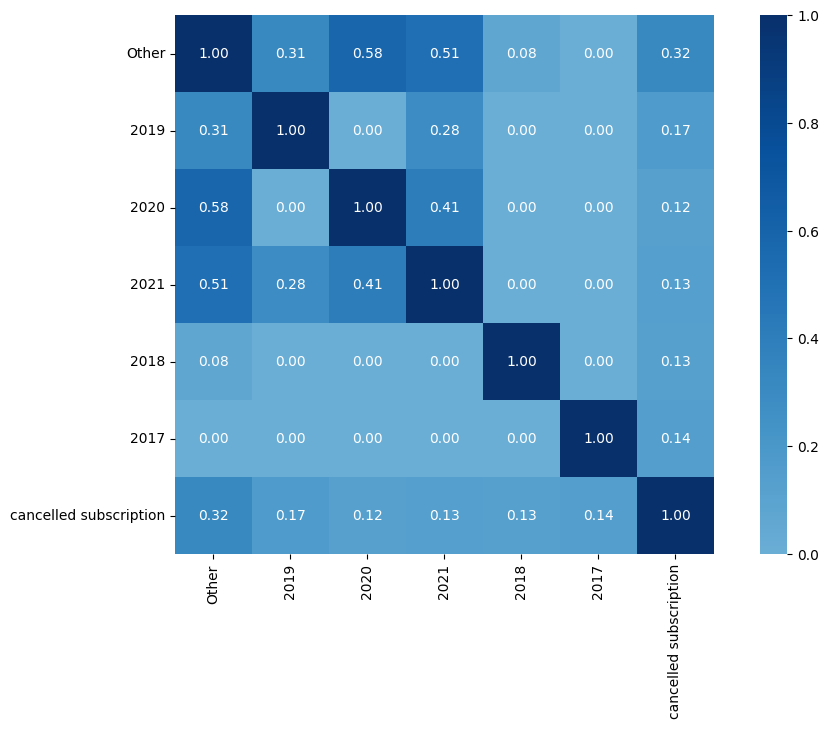


Temporary
false                 0.4284096133230379
true                  0.1525599960763584



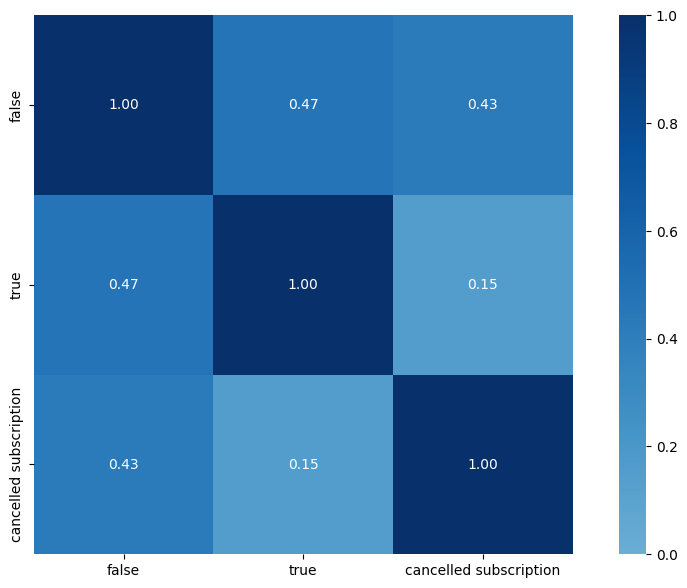

In [71]:
# iterate through unique values of all event parameters
for col in add_vehicle_success.columns.values[2:]:
    d = add_vehicle_success.groupby("userid")[["cancelled subscription"] + [col]]
    cancel_statuses = []
    new_features = []
    count_new_features = len(add_vehicle_success[col].unique())
    for i,j in d:
        new_features.append(dict(j[col].value_counts()))
        cancel_statuses.append(j["cancelled subscription"].unique()[0])
        
    # create temporary dataframe each column of which represent how many times
    # user used certain value of event parameter   
    
    
    temp = pd.DataFrame(new_features).fillna(0)
    temp["cancelled subscription"] = cancel_statuses
    attr_values = temp.columns.values[:(count_new_features+1)]
    
    cramer_v_val_dict = {}
    for index in temp.columns.values[:count_new_features]:
        cramer_v_val_dict[index] = cramers_v(temp[index], temp["cancelled subscription"])
    cramer_v_val_dict_sorted = sorted(cramer_v_val_dict.items(), key = lambda x:x[1], reverse = True)
    print()
    print(col)
    for k,v in cramer_v_val_dict_sorted:
        print(k.ljust(21), v)  
    print()

    
    # Instantiate a figure and axis object
    fig, ax = plt.subplots(figsize = (12, 7))
    # Estimate and generate Cramer's V association plot
    cramers_v_plot = associations(temp,
                 nom_nom_assoc = 'cramer', nominal_columns="all",
                 ax = ax,
                 cmap = "Blues")


<h2 style="color:green"> Very weak degree corellation of Chevrolet Make with cancelled subscription</h2>
<h2 style="color:green"> Moderate degree corellation for False Temporary of Vehicle with cancelled subscription</h2>
<br></br>

<br></br>
<a id = "4.5"></a>
<h2>4.5 Correlation between parametrs of "Account History Transaction Details" event and subscription cancellation</h2>

In [72]:
hist_trans_details = df[df["event_name"] == "Account History Transaction Details"]
converted_dict_by_event_attrs = hist_trans_details.event_attributes.apply(lambda x : pd.Series(ast.literal_eval(x))).fillna(0) 

hist_trans_details = hist_trans_details.join(converted_dict_by_event_attrs)
hist_trans_details = hist_trans_details.drop(hist_trans_details.columns[1:8], axis=1)

hist_trans_details['Status'] = hist_trans_details['Status'].replace([0, ""], "Missing")
hist_trans_details.head()

,userid,cancelled subscription,Type,Navigated From,Status
55,c8d4d395f6b45f1ddd6ab9f29180f54a,0,Auto Payment,account_history,Missing
66,2524f7c94a6d336648a64370b767357a,0,Violation Transaction,Account History,Pending
139,c8d4d395f6b45f1ddd6ab9f29180f54a,0,Pro Plan Subscription,account_history,Paid
170,3470f4afabdbf091c92349cd59b87962,0,Forced Payment,Account History,Pending
171,3470f4afabdbf091c92349cd59b87962,0,Order,Account History,Paid


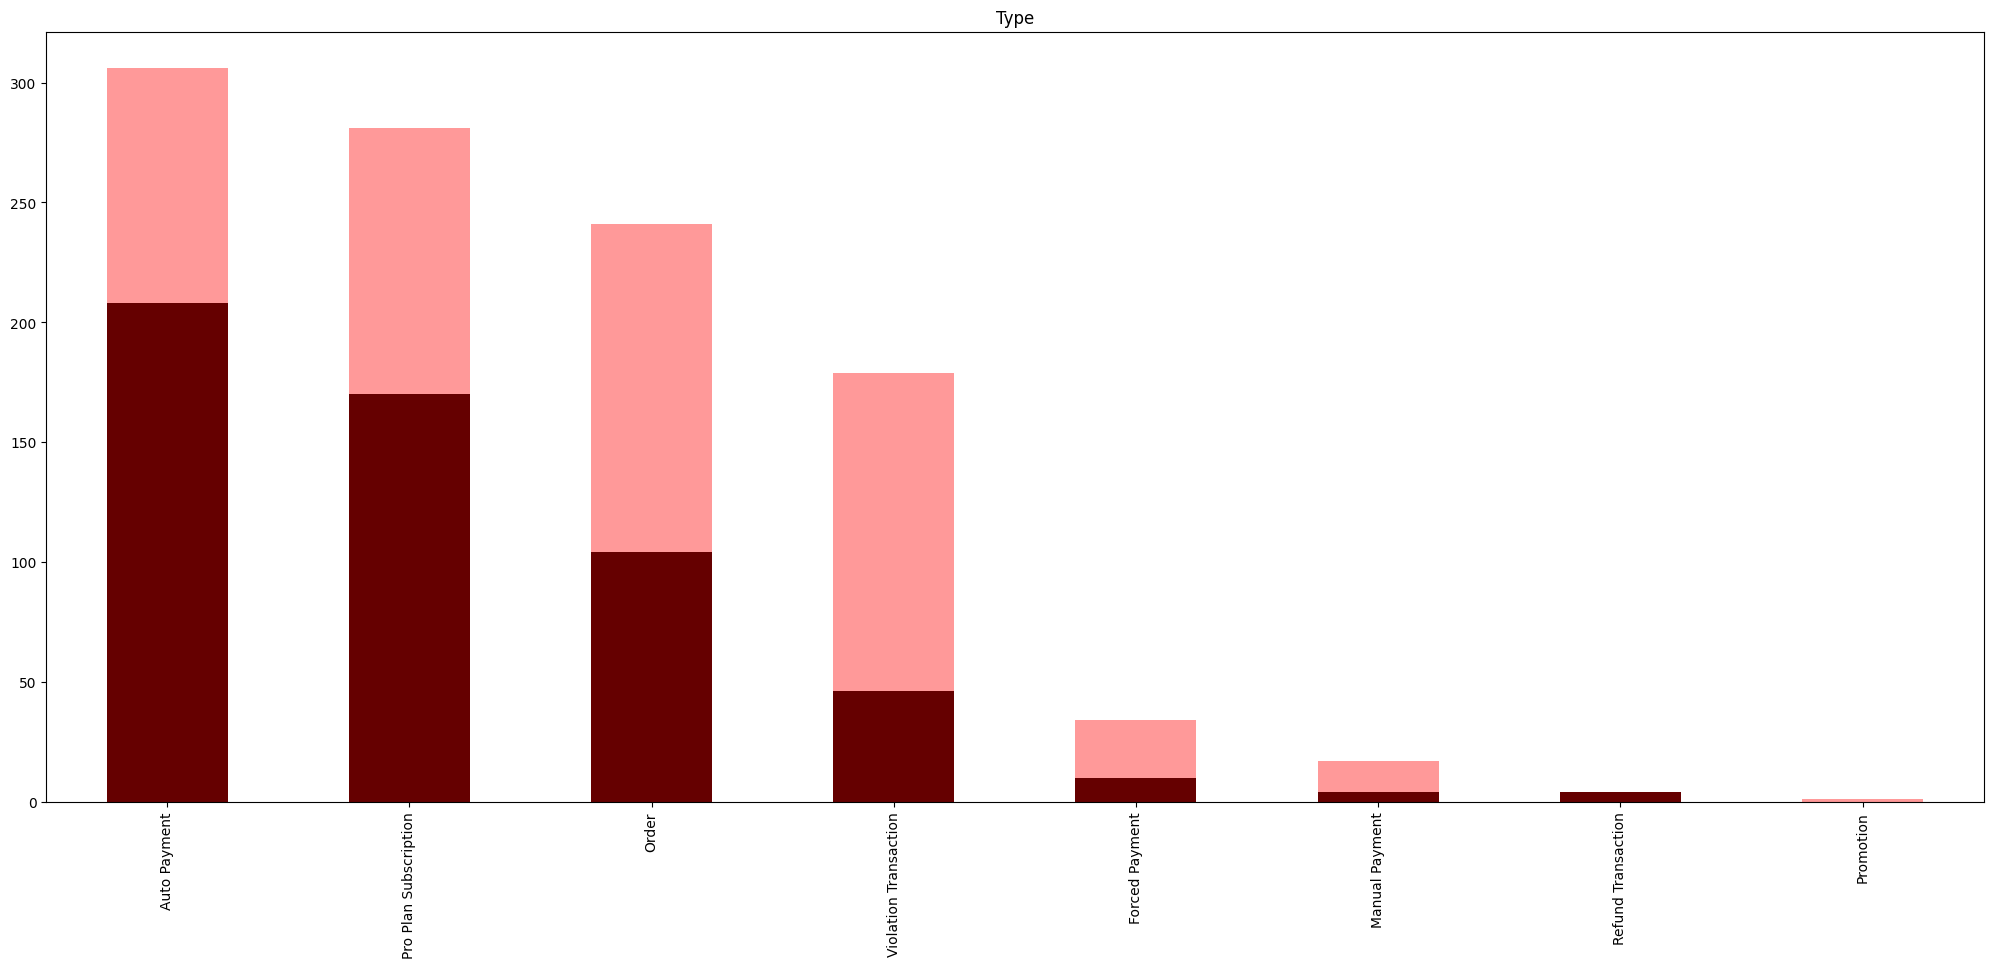

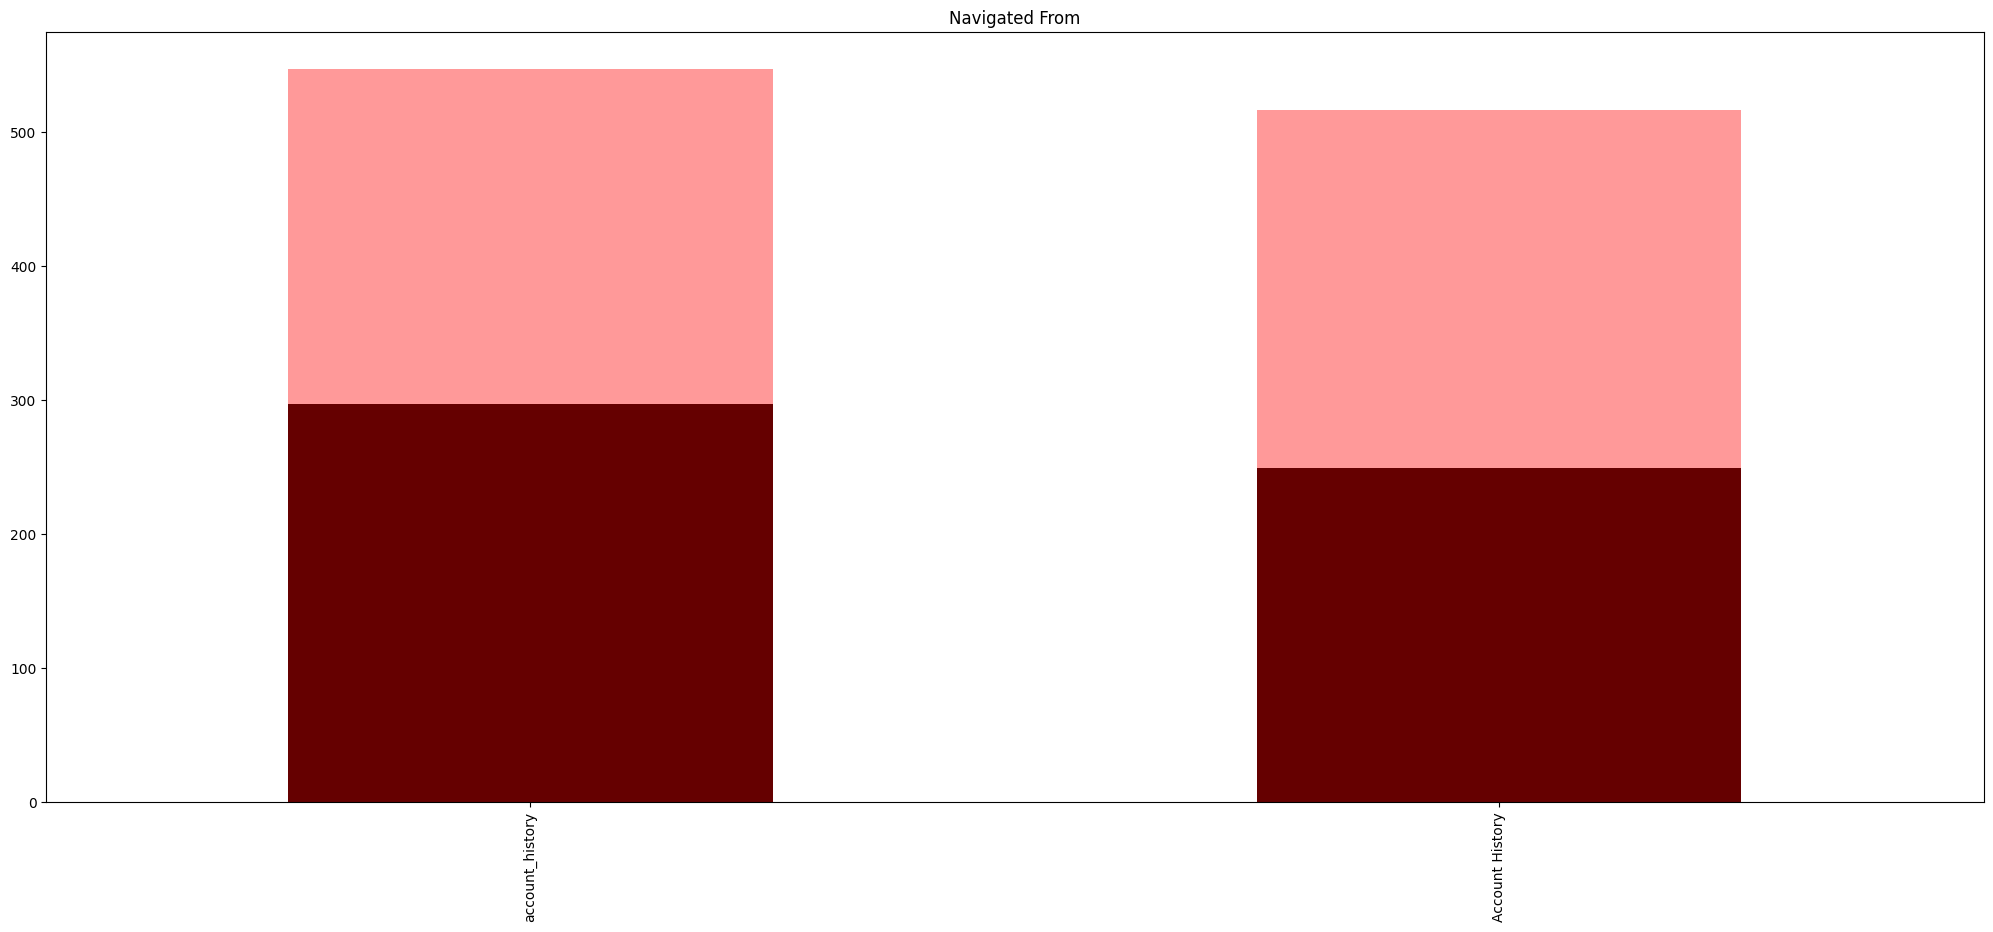

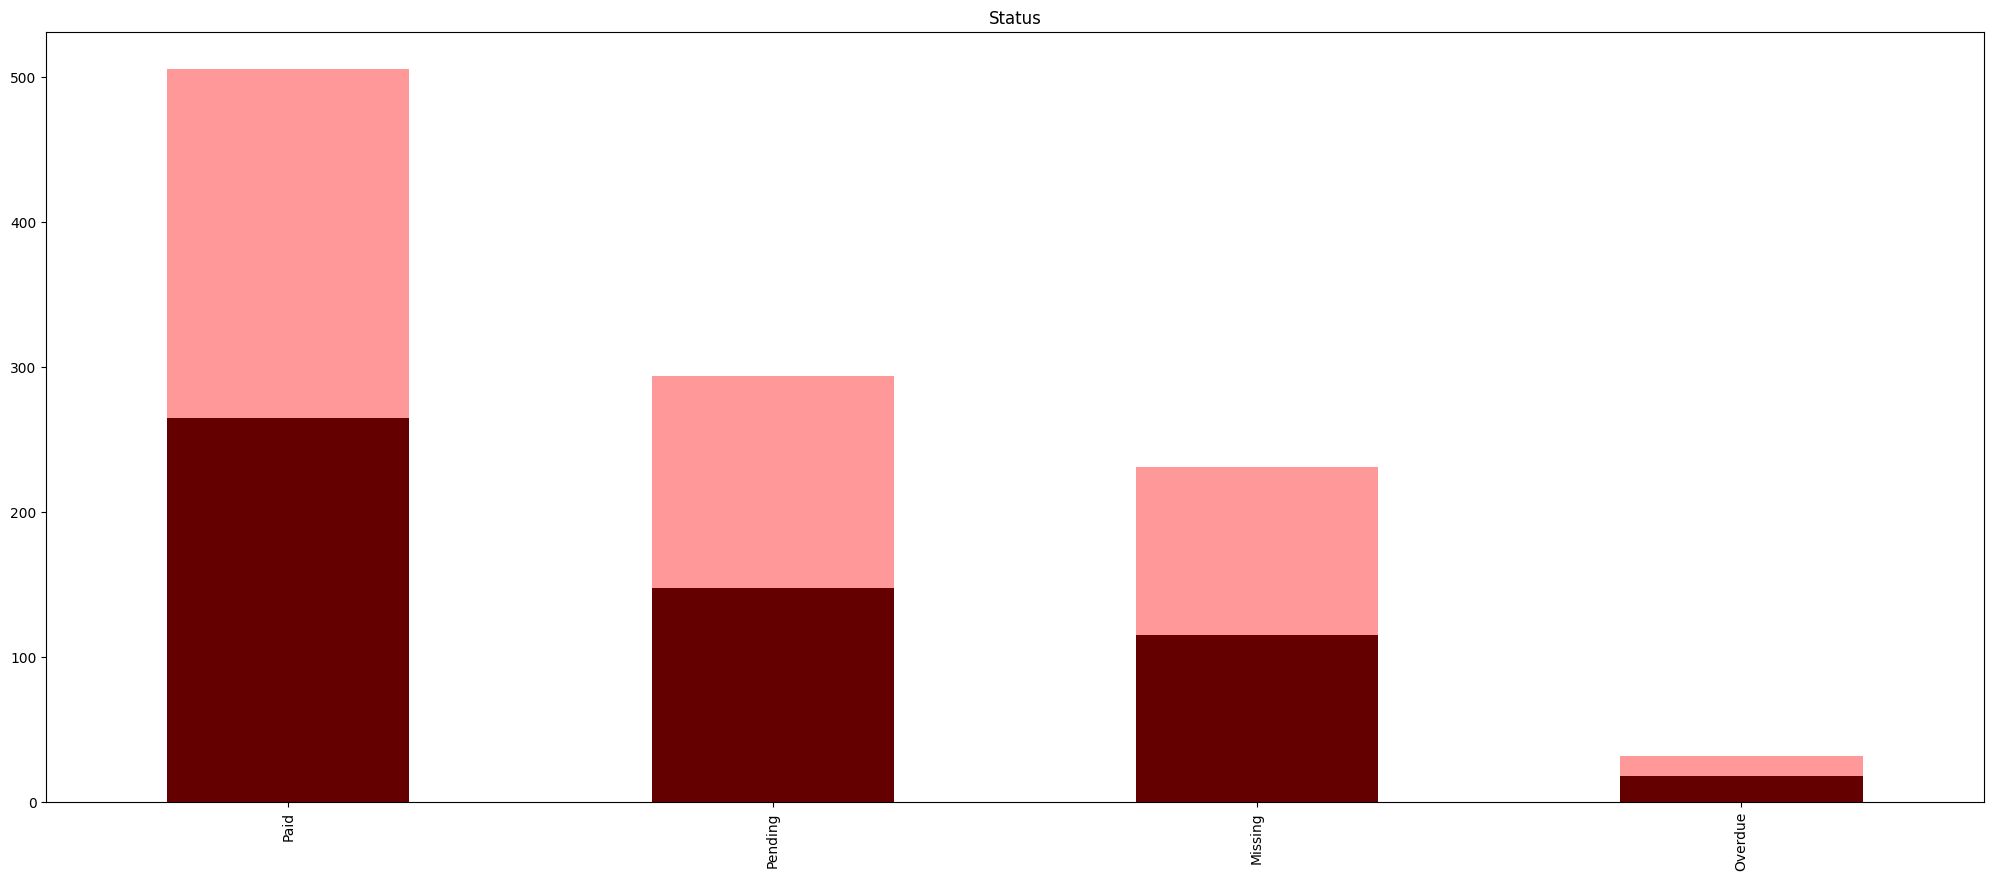

In [73]:
for i in hist_trans_details.columns[2:]:
    fig, ax = plt.subplots(figsize=(25,10))
    hist_trans_details[hist_trans_details["cancelled subscription"] == 1][i].value_counts().head(25).plot.bar(ax=ax, title=i, color = "black")
    hist_trans_details[hist_trans_details["cancelled subscription"] == 0][i].value_counts().head(25).plot.bar(ax=ax, title=i, color = "red", alpha=0.4)
plt.show()

Let's remain most common types of transactions

In [74]:
hist_trans_details["Type"] = np.where(hist_trans_details["Type"].isin(hist_trans_details["Type"].value_counts()[:5].index),hist_trans_details["Type"],"Other")
event_attrs = list(hist_trans_details.columns.values[2:])

In [75]:
sm = SMOTEN()
new_X, new_Y = sm.fit_resample(hist_trans_details.drop("cancelled subscription", axis = 1), hist_trans_details['cancelled subscription'])
hist_trans_details = pd.concat([pd.DataFrame(new_Y), pd.DataFrame(new_X)], axis = 1)
hist_trans_details.head()

,cancelled subscription,userid,Type,Navigated From,Status
0,0,c8d4d395f6b45f1ddd6ab9f29180f54a,Auto Payment,account_history,Missing
1,0,2524f7c94a6d336648a64370b767357a,Violation Transaction,Account History,Pending
2,0,c8d4d395f6b45f1ddd6ab9f29180f54a,Pro Plan Subscription,account_history,Paid
3,0,3470f4afabdbf091c92349cd59b87962,Forced Payment,Account History,Pending
4,0,3470f4afabdbf091c92349cd59b87962,Order,Account History,Paid


In [76]:
cramer_v_val_dict = {}
for col in hist_trans_details.columns[2:]:
    cramer_v_val_dict[col] = cramers_v(hist_trans_details[col],hist_trans_details["cancelled subscription"])

cramer_v_val_dict_sorted = sorted(cramer_v_val_dict.items(), key = lambda x:x[1], reverse = True)
for k,v in cramer_v_val_dict_sorted:
    print(k.ljust(21), v)    
    
events_attrs_coefs["Account History Transactions Details"] = cramer_v_val_dict_sorted       

Type                  0.16469727765751113
Status                0.07599585336106736
Navigated From        0.0


Correlation matrix using dython library

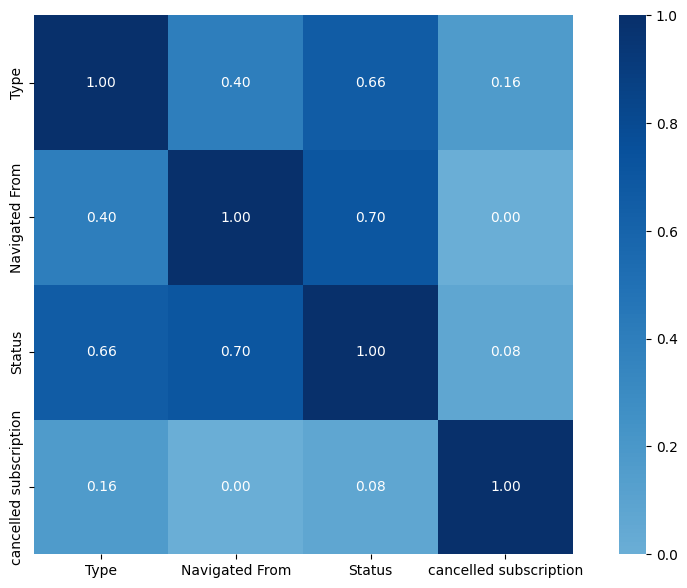

In [77]:
# Instantiate a figure and axis object
fig, ax = plt.subplots(figsize = (12, 7))
# Estimate and generate Cramer's V association plot
cramers_v_plot = associations(hist_trans_details[event_attrs + ["cancelled subscription"]],
                 nom_nom_assoc = 'cramer', nominal_columns="all",
                 ax = ax,
                 cmap = "Blues")


Type
Auto Payment          0.1717829524254384
Pro Plan Subscription 0.09729852606184419
Violation Transaction 0.08503060294552693
Order                 0.0
Forced Payment        0.0
Other                 0.0



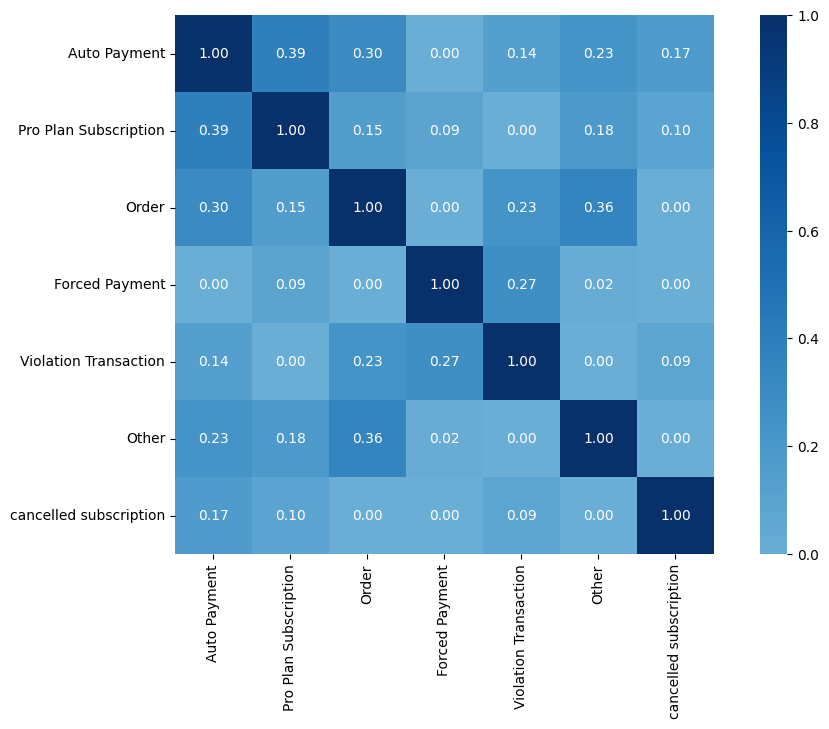


Navigated From
Account History       0.12327581028825457
account_history       0.08135954398243052



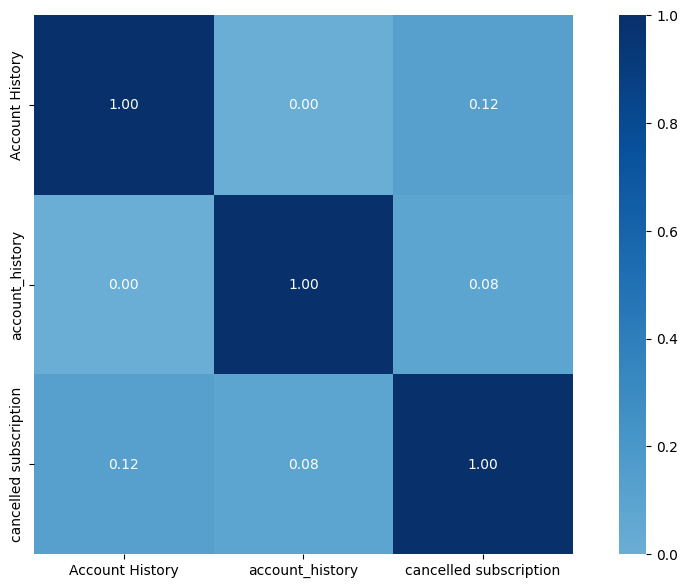


Status
Missing               0.10596643315242518
Paid                  0.0822625987359286
Pending               0.07017945167934074
Overdue               0.0



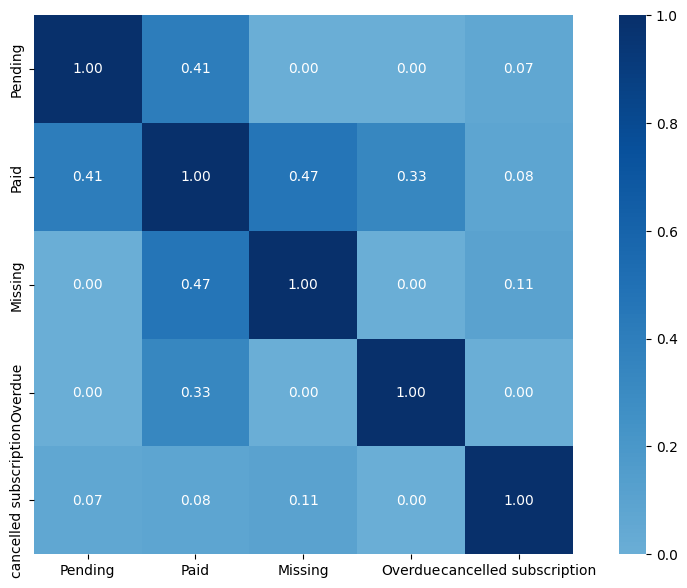

In [78]:
# iterate through unique values of all event parameters
for col in hist_trans_details.columns.values[2:]:
    d = hist_trans_details.groupby("userid")[["cancelled subscription"] + [col]]
    cancel_statuses = []
    new_features = []
    count_new_features = len(hist_trans_details[col].unique())
    for i,j in d:
        new_features.append(dict(j[col].value_counts()))
        cancel_statuses.append(j["cancelled subscription"].unique()[0])
        
    # create temporary dataframe each column of which represent how many times
    # user used certain value of event parameter   
    
    
    temp = pd.DataFrame(new_features).fillna(0)
    temp["cancelled subscription"] = cancel_statuses
    attr_values = temp.columns.values[:(count_new_features+1)]
    
    #calculate Cramer's V coef.
    cramer_v_val_dict = {}
    for index in temp.columns.values[:count_new_features]:
        cramer_v_val_dict[index] = cramers_v(temp[index], temp["cancelled subscription"])
    cramer_v_val_dict_sorted = sorted(cramer_v_val_dict.items(), key = lambda x:x[1], reverse = True)
    print()
    print(col)
    for k,v in cramer_v_val_dict_sorted:
        print(k.ljust(21), v)  
    print()

    
    # Instantiate a figure and axis object
    fig, ax = plt.subplots(figsize = (12, 7))
    # Estimate and generate Cramer's V association plot
    cramers_v_plot = associations(temp,
                 nom_nom_assoc = 'cramer', nominal_columns="all",
                 ax = ax,
                 cmap = "Blues")

<h2 style="color:green"> Very weak degree corellation of Auto Payment Type with cancelled subscription. We can assume that users look at auto-pay information much more often before unsubscribing </h2>


<a id = "5"></a>
<br></br>
<h1 style="color:blue" id="5">5. Conclusions</h1>

<h4>We have analyzed the relationships between the main properties of the application user, events, event attributes, and unsubscribing.</h4>

<h3>Below is a list of user attributes from highest to lowest correlation.</h3>

In [79]:
for k, v in users_props_coefs:
    print('\033[92m' + str(k) + " ~ " + str(round(v,2)) )

outofband ~ 0.82
days_using ~ 0.4
user_state ~ 0.33
device_manufactured ~ 0.22
ios ~ 0.01
android ~ 0.0


<h3 style="color:green">Insights: </h3> 
<h4>Users that cancelled subsription were often accessing app by out of band platform. </h4>
<h4>It can be assumed that users in California are more likely to unsubscribe than users in other states</h4>
<h4>Days of using app has moderate corellation with subscription cancellation.</h4>
<br></br>

<h3>Next is a list of user events from highest to lowest correlation.</h3>

In [80]:
for k, v in events_coefs:
    print('\033[92m' + str(k) + " ~ " + str(round(v,2)) )

Chat Conversation Started ~ 0.75
Subscription Premium ~ 0.75
Add Payment Method Success ~ 0.7
Chat Conversation Opened ~ 0.63
Wallet Opened ~ 0.59
Account History Transaction Details ~ 0.52
Add Vehicle Success ~ 0.45
Email Confirmation Success ~ 0.26
Add Vehicle Break ~ 0.2
Account Setup Skip ~ 0.17
Sign Out ~ 0.17
Add Payment Method Failed ~ 0.16
Calculator View ~ 0.15
Order ~ 0.15
Account Setup Profile Skip ~ 0.15
Subscription Premium Renew ~ 0.09
Sign Up Success ~ 0.08
Transaction Refund ~ 0.06
Sign Up Error ~ 0.04
Add Vehicle Failed ~ 0.02
Calculator Used ~ 0.01
Reset Password Set ~ -0.01


<h3 style="color:green">Insights: </h3> 
<h4>Buying Subscription Premium is highly correlated with premium subscription cancellation. Approximately 7% of users cancelled subscription more than 1 time. </h4>
<h4>Adding payment and vehicle registration are moderately corellated with subscription cancellation. We can assume that the more often you add a payment method and a vehicle to the app, the higher the probability of unsubscribing </h4>
<h4>High degree of correlation for Chat Conversation Started. The more often a user accesses the support chat, the higher the probability of unsubscribing</h4>
<h4>Moderate degree for Wallet Opened and Account History Transaction Details. We can assume that such actions as checking billing errors and current balance increase probability of subscription cancellation</h4>
<br></br>

<h3>Next is a list of events attributes from highest to lowest correlation.</h3>

In [81]:
events_attrs_coefs = sorted(events_attrs_coefs.items(), key = lambda x:x[1], reverse = True)
for k,v in events_attrs_coefs:
    print('\033[92m' + str(k) + ":" )   
    print(v)
    print()

Account History Transactions Details:
[('Type', 0.16469727765751113), ('Status', 0.07599585336106736), ('Navigated From', 0.0)]

Subscription Premium:
[('Start Date', 0.4440823140372708), ('Renewal Date', 0.4364389804386105), ('Renewal Month', 0.23587098682301985), ('Start Month', 0.21784999034449384)]

Add Payment Method Success:
[('Payment Method', 0.21000391291087614), ('Tokenized Pay', 0.0)]

Chat Conversation Opened:
[('From', 0.13486986276477664), ('Transaction_Type', 0.05965484253142437)]

Add Vehicle Sucess:
[('Color', 0.17576903776126454), ('Model', 0.1347241183726756), ('Temporary', 0.12340444147085722), ('Make', 0.09001330695593882), ('Year', 0.08428919481292965)]



<h3 style="color:green">Insights: </h3> 
<h4>We can assume that users who, started premium subscription in April, cancelled it more often.</h4>
<h4>Also we can assume that users who used credit card as payment method cancelled subsciption more often.</h4>
<h4>Chat conversation opened from Menu has moderate corellation with cancelled subscription. Users who opened the support chat from the app menu rather than from the dashboard were more likely to unsubscribe </h4>
<h4>We can assume that users look at auto-pay information much more often before unsubscribing </h4>
<h4>Users who added Chevrolet vehicle have very weak correlation with subscription cancellation</h4>